# Power Balance Dataset Preprocessing & Modeling Workflow
This notebook provides a comprehensive pipeline for preparing, enriching, and modeling the power balance (powbal) dataset, with a focus on predicting user override behavior and energy savings in demand response events. The workflow integrates data cleaning, feature engineering, weather enrichment, clustering, and both classical and deep learning modeling.

## Workflow Steps
### 1. Import Libraries
Load all necessary Python libraries for data manipulation, visualization, machine learning, and deep learning.

### 2. Load and Clean Data
Load the main smart switch dataset and customer location data.
Drop columns with excessive missing values or redundancy.
Standardize and clean feature names.
### 3. Weather Data Integration
Load and preprocess weather datasets for Delhi and Mumbai.
Merge weather data with smart switch data based on timestamp, city, and location (spatial-temporal alignment).
Impute missing latitude/longitude for customers using city-wise averages.
### 4. Feature Engineering
Handle categorical feature typos and encode categories.
Impute missing values for both numerical and categorical features using appropriate strategies (median, mode, or constants).
Engineer new features such as fatigue (rolling event counts, override rates), time-of-use (cyclical encodings), and sequential behavior summaries.
### 5. Exploratory Data Analysis (EDA)
Visualize distributions of numerical features.
Plot correlation heatmaps to identify and drop highly correlated features.
### 6. Dimensionality Reduction & Clustering
Aggregate event-level data to customer-level summaries.
Perform PCA for dimensionality reduction.
Cluster customers using KMeans and DBSCAN, both with all features and with leak-safe (non-leaky) features.
Analyze and visualize cluster profiles.
### 7. Modeling: Override Prediction
Chronologically split the dataset into train/validation/test sets.
Build and preprocess leak-safe feature sets.
Handle class imbalance via downsampling.
Train and evaluate baseline models (Logistic Regression, XGBoost) for override prediction.
Analyze feature importances using SHAP and permutation methods.
### 8. Modeling: Energy Savings Prediction
Engineer strict pre-notice, leak-safe features for energy savings regression.
Train LightGBM, Linear Regression, Ridge Regression, and deep learning models (LSTM, TCN) to predict energy savings.
Evaluate models using RMSE/MAE and interpret feature importances with SHAP and occlusion analysis.
### 9. Deep Learning Sequence Modeling
Prepare data for sequence models (LSTM, TCN) with sliding windows.
Train and evaluate sequence models for override and energy savings prediction.
Use Optuna for hyperparameter tuning of deep models.
### 10. Interpretation & Reporting
Summarize key findings from feature importance and SHAP analysis.
Visualize model performance and feature impacts.
Provide guidance for downstream modeling and analysis.
### Key Outputs
Cleaned and feature-rich event-level dataset.
Customer-level cluster labels (all-features and leak-safe).
Trained models for override and energy savings prediction.
Feature importance and SHAP explanations for model interpretability.

### Import the module

In [ ]:
# ── Standard Library ──────────────────────────────────────────────────────────
import gc
import math
import os
import random
import re
import time
import warnings
from contextlib import nullcontext
from functools import partial
from typing import Dict, Hashable, Iterable, List, Optional, Tuple

# ── Core Data Science & Plotting ──────────────────────────────────────────────
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from pandas.api.types import CategoricalDtype
from scipy import sparse
from scipy.stats import gaussian_kde, probplot, shapiro
from tqdm.auto import tqdm
import shap

# ── Machine Learning (Scikit-Learn, XGBoost, LightGBM) ────────────────────────
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN, KMeans
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import (
    adjusted_rand_score,
    average_precision_score,
    classification_report,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    silhouette_score,
)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.neighbors import KDTree
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler

# ── Deep Learning (PyTorch) ───────────────────────────────────────────────────
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import amp
from torch.utils.data import DataLoader, Dataset

# ── Hyperparameter Optimization ────────────────────────────────────────────────
import optuna
from optuna.samplers import TPESampler
from optuna.trial import Trial


In [ ]:
# pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 15.4 MB/s eta 0:00:00


In [2]:
# function to read CSV with missing value checks
def read_csv_with_checks(file_path, **read_csv_kwargs):
    """
    Reads a CSV file into a DataFrame, reports columns with missing values,
    and returns the DataFrame.

    Parameters
    ----------
    file_path : str
        Path to the CSV file.
    **read_csv_kwargs :
        Extra keyword arguments forwarded to `pd.read_csv`
        (e.g. dtype=…, low_memory=False, chunksize=…).

    Returns
    -------
    pd.DataFrame
        The loaded DataFrame.

    Raises
    ------
    FileNotFoundError
        If the file does not exist.
    Exception
        For any other unexpected errors.
    """
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")

        df = pd.read_csv(file_path, **read_csv_kwargs)

        # Count missing values per column and keep only the non-zero ones
        missing_summary = df.isnull().sum()
        missing_summary = (
            missing_summary[missing_summary > 0]
            .sort_values(ascending=False)
        )

        if not missing_summary.empty:
            with pd.option_context("display.max_rows", None):
                print("Missing-value report:")
                print(missing_summary)
        else:
            print("No missing values detected.")

        print(f"Data loaded successfully. Number of records: {len(df):,}")
        return df

    except FileNotFoundError:
        raise  # re-raise so the caller can handle it
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise


### Load the data

In [3]:
# This file is runing on Google Colab, if you are using Jupyter Notebook, please ignore this part and just the file path
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load the powbal_smart_switch_data

# uncomment the file path you want to use (for non-colab)
# file_path = '../powbal_clean.csv'
# file_path = '../data/powbal_smart_switch_data/powbal_smart_switch_data.csv'

# This is for colab file
file_path = '/content/drive/MyDrive/Colab_Notebooks/IRP/powbal_clean.csv'

try:
    df = read_csv_with_checks(file_path)
    smart_switch_data = df.copy()
except Exception as e:
    print(f"Failed to load data: {e}")

smart_switch_data.describe().T.round(2)

# del df to save memeory
del df

/tmp/ipython-input-1238840958.py:30: DtypeWarning: Columns (5,6,8,16,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, **read_csv_kwargs)


Missing-value report:
deactivated_at                    7391239
average_power_before_switchoff    7314862
reward2                           7261725
mean_W_before_switchoff           7121578
avoided_energy_consumption_Wh     7120234
reward                            7120234
off                               7120231
schedule_id                       7120231
notify_participant_at             7120231
on                                7120231
notification_hour                 7120231
switch_off_hour                   7120231
switch_on_time                    7120231
posted_to_api                     7120231
switch_off                        7120231
switch_on                         7120231
notification                      7120231
switch_off_time                   7120231
notification_time                 7120231
power_nonzero                     5227539
surveyanswer                      2320942
appliance                            1778
preference                           1778
pre_switch_o

Drop some feature with high missing value

In [ ]:
# Drop the feature with almost missing all value
drop_missing_value_list = [
    'deactivated_at',
    'reward2',
    'off',
    'schedule_id',
    'notify_participant_at',
    'on',
    'notification_hour',
    'switch_off_hour',
    'switch_on_time',
    'posted_to_api',
    'switch_off',
    'switch_on',
    'notification',
    'switch_off_time',
    'notification_time'
]
smart_switch_data.drop(columns=drop_missing_value_list, inplace=True)

Load the weather dataset (from weather_dataset_preprocess.ipynb file)

In [ ]:
# load the weather data
print("===== weather_delhi_2023: =====")
weather_delhi_2023 = read_csv_with_checks('../power-data/weather-delhi-2023.csv')
print("\n===== weather_delhi_2024: =====")
weather_delhi_2024 = read_csv_with_checks('../power-data/weather-delhi-2024.csv')

print("\n===== weather_mumbai_2023: =====")
weather_mumbai_2023 = read_csv_with_checks('../power-data/weather-mumbai-2023.csv')
print("\n===== weather_mumbai_2024: =====")
weather_mumbai_2024 = read_csv_with_checks('../power-data/weather-mumbai-2024.csv')

===== weather_delhi_2023: =====
Missing-value report:
surface_net_solar_radiation          62100
surface_solar_radiation_downwards    62100
dtype: int64
Data loaded successfully. Number of records: 251,850

===== weather_delhi_2024: =====
No missing values detected.
Data loaded successfully. Number of records: 252,540

===== weather_mumbai_2023: =====
Missing-value report:
surface_net_solar_radiation          31050
surface_solar_radiation_downwards    31050
dtype: int64
Data loaded successfully. Number of records: 125,925

===== weather_mumbai_2024: =====
No missing values detected.
Data loaded successfully. Number of records: 126,270


### Load the customer location dataset and weather_full dataset and merge to power_dataset

In [ ]:
# This is for local file path
# all_customers_path = 'data/all_customers.csv'

# This is for colab file path
all_customers_path = '/content/drive/MyDrive/Colab_Notebooks/IRP/power-data/all_customers.csv'
all_customers = read_csv_with_checks(all_customers_path)

all_customers.describe().T.round(2)

No missing values detected.
Data loaded successfully. Number of records: 514


count          mean           std           min           25%  \
Unnamed: 0  514.0  7.840451e+04  5.791331e+04  6.000000e+00  2.108875e+04   
CA_ID       514.0  2.495854e+11  3.514804e+11  6.000029e+10  6.001163e+10   
latitude    514.0  2.655000e+01  4.000000e+00  1.898000e+01  2.865000e+01   
longitude   514.0  7.619000e+01  1.790000e+00  7.282000e+01  7.706000e+01   

                     50%           75%           max  
Unnamed: 0  7.148050e+04  1.316398e+05  1.868240e+05  
CA_ID       6.002407e+10  6.002935e+10  9.000011e+11  
latitude    2.869000e+01  2.871000e+01  2.886000e+01  
longitude   7.714000e+01  7.719000e+01  7.723000e+01

Make sure all ID are in the all_customers dataset, if not, impute as average number

In [ ]:
# Standardize column names and formats for merge
all_customers = all_customers.rename(columns={"CA_ID": "ca_number"})
smart_switch_data["city"] = smart_switch_data["city"].str.lower()
all_customers["city"] = all_customers["city"].str.lower()

# For smart_switch_data
unique_ids_smart_switch = smart_switch_data["ca_number"].nunique()
print(f"Unique IDs in smart_switch_data: {unique_ids_smart_switch}")

# For all_customers (assuming original column is 'CA_ID')
unique_ids_all_customers = all_customers["ca_number"].nunique()
print(f"Unique IDs in all_customers: {unique_ids_all_customers}")

Unique IDs in smart_switch_data: 992
Unique IDs in all_customers: 514


The output show that the all customers ID cannot perfectly match the smart_switch_data, so we use average location to impute the data

In [ ]:
# Identify missing ca_number + city pairs
existing_ids = set(all_customers["ca_number"])
missing_ids = smart_switch_data[~smart_switch_data["ca_number"].isin(existing_ids)]

# Drop duplicates to keep unique (ca_number, city) pairs
missing_ids_unique = missing_ids[["ca_number", "city"]].drop_duplicates()

# Get city-wise lat/lon averages from known customers
city_avg = (
    all_customers
    .groupby("city")[["latitude", "longitude"]]
    .mean()
    .reset_index()
    .rename(columns={"latitude": "lat_avg", "longitude": "lon_avg"})
)

# Step 4: Add location info to missing IDs based on city
missing_with_coords = missing_ids_unique.merge(city_avg, on="city", how="left")

# Step 5: Rename lat/lon and align columns to match all_customers
missing_with_coords = missing_with_coords.rename(columns={
    "lat_avg": "latitude",
    "lon_avg": "longitude"
})

# Step 6: Concatenate with original all_customers
all_customers_extended = pd.concat([all_customers, missing_with_coords], ignore_index=True)


In [ ]:
# Step 1: Ensure consistent casing and column names
smart_switch_data["city"] = smart_switch_data["city"].str.lower()
all_customers_extended["city"] = all_customers_extended["city"].str.lower()

# Step 2: Merge to enrich
smart_switch_data = smart_switch_data.merge(
    all_customers_extended[["ca_number", "city", "latitude", "longitude"]],
    on=["ca_number", "city"],
    how="left"
)


In [ ]:
# Check the merged result
print(smart_switch_data[["latitude", "longitude"]].isna().sum())

latitude     0
longitude    0
dtype: int64


Now the smart_switch_data should have latitude and longitude filled in where possible

### Load the weather dataset after proprocess


In [ ]:
### Load the weather_full dataset
# weather_full_path = 'data/weather_full.csv'
weather_full_path = '/content/drive/MyDrive/Colab_Notebooks/IRP/power-data/weather_full.csv'
weather_full = read_csv_with_checks(weather_full_path)

weather_full.describe().T.round(2)

No missing values detected.
Data loaded successfully. Number of records: 1,578,825


count        mean         std       min  \
wind_speed                   1578825.0        5.80        3.13      0.01   
wind_direction               1578825.0      165.17       84.27      0.00   
temperature                  1578825.0       25.36        6.94      2.15   
precipitation                1578825.0        0.00        0.01      0.00   
surface_net_solar_radiation  1578825.0  9571495.52  7203441.16      0.00   
latitude                     1578825.0       25.39        4.54     18.50   
longitude                    1578825.0       75.70        1.97     72.77   
Surface_Pressure             1578825.0    99052.01     1191.05  96465.42   
Total_Cloud_Cover            1578825.0        0.38        0.40     -0.00   

                                    25%          50%          75%          max  
wind_speed                         3.67         5.24         7.28        26.95  
wind_direction                   106.50       146.35       229.38       360.00  
temperature                       21.70        26.46        29.66        46.37  
precipitation                      0.00         0.00         0.00         0.28  
surface_net_solar_radiation  2044357.25  10437241.00  15440327.00  24923400.00  
latitude                          19.20        28.50        28.70        28.80  
longitude                         72.97        76.94        77.14        77.34  
Surface_Pressure               98016.80     98936.15    100198.31    101690.11  
Total_Cloud_Cover                  0.00         0.21         0.83         1.00

Enrich `smart_switch_data` with weather features from `weather_full`

Objective

- Time alignment → for each smart_switch_data row, get the closest weather_full timestamp within a tolerance (e.g. ±30 min).
- Location alignment → interpolate weather data spatially using nearby points (e.g., inverse distance weighting or linear interpolation).

In [ ]:
# Ensure your timestamps and city formats are consistent
smart_switch_data["timestamp"] = pd.to_datetime(smart_switch_data["timestamp"])
weather_full["timestamp"] = pd.to_datetime(weather_full["timestamp"])

smart_switch_data["city"] = smart_switch_data["city"].str.lower()
weather_full["city"] = weather_full["city"].str.lower()


In [ ]:
def optimized_merge_weather_fast(
    smart_df: pd.DataFrame,
    weather_df: pd.DataFrame,
    time_tol='30min',
    k=3,
    show_progress=True,
    build_cache=True,
):
    """
    Efficiently merge smart meter data with weather data by aligning in time
    and interpolating in space.

    Parameters
    ----------
    smart_df : pd.DataFrame
        Smart meter dataframe with at least ['timestamp','city','latitude','longitude'].
    weather_df : pd.DataFrame
        Weather dataframe with the same spatial keys plus weather features.
    time_tol : str or Timedelta, default '30min'
        Maximum tolerance for matching smart timestamps to nearest weather timestamps.
    k : int, default 3
        Number of nearest weather stations used in spatial interpolation.
    show_progress : bool, default True
        If True, display progress bars during cache building and interpolation.
    build_cache : bool, default True
        If True, pre-build a cache of (city, timestamp) → station coordinates/features
        to speed up repeated queries.

    Returns
    -------
    pd.DataFrame
        Smart dataframe with interpolated weather feature columns added.
        Index restored to match the input order.
    """
    smart = smart_df.copy()
    weather = weather_df.copy()

    # ensure timestamps are datetime
    smart['timestamp']  = pd.to_datetime(smart['timestamp'])
    weather['timestamp'] = pd.to_datetime(weather['timestamp'])

    # use category dtype for city to speed up merges and grouping
    if smart['city'].dtype != 'category':
        smart['city'] = smart['city'].astype('category')
    if weather['city'].dtype != 'category':
        weather['city'] = weather['city'].astype('category')

    smart = smart.sort_values('timestamp').reset_index(drop=False)
    weather = weather.sort_values('timestamp')

    # identify weather feature columns (exclude keys)
    exclude_cols = ["timestamp", "city", "latitude", "longitude"]
    weather_cols = [c for c in weather.columns if c not in exclude_cols]

    # temporal alignment: match each smart row to nearest weather timestamp
    weather_times = weather[['timestamp', 'city']].drop_duplicates()
    weather_times = weather_times.rename(columns={'timestamp': 'timestamp_weather'})

    merged = pd.merge_asof(
        left=smart,
        right=weather_times,
        left_on='timestamp',
        right_on='timestamp_weather',
        by='city',
        tolerance=pd.Timedelta(time_tol),
        direction='nearest'
    )

    # if no matches, return smart data with empty weather columns
    valid = merged['timestamp_weather'].notna()
    if not valid.any():
        for c in weather_cols:
            merged[c] = np.nan
        out = merged.set_index('index').sort_index().drop(columns=['timestamp_weather'])
        return out

    # optional caching of weather station data for each (city, time)
    cache = None
    if build_cache:
        keys_needed = (
            merged.loc[valid, ['city', 'timestamp_weather']]
            .drop_duplicates()
            .itertuples(index=False, name=None)
        )
        keys_needed = list(keys_needed)

        cache = {}
        times_set = set(t for _, t in keys_needed)
        weather_sub = weather[weather['timestamp'].isin(times_set)]
        weather_city_groups = {c: df for c, df in weather_sub.groupby('city', sort=False)}
        for city, t in tqdm(keys_needed, disable=not show_progress, desc="Caching station data"):
            wcity = weather_city_groups.get(city)
            if wcity is None:
                continue
            block = wcity[wcity['timestamp'] == t]
            if block.empty:
                continue
            coords = block[['latitude', 'longitude']].to_numpy(dtype=np.float64, copy=False)
            feats  = block[weather_cols].to_numpy(dtype=np.float32, copy=False)
            cache[(city, t)] = (coords, feats)

    # KDTree for nearest-neighbor search
    try:
        from scipy.spatial import cKDTree as KDTree
    except Exception:
        from sklearn.neighbors import KDTree

    res = np.full((len(merged), len(weather_cols)), np.nan, dtype=np.float32)

    # iterate over groups of (city, time) to perform spatial interpolation
    grp_iter = merged.loc[valid, ['city','timestamp_weather']].drop_duplicates().itertuples(index=False, name=None)
    grp_iter = list(grp_iter)

    pbar = tqdm(grp_iter, disable=not show_progress, desc="Spatial interp (kNN)")
    for city, t in pbar:
        # rows in smart data for this (city, time)
        gmask = (merged['city'].values == city) & (merged['timestamp_weather'].values == t)
        gidx  = np.where(gmask)[0]
        if gidx.size == 0:
            continue

        smart_coords = merged.iloc[gidx][['latitude','longitude']].to_numpy(dtype=np.float64, copy=False)

        # get weather station data (from cache or directly)
        if cache is not None:
            pair = cache.get((city, t), None)
            if pair is None:
                continue
            station_coords, station_feats = pair
        else:
            block = weather[(weather['city'] == city) & (weather['timestamp'] == t)]
            if block.empty:
                continue
            station_coords = block[['latitude','longitude']].to_numpy(dtype=np.float64, copy=False)
            station_feats  = block[weather_cols].to_numpy(dtype=np.float32, copy=False)

        n_st = station_coords.shape[0]
        k_actual = min(k, n_st)
        if n_st == 0:
            continue

        # nearest-neighbor lookup using KDTree
        tree = KDTree(station_coords)
        dists, inds = tree.query(smart_coords, k=k_actual)
        if k_actual == 1:
            dists = dists.reshape(-1, 1)
            inds  = inds.reshape(-1, 1)

        neigh_feats = station_feats[inds]

        # compute weights: inverse distance or exact match
        with np.errstate(divide='ignore'):
            w = 1.0 / dists
        exact = np.isinf(w)
        any_exact = exact.any(axis=1)

        # normalize weights (for non-exact matches)
        w_norm = np.zeros_like(w, dtype=np.float64)
        no_exact_rows = ~any_exact
        if np.any(no_exact_rows):
            w_ne = w[no_exact_rows]
            w_ne_sum = w_ne.sum(axis=1, keepdims=True)
            w_norm[no_exact_rows] = np.divide(
                w_ne, w_ne_sum,
                out=np.full_like(w_ne, 1.0/k_actual),
                where=(w_ne_sum != 0)
            )

        # handle exact matches (give full weight to exact neighbor)
        if np.any(any_exact):
            w_ex = np.zeros_like(w[any_exact], dtype=np.float64)
            ex_rows = exact[any_exact]
            ex_counts = ex_rows.sum(axis=1, keepdims=True)
            w_ex[ex_rows] = (1.0 / ex_counts).repeat(1, axis=1).ravel()
            w_norm[any_exact] = w_ex

        # weighted average of neighbor features
        interped = np.einsum('ij,ijk->ik', w_norm, neigh_feats, dtype=np.float64).astype(np.float32, copy=False)
        res[gidx, :] = interped

    # attach interpolated weather features back to merged dataframe
    for j, c in enumerate(weather_cols):
        merged[c] = res[:, j]

    out = (
        merged
        .set_index('index')
        .sort_index()
        .drop(columns=['timestamp_weather'])
    )
    return out


In [ ]:
# impute weather data into smart_switch_data
smart_switch_data = optimized_merge_weather_fast(
    smart_df=smart_switch_data,
    weather_df=weather_full,
    time_tol='15min',
    k=3,
    show_progress=True,
    build_cache=True,
)

# Save the result (the dataset with weather data has been saved in onedrive)
save_path = '/content/drive/MyDrive/Colab_Notebooks/IRP/smart_switch_data_with_weather.csv'
smart_switch_data.to_csv(save_path, index=False)

/tmp/ipython-input-1790757519.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weather_city_groups = {c: df for c, df in weather_sub.groupby('city', sort=False)}


Caching station data:   0%|          | 0/45034 [00:00<?, ?it/s]

Spatial interp (kNN):   0%|          | 0/45034 [00:00<?, ?it/s]

### Load the dataset and merge the readings dataset

In [ ]:
save_path = '/content/drive/MyDrive/Colab_Notebooks/IRP/smart_switch_data_with_weather.csv'

# Load the smart_switch_data_with_weather
smart_switch_data = read_csv_with_checks(save_path)
smart_switch_data.describe().T.round(2)

/tmp/ipython-input-1238840958.py:30: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, **read_csv_kwargs)


Missing-value report:
average_power_before_switchoff    7314862
mean_W_before_switchoff           7121578
reward                            7120234
avoided_energy_consumption_Wh     7120234
power_nonzero                     5227539
surveyanswer                      2320942
appliance                            1778
preference                           1778
pre_switch_off_reading               1010
energy                                567
period_duration                       567
dtype: int64
Data loaded successfully. Number of records: 7,391,239


count          mean           std  \
power                        7391239.0  1.114200e+02  3.752200e+02   
ca_number                    7391239.0  3.660395e+11  4.042338e+11   
ca_number_str                7391239.0  3.660395e+11  4.042338e+11   
reward_rate                  7391239.0  3.500000e-01  2.740000e+00   
reward                        271005.0  5.100000e-01  2.440000e+00   
...                                ...           ...           ...   
temperature                  7391239.0  2.640000e+01  6.810000e+00   
precipitation                7391239.0  0.000000e+00  1.000000e-02   
surface_net_solar_radiation  7391239.0  1.112665e+07  6.832106e+06   
Surface_Pressure             7391239.0  9.869645e+04  1.247980e+03   
Total_Cloud_Cover            7391239.0  3.700000e-01  2.600000e-01   

                                      min           25%           50%  \
power                        0.000000e+00  0.000000e+00  0.000000e+00   
ca_number                    6.000019e+10  6.001105e+10  6.002519e+10   
ca_number_str                6.000019e+10  6.001105e+10  6.002519e+10   
reward_rate                  0.000000e+00  0.000000e+00  0.000000e+00   
reward                       0.000000e+00  0.000000e+00  0.000000e+00   
...                                   ...           ...           ...   
temperature                  3.330000e+00  2.392000e+01  2.721000e+01   
precipitation                0.000000e+00  0.000000e+00  0.000000e+00   
surface_net_solar_radiation  0.000000e+00  5.146900e+06  1.183214e+07   
Surface_Pressure             9.703416e+04  9.766270e+04  9.791279e+04   
Total_Cloud_Cover           -0.000000e+00  1.600000e-01  3.200000e-01   

                                      75%           max  
power                        1.790000e+00  1.166648e+04  
ca_number                    9.000008e+11  9.000012e+11  
ca_number_str                9.000008e+11  9.000012e+11  
reward_rate                  0.000000e+00  3.000000e+01  
reward                       0.000000e+00  4.657000e+01  
...                                   ...           ...  
temperature                  3.022000e+01  4.559000e+01  
precipitation                0.000000e+00  1.700000e-01  
surface_net_solar_radiation  1.653053e+07  2.424951e+07  
Surface_Pressure             1.001781e+05  1.013111e+05  
Total_Cloud_Cover            5.700000e-01  1.000000e+00  

[114 rows x 8 columns]

In [ ]:
# load the readings dataset for Delhi and Mumbai (live and non-live)
file_path_readings_delhi_live = '/content/drive/MyDrive/Colab_Notebooks/IRP/power-data/readings-delhi-live.csv'
file_path_readings_mumbai_live = '/content/drive/MyDrive/Colab_Notebooks/IRP/power-data/readings-mumbai-live.csv'
file_path_readings_delhi = '/content/drive/MyDrive/Colab_Notebooks/IRP/power-data/readings-delhi.csv'
file_path_readings_mumbai = '/content/drive/MyDrive/Colab_Notebooks/IRP/power-data/readings-mumbai.csv'
file_path_readings_delhi_live_2 = '/content/drive/MyDrive/Colab_Notebooks/IRP/power-data/readings-delhi-live-2.csv'

readings_delhi_live = read_csv_with_checks(file_path_readings_delhi_live)
readings_delhi = read_csv_with_checks(file_path_readings_delhi)
readings_mumbai_live = read_csv_with_checks(file_path_readings_mumbai_live)
readings_mumbai = read_csv_with_checks(file_path_readings_mumbai)
readings_delhi_live_2 = read_csv_with_checks(file_path_readings_delhi_live_2)


No missing values detected.
Data loaded successfully. Number of records: 2,695,552
No missing values detected.
Data loaded successfully. Number of records: 6,645,973
No missing values detected.
Data loaded successfully. Number of records: 6,315,603
No missing values detected.
Data loaded successfully. Number of records: 1,213,112
No missing values detected.
Data loaded successfully. Number of records: 12,468,051


In [ ]:
# Print datetime ranges for each dataframe
dfs = {
    "readings_delhi_live": readings_delhi_live,
    "readings_delhi": readings_delhi,
    "readings_delhi_live_2": readings_delhi_live_2,
    "readings_mumbai_live": readings_mumbai_live,
    "readings_mumbai": readings_mumbai,
}

# Parse 'date' column safely using a consistent format
for name, df in dfs.items():
    df["date"] = pd.to_datetime(df["date"], format="%H:%M:%S %d/%m/%Y", errors="coerce")
    start = df["date"].min()
    end = df["date"].max()
    print(f"{name} Datetime range:")
    print(f"  Start: {start}")
    print(f"  End:   {end}")
    print()


readings_delhi_live Datetime range:
  Start: 2023-02-01 00:00:00
  End:   2023-11-16 15:30:00

readings_delhi Datetime range:
  Start: 2021-12-01 00:00:00
  End:   2022-12-31 23:30:00

readings_delhi_live_2 Datetime range:
  Start: 2022-04-03 00:00:00
  End:   2025-01-30 23:30:00

readings_mumbai_live Datetime range:
  Start: 2023-01-01 00:30:00
  End:   2025-02-26 00:00:00

readings_mumbai Datetime range:
  Start: 2022-09-29 03:00:00
  End:   2023-03-28 00:00:00



The result show reading dataset time range can cover the powbal dataset

In [ ]:
def parse_datetime(df):
    """Convert raw string date column into proper datetime."""
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"], format="%H:%M:%S %d/%m/%Y", errors="coerce")
    return df

# Apply datetime parsing to all five input datasets
readings_delhi        = parse_datetime(readings_delhi)
readings_delhi_live   = parse_datetime(readings_delhi_live)
readings_delhi_live_2 = parse_datetime(readings_delhi_live_2)
readings_mumbai       = parse_datetime(readings_mumbai)
readings_mumbai_live  = parse_datetime(readings_mumbai_live)

# Combine all readings into a single dataframe
readings_all = pd.concat([
    readings_delhi,
    readings_delhi_live,
    readings_delhi_live_2,
    readings_mumbai,
    readings_mumbai_live
], ignore_index=True)

# Clean combined readings: standardize names and city format
readings_all["round_datetime"] = readings_all["date"]
readings_all = readings_all.rename(columns={"ca_id": "ca_number"})
readings_all["city"] = readings_all["city"].str.capitalize()
readings_all = readings_all.drop(columns=["date"])  # remove redundant string date

# Parse and clean smart switch data
smart_switch_data["round_datetime"] = pd.to_datetime(
    smart_switch_data["round_datetime"], format="%d%b%Y %H:%M:%S", errors="coerce"
)
smart_switch_data["city"] = smart_switch_data["city"].str.capitalize()

# Sort both datasets by time before merging
readings_all = readings_all.sort_values("round_datetime")
smart_switch_data = smart_switch_data.sort_values("round_datetime")

# Merge smart switch events with nearest readings within 10 minutes
merged_data = pd.merge_asof(
    smart_switch_data,
    readings_all,
    on="round_datetime",
    by=["ca_number", "city"],
    tolerance=pd.Timedelta("10min"),
    direction="nearest"
)

# Inspect merge result and check missing values in 'value'
print(merged_data[["ca_number", "round_datetime", "city", "value"]].head())
print(f"\nMissing values in 'value': {merged_data['value'].isna().sum()} rows")


      ca_number      round_datetime    city  value
0  900000001806 2023-02-22 20:00:00  Mumbai   0.25
1  900000001806 2023-02-22 20:30:00  Mumbai   0.24
2  900000001806 2023-02-22 21:00:00  Mumbai   0.26
3  900000001806 2023-02-22 21:30:00  Mumbai   0.25
4  900000001806 2023-02-22 22:00:00  Mumbai   0.22

Missing values in 'value': 2762112 rows


In [ ]:
# Count missing values
missing_count = merged_data["value"].isna().sum()
print(f"Missing 'value' count: {missing_count}")

# Percentage missing
missing_pct = merged_data["value"].isna().mean() * 100
print(f"Missing 'value' percentage: {missing_pct:.2f}%")


Missing 'value' count: 2762112
Missing 'value' percentage: 37.37%


The resuld show that there are 2,762,113 rows with missing 'value', which is about 37.37% of the total rows

Now check the inside stracture of the missing values

In [ ]:
# Set of all users in merged_data
all_users = set(merged_data["ca_number"].unique())

# Set of users that appear in readings_all
readings_users = set(readings_all["ca_number"].unique())

# Count total events per user
total_counts = merged_data["ca_number"].value_counts()
missing_counts = merged_data.loc[merged_data["value"].isna(), "ca_number"].value_counts()

# Reindex to ensure same index alignment
missing_counts = missing_counts.reindex(total_counts.index).fillna(0).astype(int)

# Identify users with ALL missing values
fully_missing_users = missing_counts[missing_counts == total_counts]

# Split fully-missing users into:
fully_missing_and_not_found = fully_missing_users.index.difference(readings_users)
fully_missing_and_found = fully_missing_users.index.intersection(readings_users)

# Identify users who have at least some non-missing values
partially_missing_users = all_users - set(fully_missing_users.index)
print(f"Total users in merged_data: {len(all_users)}")
print(f"Users partially missing: {len(partially_missing_users)}")
print(f"Users fully missing and NOT in readings_all: {len(fully_missing_and_not_found)}")
print(f"Users fully missing but FOUND in readings_all: {len(fully_missing_and_found)}")


Total users in merged_data: 992
Users partially missing: 551
Users fully missing and NOT in readings_all: 392
Users fully missing but FOUND in readings_all: 49


The missing value stracture is as follow:
- Total users in merged_data: 992
- Users partially missing: 551
- Users fully missing and NOT in readings_all: 392
- Users fully missing but FOUND in readings_all: 49

The result show that there are more than half of the users have missing 'value', and 392 users are fully missing and not in readings_all, which means there is no way to impute their 'value' from readings_all.

Consider the cost of imputation (have to drop fulling missing users) and drop the "value" feature, so we will not use the "value" feature in the later model training.

### Data preprocess

In [ ]:
save_path = '/content/drive/MyDrive/Colab_Notebooks/IRP/smart_switch_data_with_weather.csv'

# Load the smart_switch_data_with_weather
smart_switch_data = read_csv_with_checks(save_path)
smart_switch_data.describe().T.round(2)

/tmp/ipython-input-1238840958.py:30: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, **read_csv_kwargs)


Missing-value report:
average_power_before_switchoff    7314862
mean_W_before_switchoff           7121578
reward                            7120234
avoided_energy_consumption_Wh     7120234
power_nonzero                     5227539
surveyanswer                      2320942
appliance                            1778
preference                           1778
pre_switch_off_reading               1010
energy                                567
period_duration                       567
dtype: int64
Data loaded successfully. Number of records: 7,391,239


count          mean           std  \
power                        7391239.0  1.114200e+02  3.752200e+02   
ca_number                    7391239.0  3.660395e+11  4.042338e+11   
ca_number_str                7391239.0  3.660395e+11  4.042338e+11   
reward_rate                  7391239.0  3.500000e-01  2.740000e+00   
reward                        271005.0  5.100000e-01  2.440000e+00   
...                                ...           ...           ...   
temperature                  7391239.0  2.640000e+01  6.810000e+00   
precipitation                7391239.0  0.000000e+00  1.000000e-02   
surface_net_solar_radiation  7391239.0  1.112665e+07  6.832106e+06   
Surface_Pressure             7391239.0  9.869645e+04  1.247980e+03   
Total_Cloud_Cover            7391239.0  3.700000e-01  2.600000e-01   

                                      min           25%           50%  \
power                        0.000000e+00  0.000000e+00  0.000000e+00   
ca_number                    6.000019e+10  6.001105e+10  6.002519e+10   
ca_number_str                6.000019e+10  6.001105e+10  6.002519e+10   
reward_rate                  0.000000e+00  0.000000e+00  0.000000e+00   
reward                       0.000000e+00  0.000000e+00  0.000000e+00   
...                                   ...           ...           ...   
temperature                  3.330000e+00  2.392000e+01  2.721000e+01   
precipitation                0.000000e+00  0.000000e+00  0.000000e+00   
surface_net_solar_radiation  0.000000e+00  5.146900e+06  1.183214e+07   
Surface_Pressure             9.703416e+04  9.766270e+04  9.791279e+04   
Total_Cloud_Cover           -0.000000e+00  1.600000e-01  3.200000e-01   

                                      75%           max  
power                        1.790000e+00  1.166648e+04  
ca_number                    9.000008e+11  9.000012e+11  
ca_number_str                9.000008e+11  9.000012e+11  
reward_rate                  0.000000e+00  3.000000e+01  
reward                       0.000000e+00  4.657000e+01  
...                                   ...           ...  
temperature                  3.022000e+01  4.559000e+01  
precipitation                0.000000e+00  1.700000e-01  
surface_net_solar_radiation  1.653053e+07  2.424951e+07  
Surface_Pressure             1.001781e+05  1.013111e+05  
Total_Cloud_Cover            5.700000e-01  1.000000e+00  

[114 rows x 8 columns]

- Drop some unnecessary and duplicate feature

Features Dropped and Justifications

Below is the list of features dropped from the dataset along with reasons:

Duplicate Identifiers or Representations
- **`ca_number_str`** — Duplicate of `ca_number`
- **`timestamp`**, **`datetime`**, **`date`**, **`month`**, **`monthofyear`**, **`week`**, **`weekofyear`** — All are redundant with `round_datetime`
- **`timestamp_id`** — No meaningful information beyond `round_datetime`
- **`first_occurence`**, **`first_occurence_date`**, **`first_occurence_week`** — Duplicate of `week_in_trial`
- **`minute_all`**, **`minute_str`**, **`halfhourid`** — All can be derived from or overlap with `minute`

Duplicate Power/Energy Measures (Units Redundant)
- **`total_power`** — Duplicate of `total_power_kW`
- **`energy`** — Duplicate of `energy_Wh`
- **`hourly_energy_kWh`** — Duplicate of `hourly_energy_Wh`
- **`daily_energy_kWh`** — Duplicate of `daily_energy_Wh`
- **`weekly_energy_kWh`** — Duplicate of `weekly_energy_Wh`
- **`monthly_energy_kWh`** — Duplicate of `monthly_energy_Wh`
- **`week_in_trial_energy_kWh`** — Duplicate of `week_in_trial_energy_Wh`

Low Information or Constant Features
- **`device_id`** — Not meaningful for analysis
- **`registered_at`** — Effectively captured by `week_in_trial`
- **`device_online_atleastonce`** — All values are `1` (no variance)
- **`_fillin`** — All values are `0` (no variance)


In [ ]:
# Print number of features (just to prove the necessary of feature selection)
print("Number of features:", len(smart_switch_data.columns))

Number of features: 128


In [ ]:
# Drop some unnecessary and duplicate feature
drop_cols = [
    # Duplicate identifiers
    "ca_number_str",
    "timestamp",
    "datetime",
    "date",
    "month",
    "monthofyear",
    "week",
    "weekofyear",
    "timestamp_id",
    "first_occurence",
    "first_occurence_date",
    "first_occurence_week",
    "minute_all",
    "minute_str",
    "halfhourid",

    # Duplicate energy/power metrics
    "total_power",
    "energy",
    "hourly_energy_kWh",
    "daily_energy_kWh",
    "weekly_energy_kWh",
    "monthly_energy_kWh",
    "week_in_trial_energy_kWh",

    # Low-information or irrelevant columns
    "device_id",
    "registered_at",
    "device_online_atleastonce",
    "_fillin"
]
# Drop the feature
try:
    smart_switch_data.drop(columns=drop_cols, inplace=True)
    print("Columns dropped successfully.")
except KeyError:
    print("Columns already dropped.")


Columns dropped successfully.


There is a typo problem in feature name

Handling the encode the features (Inter space in the features)

In [ ]:
# Handling the encode the features(Inter space in the features)
def list_categories(
    df: pd.DataFrame,
    features: list[str],
    *,
    sort: bool = True,
    counts: bool = False,
    include_na: bool = True,
) -> dict[str, object]:
    """
    Collect unique categories or frequency tables for multiple columns.

    Parameters
    ----------
    df : pd.DataFrame
        Your data frame (e.g. smart_switch_data).
    features : list[str]
        Column names for which to list categories.
    sort : bool, default True
        Sort the unique values alphabetically / numerically.
    counts : bool, default False
        If True, return value_counts() instead of unique values.
    include_na : bool, default True
        Keep NaN / pd.NA as a category (only relevant when counts=False).

    Returns
    -------
    dict
        {feature_name: list_of_categories | value_counts Series}
    """
    result = {}
    for col in features:
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame.")

        if counts:
            vc = df[col].value_counts(dropna=not include_na)
            result[col] = vc
        else:
            uniques = df[col].dropna() if not include_na else df[col]
            uniques = uniques.unique()
            if sort:
                uniques = sorted(uniques)
            result[col] = uniques

    return result


In [ ]:
# categories for 'appliance' and 'surveyanswer'
features = ['appliance','preference', 'surveyanswer']

# Check the sorted category lists
cats = list_categories(smart_switch_data, features, sort=True, include_na=False)
print("preference", cats['preference'])
print("surveyanswer",cats['surveyanswer'])
print("appliance",cats['appliance'])

preference ["Don't know / No preference", "Don't know / No preference ", "Don't know /No preference", 'Remain off', 'Remain off ', 'Turn on', 'Turn on ']
surveyanswer ["Don't know / No preference", "Don't know / No preference ", "Don't know /No preference", 'Remain off', 'Remain off ', 'Turn on', 'Turn on ']
appliance ['AC', 'Air Cooler', 'Car Charging socket', 'Clothes Dryer', 'Electric Geyser', 'Electric Heater', 'Fan', 'Light / Bulb', 'Microwave / Oven ', 'Refrigerator', 'T.V.', 'Washing Machine', 'Water Motor', 'Water Purifier / R.O.']


- Handle the typo problem

In [ ]:
def canonicalise_pref(series: pd.Series) -> pd.Series:
    """
    Collapse all spacing-, case- and apostrophe-variants into three tidy labels.
    """
    # trim, squeeze inner spaces, lowercase
    cleaned = (
        series.astype(str)
              .str.strip()
              .str.replace(r'\s+', ' ', regex=True)
              .str.lower()                      # "turn on " → "turn on"
              .replace({'nan': pd.NA})
    )

    # map every lowercase spelling to the canonical label
    mapping = {
        "don't know / no preference":  "Don't Know / No Preference",
        "don't know /no preference":   "Don't Know / No Preference",
        "remain off":                  "Remain Off",
        "turn on":                     "Turn On",
    }
    return cleaned.replace(mapping)

# apply to both columns
for col in ['preference', 'surveyanswer']:
    smart_switch_data[col] = canonicalise_pref(smart_switch_data[col])


# Check the unique values after canonicalisation
print("Preference  →", smart_switch_data['preference'].unique())
print("Surveyanswer→", smart_switch_data['surveyanswer'].unique())


Preference  → ['Turn On' 'Remain Off' "Don't Know / No Preference" <NA>]
Surveyanswer→ ['Turn On' 'Remain Off' <NA> "Don't Know / No Preference"]


### Impute the feature
These features are structurally missing because they are missing only if the client does not participate in the switch-off
- pre_switch_off_reading
- period_duration
- surveyanswer
- power_nonzero
- average_power_before_switchoff
- mean_W_before_switchoff
- avoided_energy_consumption_Wh
- reward
- appliance
- preference

The resaons of imputation choice can be found in report file

In [ ]:
# Impute numerical columns with median
for col in ["pre_switch_off_reading", "period_duration"]:
    median_val = smart_switch_data[col].median()
    smart_switch_data[col] = smart_switch_data[col].fillna(median_val)
    print(f"Imputed '{col}' with median: {median_val}")

# Impute categorical column "surveyanswer" with constant
smart_switch_data['surveyanswer'] = smart_switch_data['surveyanswer'].fillna('No Respons')
print("Imputed 'surveyanswer' missing values with 'No Respons'")

# Impute "power_nonzero" with 0
smart_switch_data['power_nonzero'] = smart_switch_data['power_nonzero'].fillna(0)
print("Imputed 'power_nonzero' missing values with 0")

smart_switch_data['average_power_before_switchoff'] = smart_switch_data['average_power_before_switchoff'].fillna(0)
print("Imputed 'average_power_before_switchoff' missing values with 0")

smart_switch_data['mean_W_before_switchoff'] = smart_switch_data['mean_W_before_switchoff'].fillna(0)
print("Imputed 'mean_W_before_switchoff' missing values with 0")

smart_switch_data['avoided_energy_consumption_Wh'] = smart_switch_data['avoided_energy_consumption_Wh'].fillna(0)
print("Imputed 'avoided_energy_consumption_Wh' missing values with 0")

smart_switch_data['reward'] = smart_switch_data['reward'].fillna(0)
print("Imputed 'reward' missing values with 0")

# Impute "appliance" and "preference" with their mode
for col in ["appliance", "preference"]:
    mode_val = smart_switch_data[col].mode()[0]
    smart_switch_data[col] = smart_switch_data[col].fillna(mode_val)
    print(f"Imputed '{col}' with mode: {mode_val}")


Imputed 'pre_switch_off_reading' with median: 0.0
Imputed 'period_duration' with median: 5.0
Imputed 'surveyanswer' missing values with 'No Respons'
Imputed 'power_nonzero' missing values with 0
Imputed 'average_power_before_switchoff' missing values with 0
Imputed 'mean_W_before_switchoff' missing values with 0
Imputed 'avoided_energy_consumption_Wh' missing values with 0
Imputed 'reward' missing values with 0
Imputed 'appliance' with mode: AC
Imputed 'preference' with mode: Remain Off


### EDA process

Visualize all numerical features
- Plot the numerical features distribution

In [ ]:
def seaborn_matrix_hist(
    df: pd.DataFrame,
    columns: Iterable[Hashable] | None = None,
    *,
    bins: int = 60,
    kde: bool = True,
    n_cols: int = 3,
    height: float = 3.0,
    hist_color: str = "skyblue",
    kde_color:  str = "darkred",
    fig_title: str = "Numeric Distributions",
    x_label: str  = "Value",
    y_label: str  = "Density",              # now density, not counts
) -> None:
    """
    Create a grid of histograms (normalised to density) with optional KDE overlays.
    Each numeric column is plotted in its own subplot.
    """
    # Choose which numeric columns to plot
    if columns is None:
        columns = df.select_dtypes(include="number").columns
    columns = [c for c in columns if c in df.columns]

    # Set up subplot grid layout
    n_plots, n_rows = len(columns), math.ceil(len(columns) / n_cols)
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * height * 1.2, n_rows * height),
        squeeze=False
    )

    # Plot histogram (and KDE if enabled) for each column
    for ax, col in zip(axes.flat, columns):
        data = df[col].dropna()

        sns.histplot(
            data,
            bins=bins,
            stat="density", # normalize histogram to density scale
            color=hist_color,
            kde=False,
            ax=ax
        )

        if kde:
            sns.kdeplot(
                data,
                ax=ax,
                color=kde_color,
                linewidth=0.7
            )

        ax.set_title(col)
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Hide empty subplots if the grid is larger than the number of columns
    for ax in axes.flat[n_plots:]:
        ax.set_visible(False)

    # Add global figure title, axis labels, and legend
    fig.suptitle(fig_title, fontsize=14, fontweight="bold", y=1.02)
    fig.text(0.5, 0.02, x_label, ha="center")
    fig.text(0.06, 0.5, y_label, ha="center", rotation="vertical")

    legend_handles = [
        Patch(facecolor=hist_color, edgecolor="black", label="Histogram"),
        Line2D([], [], color=kde_color, lw=2, label="KDE")
    ]
    fig.legend(
        handles=legend_handles,
        loc="lower center",
        ncol=2,
        frameon=False,
        bbox_to_anchor=(0.5, -0.03)
    )

    fig.tight_layout(rect=[0.03, 0.03, 1, 0.97])
    plt.show()


In [ ]:
# Define the numerical features (for distribution plotting)
num_cols = [
    "power",
    "reward_rate",
    "power_nonzero",
    "device_count",
    "notice_time",
    "total_power_kW",
    "energy_Wh",
    "hourly_energy_Wh",
    "daily_energy_Wh",
    "weekly_energy_Wh",
    "monthly_energy_Wh",
    "week_in_trial_energy_Wh",
    "obs",
    "group",
    "average_power_before_switchoff",
    "mean_W_before_switchoff",
    "avoided_energy_consumption_Wh",
    "reward",
    "total_device_count",
    "total_installed_devices",
    "total_online_device_count",
    "device_readings",
    "devices_online_atleastonce",
    "total_devices_online_atleastonce",
    "share_devices_online_week",
    "share_devices_online",
    "device_reading_count",
    "share_time_device_online",
    "pre_switch_off_reading",
    "daily_reward",
    "weekly_reward",
    "number_events_week",
    "number_events_date",
    "notice_time_start",
    "reward_rate_start",
    "latitude",
    "longitude",
    "wind_speed",
    "wind_direction",
    "temperature",
    "precipitation",
    "surface_net_solar_radiation",
    "Surface_Pressure",
    "Total_Cloud_Cover"
]

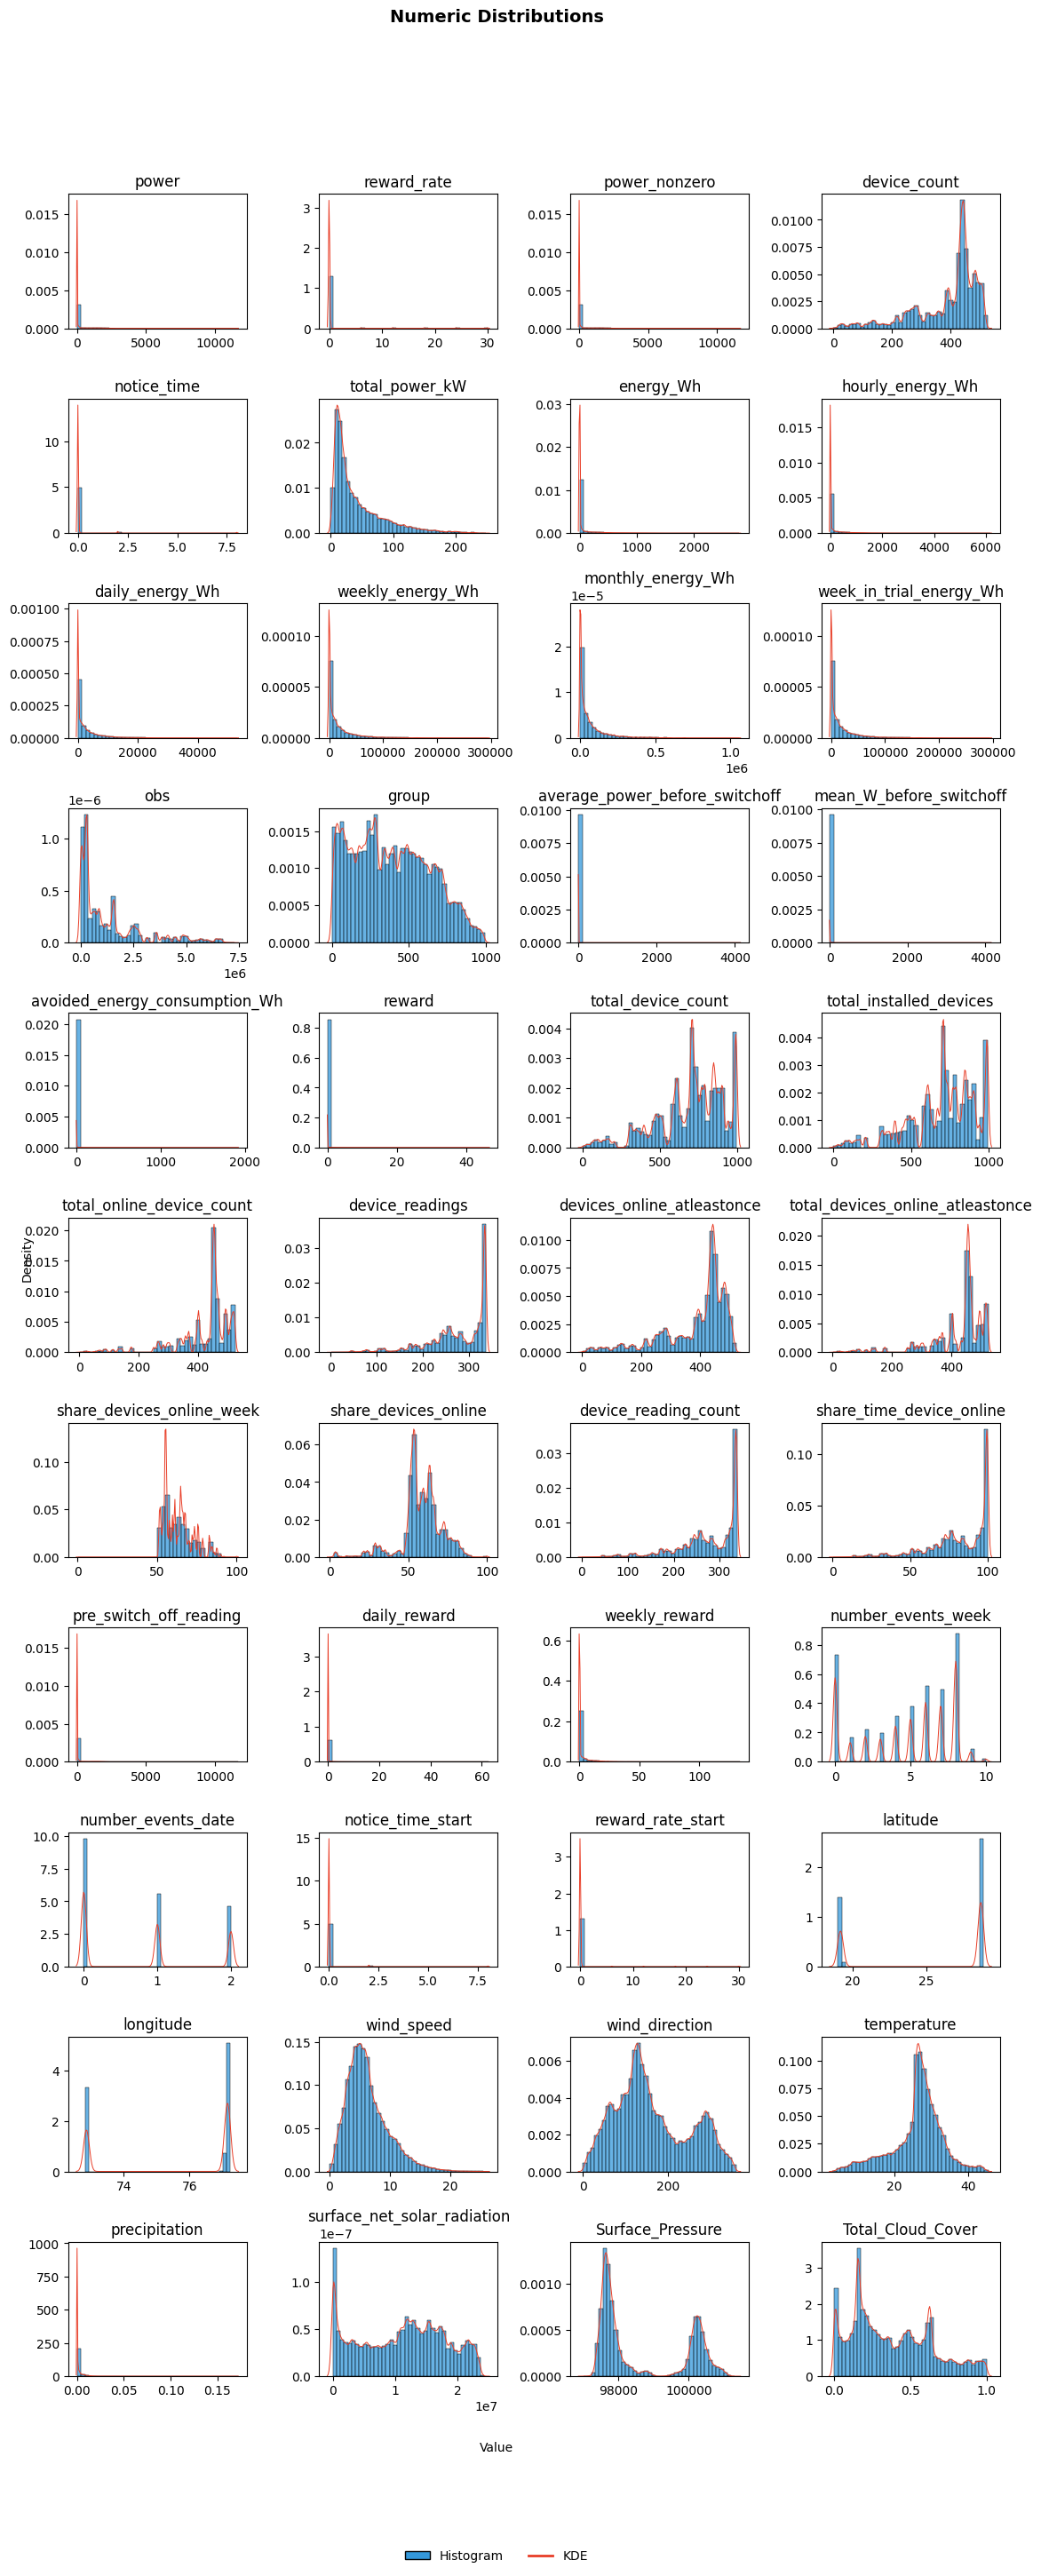

In [ ]:
# Plot the distribution of numerical features
seaborn_matrix_hist(
    smart_switch_data,
    columns = num_cols,
    bins=40,
    kde=True,
    hist_color="#3498db", # blue for bars
    kde_color="#e83d27", # red for density line
    n_cols=4,
    height=2.5
)

Also plot the correlation heatmap to see the correlation between numerical features, dropping features with high correlation with other features
- Plot the correlation matrix


In [ ]:
def plot_correlation_heatmap(corr_matrix, title="Correlation Matrix", figsize=(20, 20),
                              cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1):
    """
    Plots a masked heatmap of a correlation matrix using seaborn and matplotlib.

    Parameters:
    - corr_matrix : pd.DataFrame
        A square correlation matrix (e.g., from df.corr()).
    - title : str
        Title of the heatmap.
    - figsize : tuple
        Size of the plot (default (20, 20)).
    - cmap : str
        Color map for the heatmap (default "coolwarm").
    - annot : bool
        Whether to annotate the cells (default True).
    - fmt : str
        Format string for annotations (default ".2f").
    - vmin, vmax : float
        Minimum and maximum values for the colormap scale (default -1 to 1).
    """
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # mask upper triangle

    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_matrix,
        mask=mask,
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        annot=annot,
        fmt=fmt,
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}
    )
    plt.title(title, weight="bold")
    plt.tight_layout()
    plt.show()


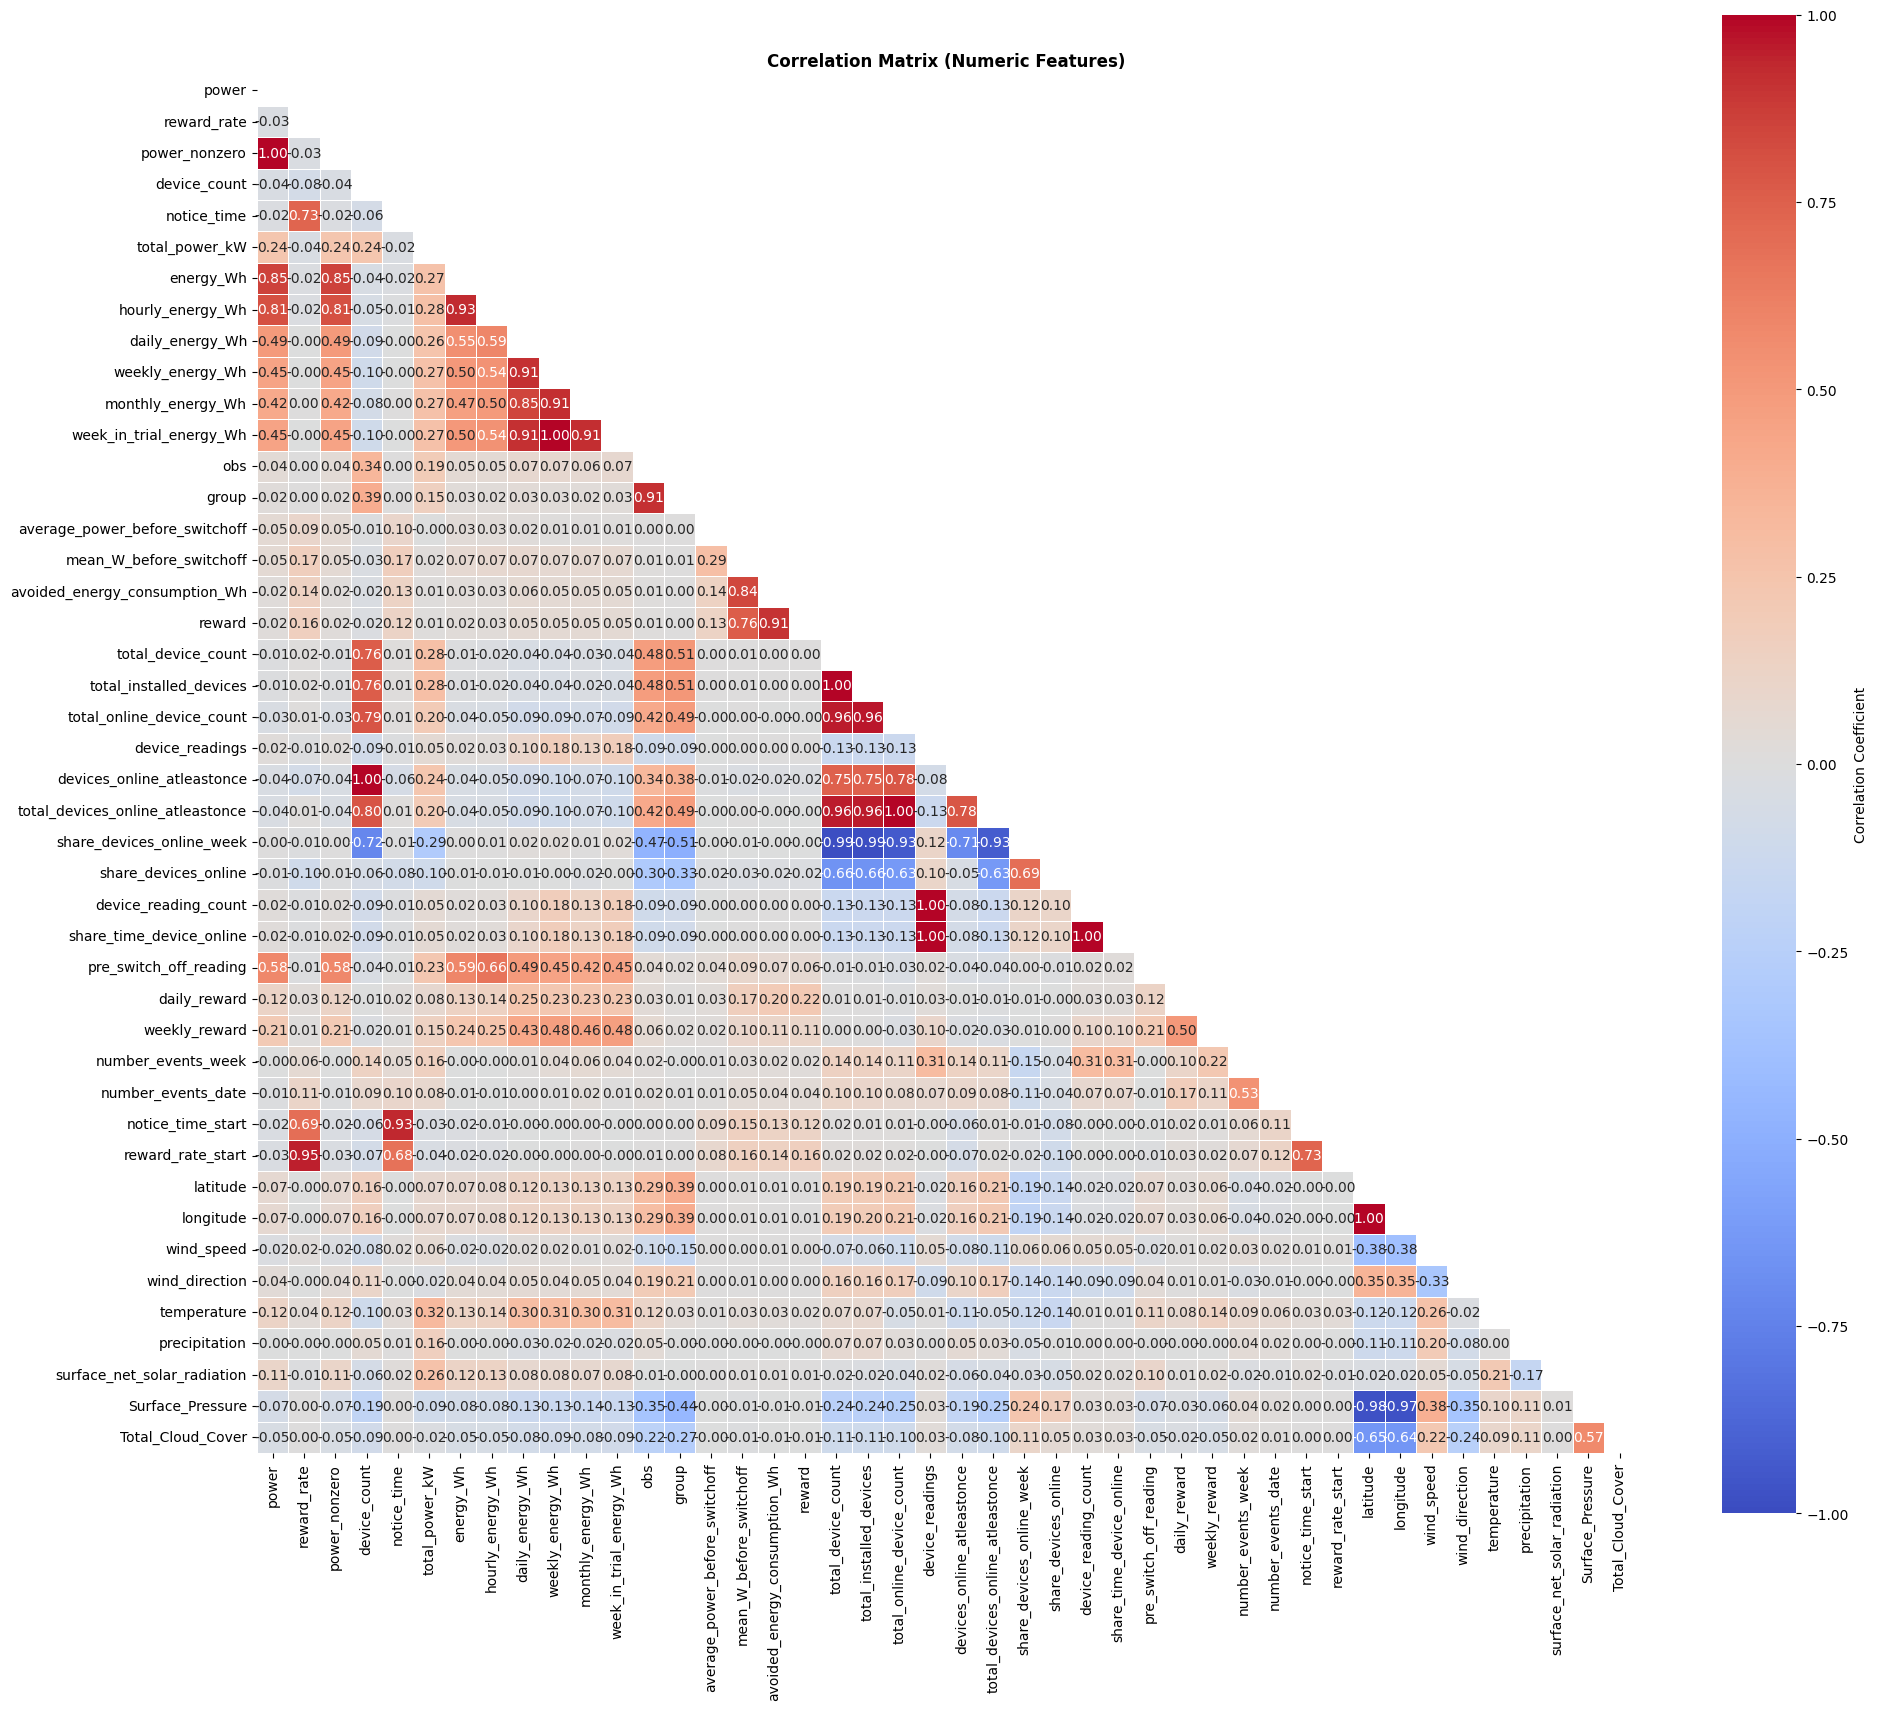

In [ ]:
# Calculate correlation matrix from your numeric columns
corr_mat = smart_switch_data[num_cols].corr(method="pearson")

# Plot using the function
plot_correlation_heatmap(corr_mat, title="Correlation Matrix (Numeric Features)")

**Feature Reduction: Highly Correlated Columns**

Drop the following features that are highly correlated with others. Keeping them can reduce model stability, inflate variance, and hurt interpretability.

---

Energy Metrics
**Features dropped:**
- `hourly_energy_Wh`
- `weekly_energy_Wh`
- `monthly_energy_Wh`
- `week_in_trial_energy_Wh`

**Reason:**  
These features are **extremely highly correlated** with each other and with `daily_energy_Wh`. They all measure energy consumption across different time windows. Retaining just one (e.g., `daily_energy_Wh`) is sufficient to capture this information.

---

Device & Activity Counts
**Features dropped:**
- `total_installed_devices`
- `total_online_device_count`
- `share_time_device_online`
- `device_reading_count`
- `share_devices_online_week`
- `total_devices_online_atleastonce`
- `notice_time_start`
- `reward_rate_start`
- `avoided_energy_consumption_Wh`

**Reason:**  
These features show near-perfect correlation with each other (dark blue boxes in the correlation matrix). They all describe similar aspects of **device usage and availability**. To reduce redundancy, retain only one or two representative features from this group.

---

Binary Power Activity
**Feature dropped:**
- `power_nonzero`

**Reason:**  
This variable is nearly perfectly correlated with the target variable (`power` or `reward_rate`). It likely acts as a proxy and **won’t provide additional predictive value**. Dropping it helps prevent data leakage or model overfitting.

---


In [ ]:
# List the highly corretated feature
drop_cols = [
    'power_nonzero',
    'avoided_energy_consumption_Wh',
    'total_installed_devices',
    'total_online_device_count',
    'device_reading_count',
    'share_time_device_online',
    'total_devices_online_atleastonce',
    'devices_online_atleastonce',
    'share_devices_online_week',
    "notice_time_start",
    "reward_rate_start",
    'latitude',
    'longitude',
    'hourly_energy_Wh',
    'weekly_energy_Wh',
    'monthly_energy_Wh',
    'week_in_trial_energy_Wh',
    'group'
]

# Drop the feature
try:
    smart_switch_data.drop(columns=drop_cols, inplace=True)
    print("Columns dropped successfully.")
except KeyError:
    print("Columns already dropped.")


Columns dropped successfully.


In [ ]:
# Build the correlation matrix after drop the highlt correlated features
num_cols = [
    "power",
    "reward_rate",
    "device_count",
    "notice_time",
    "total_power_kW",
    "energy_Wh",
    "daily_energy_Wh",
    "obs",
    "average_power_before_switchoff",
    "mean_W_before_switchoff",
    "reward",
    "total_device_count",
    "device_readings",
    "share_devices_online",
    "pre_switch_off_reading",
    "daily_reward",
    "weekly_reward",
    "number_events_week",
    "number_events_date",
    "wind_speed",
    "wind_direction",
    "temperature",
    "precipitation",
    "surface_net_solar_radiation",
    "Surface_Pressure",
    "Total_Cloud_Cover"
]

# Calculate correlation matrix from your numeric columns
corr_mat = smart_switch_data[num_cols].corr(method="pearson")

# Plot using the function
plot_correlation_heatmap(corr_mat, title="Correlation Matrix (Numeric Features) after Drop")

# Please ignore the error since I run the code in a wrong order, the plot is similar with the previous one, but no high correlated features.
# Please ignore the error since I run the code in a wrong order, the plot is similar with the previous one, but no high correlated features.
# Please ignore the error since I run the code in a wrong order, the plot is similar with the previous one, but no high correlated features.

NameError: name 'plot_correlation_heatmap' is not defined

Now, plot the numerical features after dropping the highly correlated features

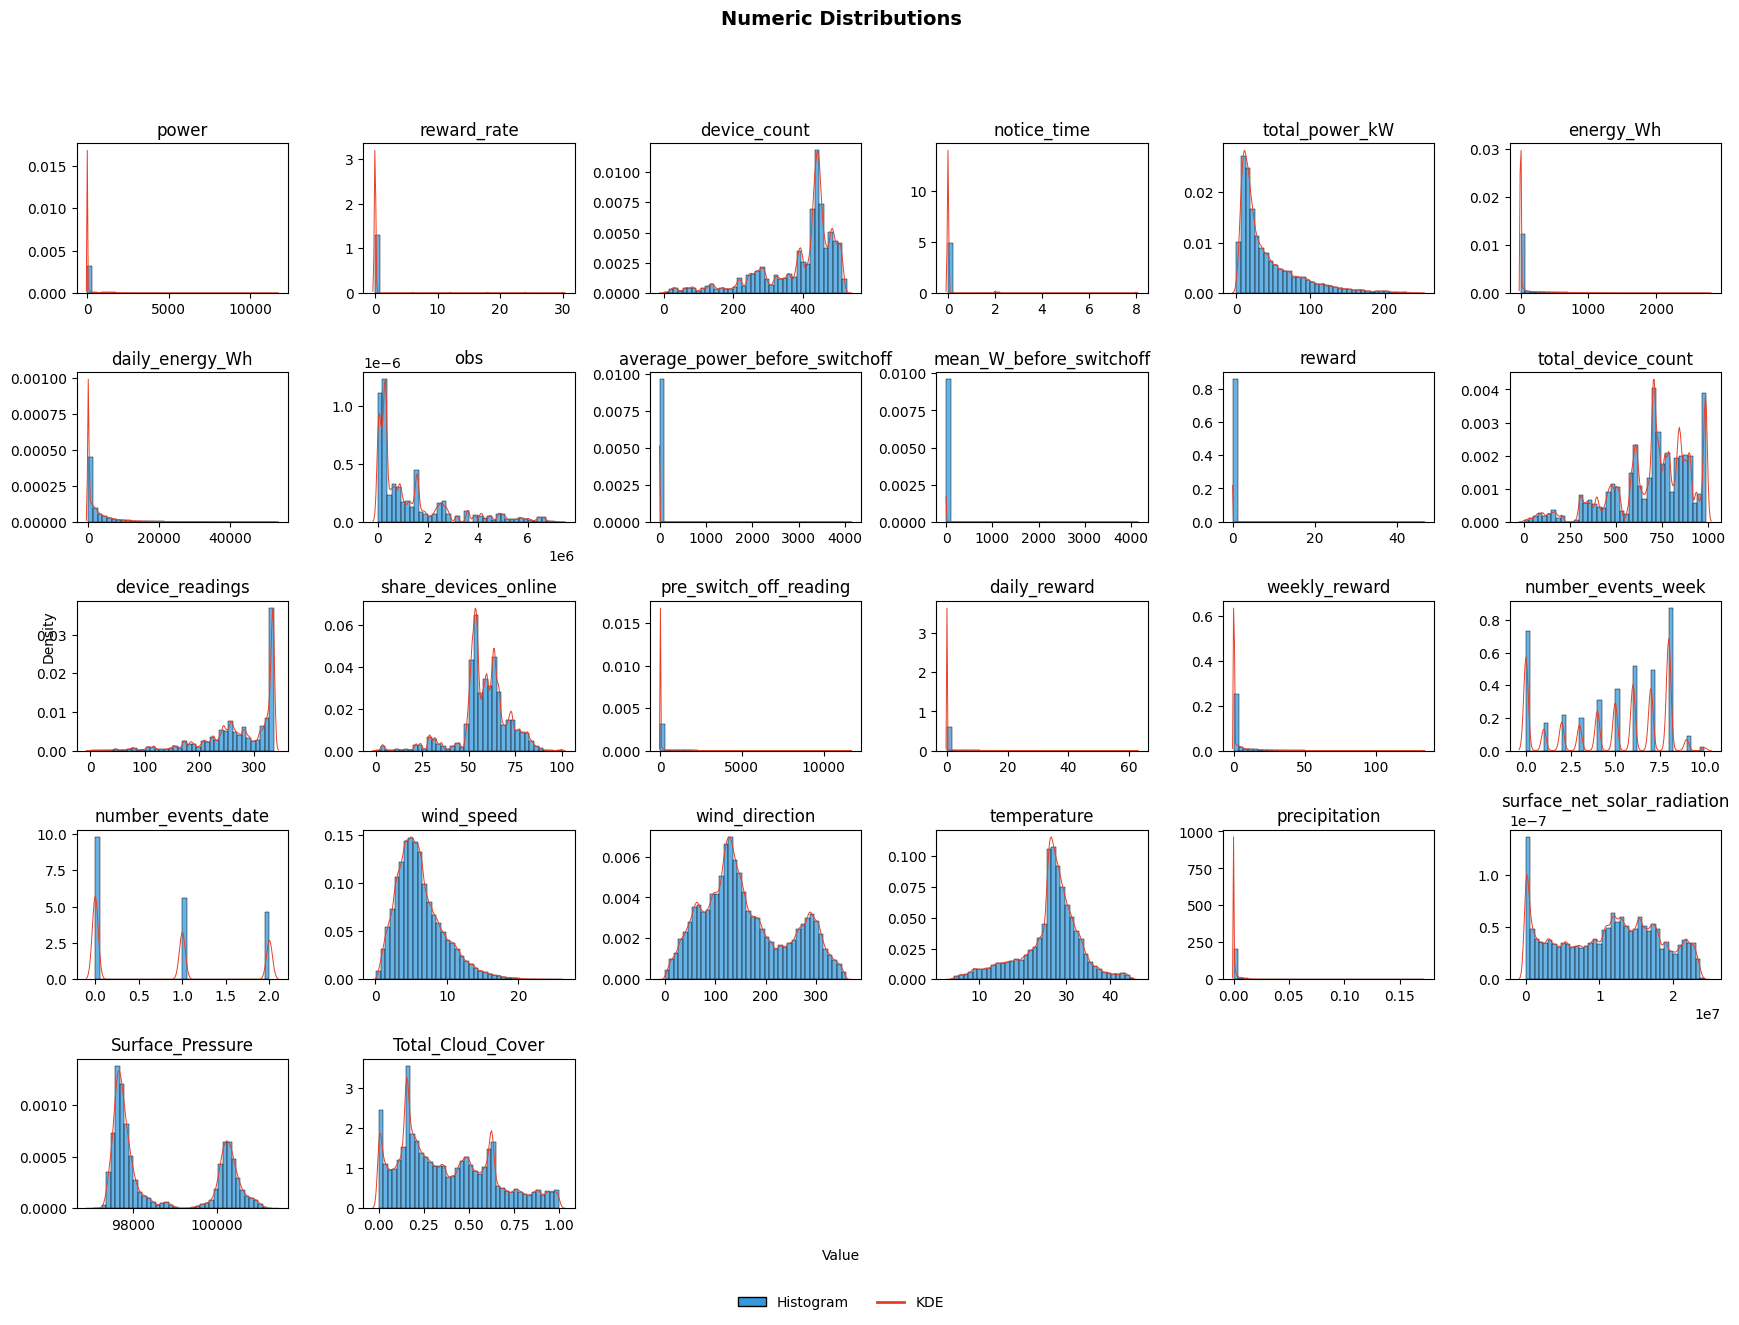

In [ ]:
num_cols = [
    "power",
    "reward_rate",
    "device_count",
    "notice_time",
    "total_power_kW",
    "energy_Wh",
    "daily_energy_Wh",
    "obs",
    "average_power_before_switchoff",
    "mean_W_before_switchoff",
    "reward",
    "total_device_count",
    "device_readings",
    "share_devices_online",
    "pre_switch_off_reading",
    "daily_reward",
    "weekly_reward",
    "number_events_week",
    "number_events_date",
    "wind_speed",
    "wind_direction",
    "temperature",
    "precipitation",
    "surface_net_solar_radiation",
    "Surface_Pressure",
    "Total_Cloud_Cover"
]
# Plot the distribution of numerical features
seaborn_matrix_hist(
    smart_switch_data,
    columns = num_cols,
    bins=40,
    kde=True,
    hist_color="#3498db", # blue for bars
    kde_color="#e83d27", # red for density line
    n_cols=6,
    height=2.5
)

### Encode time feature

Encoding temporal features from time-step format to periodic temporal features, enabling computers to better understand temporal variations in user behavior (more details in the report)

In [ ]:
def build_time_axis(df, time_col='round_datetime', drop_raw=True):
    """
    Expand a datetime column into cyclic time features using sine and cosine encoding.
    Encodes hour, day of week, month, and day of year into periodic signals.
    """
    df_copy = df.copy()
    dt_series = pd.to_datetime(df_copy[time_col])

    # Define cyclic periods for time components
    cycles = {
        'hour': 24.0,
        'day_of_week': 7.0,
        'month': 12.0,
        'day_of_year': 365
    }

    # Encode each time component as sine and cosine
    for part, period in cycles.items():
        time_part = getattr(dt_series.dt, part)
        df_copy[f'{part}_sin'] = np.sin(2 * np.pi * time_part / period)
        df_copy[f'{part}_cos'] = np.cos(2 * np.pi * time_part / period)

    # Optionally remove the raw datetime and redundant columns
    if drop_raw:
        cols_to_drop = {time_col, 'data', 'week', 'half_hour'}
        df_copy = df_copy.drop(columns=list(cols_to_drop & set(df_copy.columns)))

    return df_copy


### Encode Sequential Feature

Encoding the sequential features into statistical features to compresses the features (more details in report), which improving the efficiency in machine learning model.

In [ ]:
class AdvancedFeatureCompressor(BaseEstimator, TransformerMixin):
    """
    Transformer that compresses sequential switch, notice, and reward features
    into a smaller set of summary statistics (counts, timings, aggregates).
    """
    def __init__(self):
        # Define groups of sequential feature columns
        self.switch_l_cols_ = [f"switch_off_L{i}" for i in range(1, 7)]
        self.switch_f_cols_ = [f"switch_off_F{i}" for i in range(1, 17)]
        self.notice_f_cols_ = [f"notice_time_F{i}" for i in range(1, 17)]
        self.reward_f_cols_ = [f"reward_rate_F{i}" for i in range(1, 4)]
        self.original_cols_ = (
            self.switch_l_cols_ + self.switch_f_cols_ +
            self.notice_f_cols_ + self.reward_f_cols_
        )

    def fit(self, X, y=None):
        # Stateless transformer (no fitting needed)
        return self

    def _extract_first_event_timing(self, df, cols):
        """Return the index (1-based) of the first positive event in each row, or 0 if none exist."""
        mask = df[cols].values > 0
        return np.where(mask.any(axis=1), np.argmax(mask, axis=1) + 1, 0)

    def transform(self, X):
        """
        Create compressed features:
        - Counts of past/future switch-off events
        - Time to next / since last switch-off
        - Max notice time and timing of first notice
        - Mean and std of reward rates
        """
        X_ = X.copy()
        X_["future_switch_off_count"] = X_[self.switch_l_cols_].sum(axis=1)
        X_["past_switch_off_count"] = X_[self.switch_f_cols_].sum(axis=1)
        X_["time_to_next_switch_off"] = self._extract_first_event_timing(X_, self.switch_l_cols_)
        X_["time_since_last_switch_off"] = self._extract_first_event_timing(X_, self.switch_f_cols_)
        X_["max_future_notice"] = X_[self.notice_f_cols_].max(axis=1)
        X_["time_to_first_notice"] = self._extract_first_event_timing(X_, self.notice_f_cols_)
        X_["mean_future_reward"] = X_[self.reward_f_cols_].mean(axis=1)
        X_["std_future_reward"] = X_[self.reward_f_cols_].std(axis=1).fillna(0)

        # Drop original sequential columns after compression
        return X_.drop(columns=[col for col in self.original_cols_ if col in X_.columns])


### Pipeline

This pipeline is for preprocess the powbal dataset for the following training process, the overall workflow can be find in report

In [ ]:
# Transformer for cyclic time features
time_transformer = FunctionTransformer(
    partial(build_time_axis, time_col='round_datetime', drop_raw=False),
    validate=False
)

# Define column groups for preprocessing
override = ["override"]
id_cols = ["ca_number"]
binary_cols = ["switch_off_event", "start_event", "end_event", "actual_event"]
cat_cols = ["appliance", "preference", "city"]
cols_to_drop = [
    "surveyanswer",   # duplicate of another field
    "day",            # replaced by encoded time features
    "hour",           # replaced by encoded time features
    "minute"          # replaced by encoded time features
]
num_cols = [
    "power", "reward_rate", "device_count", "notice_time", "total_power_kW",
    "energy_Wh", "daily_energy_Wh", "obs", "average_power_before_switchoff",
    "mean_W_before_switchoff", "reward", "total_device_count",
    "device_readings", "share_devices_online", "pre_switch_off_reading",
    "daily_reward", "weekly_reward", "number_events_week", "number_events_date",
    "wind_speed", "wind_direction", "temperature", "precipitation",
    "surface_net_solar_radiation", "Surface_Pressure", "Total_Cloud_Cover"
]

# ColumnTransformer handles preprocessing:
# - drop unnecessary columns
# - keep binary columns as-is
# - scale numeric columns
# - one-hot encode categorical columns
preprocess = ColumnTransformer(
    transformers=[
        ("drop", "drop", cols_to_drop),
        ("binary", "passthrough", binary_cols),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

# Full pipeline: add time features, compress sequential features, then preprocess
pipe = Pipeline([
    ("time_features", time_transformer),
    ("compressor", AdvancedFeatureCompressor()),
    ("prep", preprocess)
])

# Run the pipeline and collect transformed data
X_array = pipe.fit_transform(smart_switch_data)
feature_names = pipe["prep"].get_feature_names_out()

# Convert result to DataFrame with feature names
clean_df = pd.DataFrame(X_array, columns=feature_names, index=smart_switch_data.index)

# Ensure 'ca_number' is the first column if present
cols = clean_df.columns.tolist()
cols = ['ca_number'] + [col for col in cols if col != 'ca_number']
clean_df = clean_df[cols]

print("Pipeline complete.")
print("Final shape:", clean_df.shape)

# Save processed dataset to disk
save_path = '/content/drive/MyDrive/Colab_Notebooks/IRP/smart_switch_data_cleaned.csv'
clean_df.to_csv(save_path, index=False)


/tmp/ipython-input-892258421.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_series = pd.to_datetime(df_copy[time_col])


Pipeline complete.
Final shape: (7391239, 71)


check the preprocess result

In [ ]:
# display first 10 rows interactively
display(
    clean_df.head(10)
    .style
    .set_sticky()
    .set_table_attributes("style='width:70%; font-size:12px'")
    .set_table_styles(
        [{
            'selector': 'th',
            'props': [('font-size', '12px'), ('padding', '4px')]
        },
         {
            'selector': 'td',
            'props': [('font-size', '12px'), ('padding', '4px')]
        }]
    )
)

Giving a overall of pipeline

In [ ]:
# Print the pipeline
pipe

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('time_features',
                 FunctionTransformer(func=functools.partial(<function build_time_axis at 0x7feeb4c749a0>, time_col='round_datetime', drop_raw=True))),
                ('compressor', AdvancedFeatureCompressor()),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['surveyanswer', 'day',
                                                   'hour', 'minute']),
                                                 ('binary', 'passthrough',
                                                  ['s...
                                                   'share_devices_online',
                                                   'pre_switch_off_reading',
                                                   'daily_reward',
                                                   'weekly_reward',
                                                   'number_events_week',
                                                   'number_events_date',
                                                   'wind_speed',
                                                   'wind_direction',
                                                   'temperature',
                                                   'precipitation',
                                                   'surface_net_solar_radiation',
                                                   'Surface_Pressure',
                                                   'Total_Cloud_Cover']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['appliance', 'preference',
                                                   'city'])],
                                   verbose_feature_names_out=False))])

### Load the preprocessed data for PCA clustering (feature summary)

In [ ]:
# Load the preprocessed data (see Pipeline)
smart_switch_data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/IRP/smart_switch_data_cleaned.csv')


In [ ]:
# Print the dataset feature list
print(smart_switch_data.columns.tolist())

['ca_number', 'switch_off_event', 'start_event', 'end_event', 'actual_event', 'power', 'reward_rate', 'device_count', 'notice_time', 'total_power_kW', 'energy_Wh', 'daily_energy_Wh', 'obs', 'average_power_before_switchoff', 'mean_W_before_switchoff', 'reward', 'total_device_count', 'device_readings', 'share_devices_online', 'pre_switch_off_reading', 'daily_reward', 'weekly_reward', 'number_events_week', 'number_events_date', 'wind_speed', 'wind_direction', 'temperature', 'precipitation', 'surface_net_solar_radiation', 'Surface_Pressure', 'Total_Cloud_Cover', 'appliance_AC', 'appliance_Air Cooler', 'appliance_Car Charging socket', 'appliance_Clothes Dryer', 'appliance_Electric Geyser', 'appliance_Electric Heater', 'appliance_Fan', 'appliance_Light / Bulb', 'appliance_Microwave / Oven ', 'appliance_Refrigerator', 'appliance_T.V.', 'appliance_Washing Machine', 'appliance_Water Motor', 'appliance_Water Purifier / R.O.', "preference_Don't Know / No Preference", 'preference_Remain Off', 'pre

### Feature Classification Summary


Identifier
- `ca_number`  
*Unique customer ID — keep for reference or merging, drop before modeling.*

---

Target Variable
- `override`  
*Binary target (1 = user overrode the switch-off event, 0 = did not override).*

---

Binary Flags
*Event status indicators (0 or 1):*
- `switch_off_event`
- `start_event`
- `end_event`
- `actual_event`

---

Numeric Features
*Continuous or discrete features representing power, counts, and trial information:*
- `power`
- `reward_rate`
- `device_count`
- `notice_time`
- `total_power_kW`
- `energy_Wh`
- `daily_energy_Wh`
- `obs`
- `average_power_before_switchoff`
- `mean_W_before_switchoff`
- `reward`
- `total_device_count`
- `device_readings`
- `share_devices_online`
- `pre_switch_off_reading`
- `daily_reward`
- `weekly_reward`
- `number_events_week`
- `number_events_date`
- `week_in_trial`
- `period_duration`

---

Weather Features
*Environmental context for user behavior:*
- `wind_speed`
- `wind_direction`
- `temperature`
- `precipitation`
- `surface_net_solar_radiation`
- `Surface_Pressure`
- `Total_Cloud_Cover`

---
Categorical Features (One-Hot Encoded)

appliance Type
- `appliance_AC`
- `appliance_Air Cooler`
- `appliance_Car Charging socket`
- `appliance_Clothes Dryer`
- `appliance_Electric Geyser`
- `appliance_Electric Heater`
- `appliance_Fan`
- `appliance_Light / Bulb`
- `appliance_Microwave / Oven `
- `appliance_Refrigerator`
- `appliance_T.V.`
- `appliance_Washing Machine`
- `appliance_Water Motor`
- `appliance_Water Purifier / R.O.`

User Preference
- `preference_Don't Know / No Preference`
- `preference_Remain Off`
- `preference_Turn On`

City
- `city_delhi`
- `city_mumbai`

---
Cyclical Time Features
*Encoded from timestamp to capture periodicity:*
- `hour_sin`, `hour_cos`
- `day_of_week_sin`, `day_of_week_cos`
- `month_sin`, `month_cos`
- `day_of_year_sin`, `day_of_year_cos`

---

Compressed Sequential Features
*Aggregated from historical (F) and future (L) sequential behavior:*
- `future_switch_off_count`
- `past_switch_off_count`
- `time_to_next_switch_off`
- `time_since_last_switch_off`
- `max_future_notice`
- `time_to_first_notice`
- `mean_future_reward`
- `std_future_reward`


### PCA for Customer Clustering
#### Strategy 1: PCA cluster for Customer Clustering & Profiling
This approach is focused on exploratory analysis. The goal is to discover natural, meaningful groups of customers based on their complete, holistic behavior.

#### Strategy 2: PCA cluster for Override Prediction
This approach is a supervised learning task. The goal is to build the best possible model to predict a future override event, and the rules are much stricter.

1) Aggregate to customer level
- Group by `ca_number`.
- Compute means (and stds for numerics) for:
  - Binary flags: `switch_off_event` (+ `start_event`/`end_event`/`actual_event` ONLY in the all-features view).
  - Numerics: power/usage/reward/device/engagement counters, etc.
  - One-hots: `appliance_*`, `preference_*`, `city_*` (become per-user shares).
  - Weather (realized): include ONLY in the all-features view.
- Add `n_events` (row count per user).

2) Time-of-use (circular) features
- From event-level `hour_sin`/`hour_cos` and `day_of_week_sin`/`day_of_week_cos`:
  - Create `typical_hour`, `hour_concentration`, `typical_dow`, `dow_concentration`.
- Keep sin/cos means, but DROP their std (cleaner than raw cyc stds).

3) Weather sensitivity (descriptive only)
- Per-user Spearman correlations:
  - `temp_power_corr`, `solar_power_corr`, `wind_power_corr`.
- Use in all-features view (or compute past-only if ever needed in leak-safe).

4) Build two feature views
- All-features (descriptive):
  - Includes realized event signals (e.g., pre-switch-off power, reward), realized weather,
    circular summaries, appliance/preference/city shares, counts.
- Leak-safe (for modeling):
  - Excludes realized post-notice signals (e.g., pre-switch-off power, reward),
    excludes realized weather, excludes any `future_*` engineered features and target.
  - Keeps circular summaries, sin/cos means only, usage/engagement numerics, shares.

5) Impute & scale (per view)
- Median imputation → `StandardScaler` on the customer feature matrix.

6) PCA (auto-select components)
- All-features: set variance target to 99% (richer description).
- Leak-safe: set variance target to 95% (compact representation).
- Print/plot explained variance and cumulative; show top 10 PCs in table.

7) Clustering in PCA space
- Run K-Means for k ∈ {2,…,8}; choose k with best silhouette on the PCA embedding.
- Diagnostics:
  - PCA explained-variance plot + top-10 table.
  - Cluster profile heatmap (z-scored means of top separating features).
  - ARI(all vs safe) to quantify agreement between the two segmentations.

8) Outputs & merge
- Per-user labels:
  - `cust_seg_all`  → descriptive only (DON’T feed into the override model).
  - `cust_seg_safe` → leak-safe segment (OK to use in the override model).
- Merge back to events by `ca_number`:
  - Always merge `cust_seg_safe`.
  - Optionally also merge circular summaries (`typical_*`, `*_concentration`) if desired.

9) Usage guidance
- For override prediction: use leak-safe features + `cust_seg_safe`.
- For insight & targeting: profile with all-features clusters, loadings, heatmaps.


In [ ]:
RANDOM_STATE = 42
K_RANGE = range(2, 9)

# Aggregate row-level events to user-level (means, stds, event counts)
def aggregate_user_features(df,
                            binary_flags,
                            numerical_features,
                            weather_features,
                            onehot_prefixes=('appliance_', 'preference_', 'city_')):
    """Aggregate row-level events to customer-level with means/stds."""
    df = df.copy()
    # detect one-hot encoded columns by prefix
    onehot_cols = [c for c in df.columns if any(c.startswith(p) for p in onehot_prefixes)]
    agg_dict = {c: 'mean' for c in (binary_flags + onehot_cols)}
    for c in numerical_features + weather_features:
        if c in df.columns:
            agg_dict[c] = ['mean', 'std']
    g = df.groupby('ca_number', sort=False)
    user = g.agg(agg_dict)
    user.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in user.columns]
    user['n_events'] = g.size()
    return user.reset_index(), onehot_cols

# Select aggregated columns based on base names and suffixes
def pick_cols(user_features, base_names, add_stats=True):
    """Map base names to aggregated columns present in user_features."""
    out, seen = [], set()
    for b in base_names:
        if add_stats:
            for c in (f"{b}_mean", f"{b}_std"):
                if c in user_features.columns and c not in seen:
                    out.append(c); seen.add(c)
            if b in user_features.columns and b not in seen:  # fallback
                out.append(b); seen.add(b)
        else:
            if b in user_features.columns and b not in seen:
                out.append(b); seen.add(b)
    return out

# Compute circular summaries of time-of-use (hour, day-of-week)
def add_time_of_use_features(user_df: pd.DataFrame, events_df: pd.DataFrame) -> pd.DataFrame:
    g = events_df.groupby('ca_number', sort=False)
    feats = []

    if {'hour_sin','hour_cos'}.issubset(events_df.columns):
        hs, hc = g['hour_sin'].mean(), g['hour_cos'].mean()
        typical_hour = (np.degrees(np.arctan2(hs, hc)) % 360.0) / 360.0 * 24.0
        hour_conc    = np.hypot(hc, hs)
        feats.append(pd.DataFrame({'typical_hour': typical_hour, 'hour_concentration': hour_conc}))

    if {'day_of_week_sin','day_of_week_cos'}.issubset(events_df.columns):
        dws, dwc = g['day_of_week_sin'].mean(), g['day_of_week_cos'].mean()
        typical_dow = (np.degrees(np.arctan2(dws, dwc)) % 360.0) / 360.0 * 7.0
        dow_conc    = np.hypot(dwc, dws)
        feats.append(pd.DataFrame({'typical_dow': typical_dow, 'dow_concentration': dow_conc}))

    if not feats:
        return user_df
    feats = pd.concat(feats, axis=1)
    feats.index.name = 'ca_number'
    return user_df.merge(feats.reset_index(), on='ca_number', how='left')

# Safe correlation helper with sample size check
def _safe_corr(x: pd.Series, y: pd.Series, min_n: int = 20, method: str = 'spearman'):
    z = pd.concat([x, y], axis=1).dropna()
    if len(z) < min_n or z.iloc[:,0].std() == 0 or z.iloc[:,1].std() == 0:
        return np.nan
    return float(z.iloc[:,0].corr(z.iloc[:,1], method=method))

# Compute user-level sensitivity of power to weather (temp, solar, wind)
def add_weather_sensitivity(user_df: pd.DataFrame,
                            events_df: pd.DataFrame,
                            time_mask: pd.Series | None = None,
                            min_n: int = 20) -> pd.DataFrame:
    df = events_df.loc[time_mask] if time_mask is not None else events_df
    g  = df.groupby('ca_number', sort=False)
    cols = {}
    if {'power','temperature'}.issubset(df.columns):
        cols['temp_power_corr']  = g.apply(lambda d: _safe_corr(d['power'], d['temperature'], min_n))
    if {'power','surface_net_solar_radiation'}.issubset(df.columns):
        cols['solar_power_corr'] = g.apply(lambda d: _safe_corr(d['power'], d['surface_net_solar_radiation'], min_n))
    if {'power','wind_speed'}.issubset(df.columns):
        cols['wind_power_corr']  = g.apply(lambda d: _safe_corr(d['power'], d['wind_speed'], min_n))
    if not cols:
        return user_df
    sens = pd.DataFrame(cols)
    sens.index.name = 'ca_number'
    return user_df.merge(sens.reset_index(), on='ca_number', how='left')

# Drop std columns for cyclic encodings (keep sin/cos means only)
def drop_cycle_std_cols(df_users: pd.DataFrame) -> pd.DataFrame:
    cycle_keys = ['hour_sin','hour_cos','day_of_week_sin','day_of_week_cos',
                  'month_sin','month_cos','day_of_year_sin','day_of_year_cos']
    to_drop = [c for c in df_users.columns
               if c.endswith('_std') and any(key in c for key in cycle_keys)]
    return df_users.drop(columns=to_drop, errors='ignore')

# Prepare feature matrix with imputation and scaling
def prepare_matrix(df_users, cols):
    X = df_users[cols].copy()
    X = SimpleImputer(strategy='median').fit_transform(X)
    X = StandardScaler().fit_transform(X)
    return X

# PCA with KMeans clustering, pick k by silhouette score
def run_pca_kmeans(X, var_target=0.95, k_range=K_RANGE, random_state=RANDOM_STATE):
    """float var_target -> svd_solver='full'; int -> 'randomized'."""
    nmax = min(X.shape[0], X.shape[1])
    if isinstance(var_target, float):
        var_target = float(np.clip(var_target, 1e-6, 0.999999))
        pca = PCA(n_components=var_target, svd_solver='full', random_state=random_state)
    else:
        n_comp = int(np.clip(var_target, 1, nmax))
        pca = PCA(n_components=n_comp, svd_solver='randomized', random_state=random_state)
    X_pca = pca.fit_transform(X)

    best_k, best_s, best_labels = None, -1.0, None
    for k in k_range:
        labels = KMeans(n_init=10, n_clusters=k, random_state=random_state).fit_predict(X_pca)
        s = silhouette_score(X_pca, labels)
        if s > best_s:
            best_k, best_s, best_labels = k, s, labels
    return pca, X_pca, best_k, best_s, best_labels

# Inspect top loading features for a given principal component
def top_loadings(pca, cols, pc=0, top=12):
    s = pd.Series(pca.components_[pc], index=cols)
    return s.reindex(cols).abs().sort_values(ascending=False).head(top)

# Plot explained variance ratios and display variance table
def pca_variance_table_and_plot(pca, title="PCA explained variance", top_n=10):
    evr = pd.Series(pca.explained_variance_ratio_, name="explained_var_ratio")
    cev = evr.cumsum().rename("cumulative_var_ratio")
    eig = pd.Series(pca.explained_variance_, name="eigenvalue")
    tbl_full = pd.DataFrame({"PC": np.arange(1, len(evr)+1),
                             "eigenvalue": eig,
                             "explained_var_ratio": evr,
                             "cumulative_var_ratio": cev})
    plt.figure(figsize=(8,4))
    plt.bar(tbl_full["PC"], tbl_full["explained_var_ratio"], alpha=0.6, label="Per-PC variance")
    plt.plot(tbl_full["PC"], tbl_full["cumulative_var_ratio"], marker="o", label="Cumulative variance")
    plt.axhline(0.95, ls="--", label="95% cumulative")
    plt.axhline(0.99, ls="--", label="99% cumulative")
    plt.title(title); plt.xlabel("Principal component"); plt.ylabel("Variance ratio")
    plt.legend(); plt.tight_layout(); plt.show()
    tbl_head = tbl_full.head(top_n)
    display(tbl_head)
    return tbl_head

# Plot heatmap of cluster profiles (z-scored feature means)
def cluster_profile_heatmap(user_df, feature_cols, cluster_labels, top_k=20, title="Cluster profile (z-scored means)"):
    X = user_df[feature_cols].copy()
    X = SimpleImputer(strategy="median").fit_transform(X)
    X = StandardScaler().fit_transform(X)
    tmp = pd.DataFrame(X, columns=feature_cols)
    tmp["cluster"] = np.asarray(cluster_labels)
    means = tmp.groupby("cluster")[feature_cols].mean()
    z_means = (means - means.mean(axis=0)) / (means.std(axis=0) + 1e-12)
    feat_order = z_means.var(axis=0).sort_values(ascending=False).head(min(top_k, z_means.shape[1])).index.tolist()
    z_show = z_means[feat_order]
    plt.figure(figsize=(max(8, 0.4*len(feat_order)), 0.6*z_show.shape[0] + 3))
    plt.imshow(z_show.values, aspect="auto"); plt.colorbar(label="z-scored cluster mean")
    plt.yticks(range(len(z_show.index)), [f"Cluster {c}" for c in z_show.index])
    plt.xticks(range(len(feat_order)), feat_order, rotation=70, ha="right")
    plt.title(title); plt.tight_layout(); plt.show()
    return z_show

# PCA + DBSCAN clustering with grid search over eps/min_samples
def run_pca_dbscan(
    X,
    var_target=0.99,
    eps_list=None,
    min_samples_list=None,
    standardize=True,
    random_state=42
):
    """
    Returns:
      pca, Xp (PCA coords),
      best_params (dict),
      best_sil (float, silhouette on non-noise),
      best_labels (np.array),
      best_noise_ratio (float),
      n_clusters (int, excludes noise)
    """
    if eps_list is None:
        eps_list = np.linspace(0.5, 2.0, 7)
    if min_samples_list is None:
        min_samples_list = [5, 10, 15, 20]

    # Standardize if required
    Xs = StandardScaler().fit_transform(X) if standardize else X

    # PCA to reach target variance
    pca_full = PCA().fit(Xs)
    cum = np.cumsum(pca_full.explained_variance_ratio_)
    n_comp = int(np.searchsorted(cum, var_target) + 1)
    pca = PCA(n_components=n_comp).fit(Xs)
    Xp = pca.transform(Xs)

    # Grid search across eps/min_samples, score by silhouette (non-noise)
    best = {
        "sil": -1.0,
        "labels": None,
        "eps": None,
        "min_samples": None,
        "noise_ratio": 1.0,
        "n_clusters": 0
    }

    for eps in eps_list:
        for ms in min_samples_list:
            lab = DBSCAN(eps=eps, min_samples=ms).fit_predict(Xp)
            uniq = sorted(set(lab) - {-1})
            n_clusters = len(uniq)
            if n_clusters < 2:
                continue

            mask = lab != -1
            if mask.sum() < 2:
                continue

            sil = silhouette_score(Xp[mask], lab[mask])
            noise_ratio = 1.0 - mask.mean()

            better = (
                sil > best["sil"]
                or (np.isclose(sil, best["sil"]) and noise_ratio < best["noise_ratio"])
            )
            if better:
                best.update({
                    "sil": sil,
                    "labels": lab,
                    "eps": eps,
                    "min_samples": ms,
                    "noise_ratio": noise_ratio,
                    "n_clusters": n_clusters
                })

    return pca, Xp, {"eps": best["eps"], "min_samples": best["min_samples"]}, best["sil"], best["labels"], best["noise_ratio"], best["n_clusters"]


Part 1 — “All-features” PCA segmentation with Kmeans (descriptive)

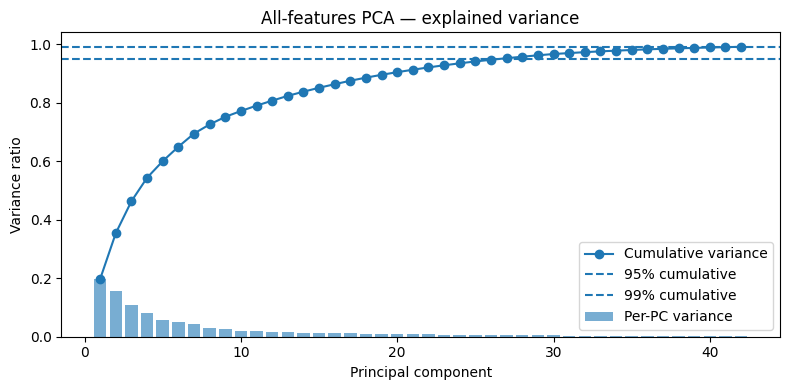

PC  eigenvalue  explained_var_ratio  cumulative_var_ratio
0   1   14.060565             0.197836              0.197836
1   2   11.118040             0.156434              0.354271
2   3    7.753218             0.109090              0.463361
3   4    5.696579             0.080153              0.543514
4   5    4.022840             0.056603              0.600116
5   6    3.500531             0.049254              0.649370
6   7    3.196773             0.044980              0.694349
7   8    2.220050             0.031237              0.725586
8   9    1.844916             0.025959              0.751545
9  10    1.416982             0.019937              0.771482

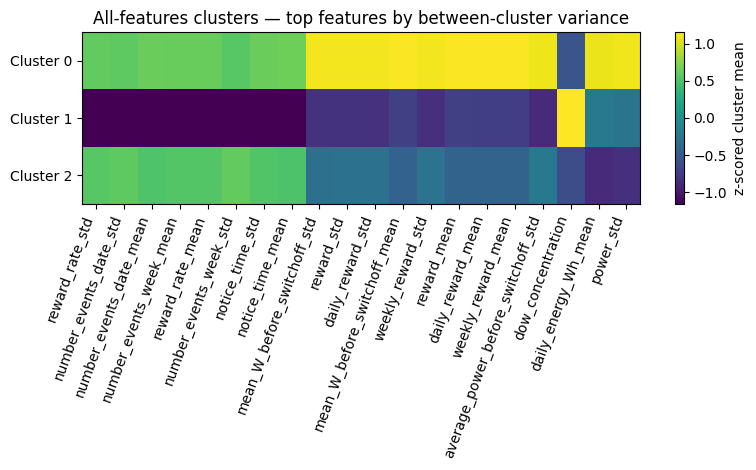

[All-features/KMeans] PCs=42, k=3, silhouette=0.201
Cluster sizes:
 0    212
1    147
2    633
Name: count, dtype: int64


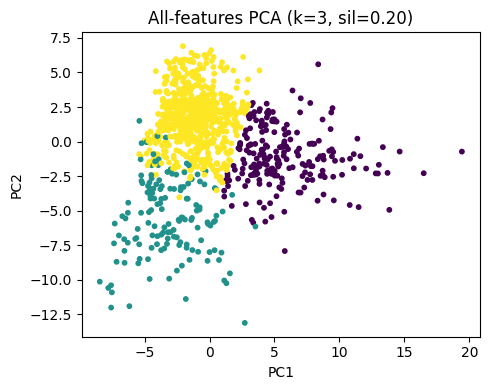


Top loadings (All, PC1):
mean_W_before_switchoff_std     0.239285
mean_W_before_switchoff_mean    0.237024
reward_std                      0.233236
daily_reward_std                0.230062
reward_mean                     0.228492
daily_reward_mean               0.227226
weekly_reward_mean              0.225735
weekly_reward_std               0.218548
power_std                       0.200655
pre_switch_off_reading_std      0.200375
daily_energy_Wh_mean            0.199424
energy_Wh_std                   0.197675
dtype: float64


In [ ]:
# Define feature groups
binary_flags_all = ['switch_off_event','start_event','end_event','actual_event']

numerical_all = [
    'power','reward_rate','device_count','notice_time',
    'total_power_kW','energy_Wh','daily_energy_Wh','obs',
    'average_power_before_switchoff','mean_W_before_switchoff','reward',
    'total_device_count','device_readings','share_devices_online','pre_switch_off_reading',
    'daily_reward','weekly_reward','number_events_week','number_events_date',
    'week_in_trial','period_duration',
    # include cyclical encodings (std values will be dropped later)
    'hour_sin','hour_cos','day_of_week_sin','day_of_week_cos',
    'month_sin','month_cos','day_of_year_sin','day_of_year_cos'
]

weather_all = [
    'wind_speed','wind_direction','temperature','precipitation',
    'surface_net_solar_radiation','Surface_Pressure','Total_Cloud_Cover'
]

# Aggregate event-level features to customer-level
user_all, onehot_cols_all = aggregate_user_features(
    smart_switch_data,
    binary_flags=binary_flags_all,
    numerical_features=numerical_all,
    weather_features=weather_all,
    onehot_prefixes=('appliance_', 'preference_', 'city_')
)

# Drop std columns for cyclical encodings (keep only sin/cos means)
user_all = drop_cycle_std_cols(user_all)

# Add time-of-use circular summaries and weather sensitivity correlations
user_all = add_time_of_use_features(user_all, smart_switch_data)
user_all = add_weather_sensitivity(user_all, smart_switch_data)

# Build the final feature list for clustering
all_cols = (
    pick_cols(user_all, binary_flags_all, add_stats=False) +
    pick_cols(user_all, numerical_all,   add_stats=True) +
    pick_cols(user_all, weather_all,     add_stats=True) +
    pick_cols(user_all, onehot_cols_all, add_stats=False) +
    ['n_events']
)
extra_all = [c for c in [
    'typical_hour','hour_concentration','typical_dow','dow_concentration',
    'temp_power_corr','solar_power_corr','wind_power_corr'
] if c in user_all.columns]
all_cols = list(dict.fromkeys([*all_cols, *extra_all]))
all_cols = [c for c in all_cols if c in user_all.columns]

# Run PCA + KMeans on aggregated feature matrix
X_all  = prepare_matrix(user_all, all_cols)
pca_a, Xp_a, k_a, sil_a, lab_a = run_pca_kmeans(X_all, var_target=0.99)  # 99% variance for descriptive analysis

# Plot explained variance and show top-10 table
_ = pca_variance_table_and_plot(pca_a, title="All-features PCA — explained variance", top_n=10)

# Plot heatmap of cluster profiles (top features by between-cluster variance)
z_all = cluster_profile_heatmap(
    user_df=user_all,
    feature_cols=all_cols,
    cluster_labels=lab_a,
    top_k=20,
    title="All-features clusters — top features by between-cluster variance"
)

# Save customer segmentation labels
user_segments_all = user_all[['ca_number']].copy()
user_segments_all['cust_seg_all'] = lab_a

print(f"[All-features/KMeans] PCs={pca_a.n_components_}, k={k_a}, silhouette={sil_a:.3f}")
print("Cluster sizes:\n", pd.Series(lab_a).value_counts().sort_index())

# 2D scatter plot of PCA results with cluster labels
if Xp_a.shape[1] >= 2:
    plt.figure(figsize=(5,4))
    plt.scatter(Xp_a[:,0], Xp_a[:,1], c=lab_a, s=10)
    plt.title(f"All-features PCA (k={k_a}, sil={sil_a:.2f})")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

# Display top loadings for PC1
print("\nTop loadings (All, PC1):")
print(top_loadings(pca_a, all_cols, pc=0, top=12))


Part 1 — “All-features” PCA segmentation with DBSCAN (descriptive)

[All-features/DBSCAN] PCs=42, clusters=3, sil(non-noise)=0.525, eps=2.0, min_samples=5, noise_ratio=97.88%
Label counts (DBSCAN):
 -1    971
 0      6
 1     10
 2      5
Name: count, dtype: int64


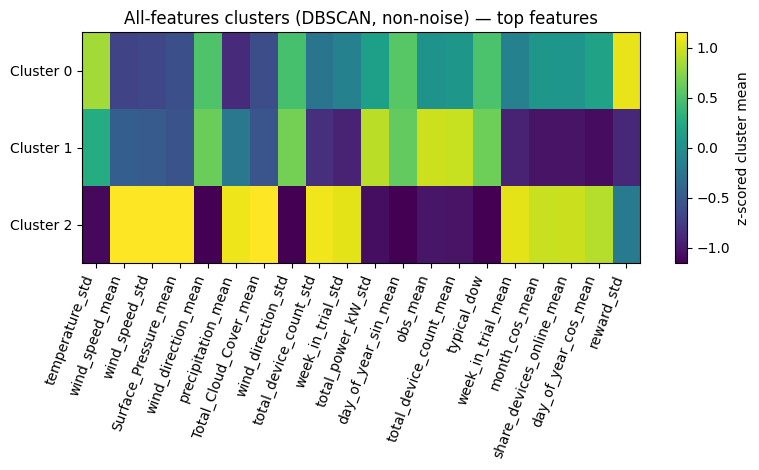

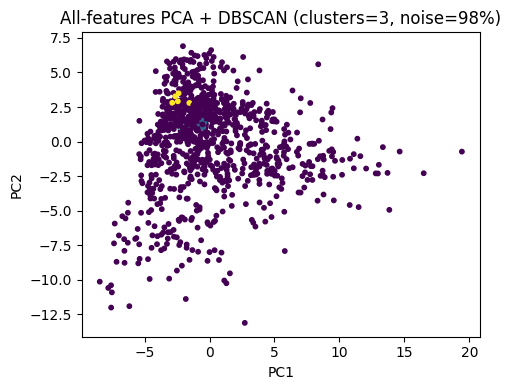

ARI vs KMeans on non-noise users: 0.000


In [ ]:
# Run PCA + DBSCAN clustering on the same user feature matrix
pca_d, Xp_d, db_params, sil_d, lab_d, noise_ratio_d, nclu_d = run_pca_dbscan(
    X_all,
    var_target=0.99,
    eps_list=np.linspace(0.5, 2.0, 7),   # search grid for neighborhood radius
    min_samples_list=[5, 10, 15, 20],    # search grid for minimum points per cluster
    standardize=True
)

# Report DBSCAN clustering results
print(f"[All-features/DBSCAN] PCs={pca_d.n_components_}, clusters={nclu_d}, "
      f"sil(non-noise)={sil_d if sil_d>=0 else float('nan'):.3f}, "
      f"eps={db_params['eps']}, min_samples={db_params['min_samples']}, "
      f"noise_ratio={noise_ratio_d:.2%}")

# Show distribution of cluster labels (including noise = -1)
print("Label counts (DBSCAN):\n", pd.Series(lab_d).value_counts().sort_index())

# Heatmap of cluster profiles (restricted to non-noise users)
mask_nn = (lab_d != -1)
if mask_nn.sum() > 0 and len(set(lab_d[mask_nn])) > 1:
    z_all_db = cluster_profile_heatmap(
        user_df=user_all.loc[mask_nn].copy(),
        feature_cols=all_cols,
        cluster_labels=lab_d[mask_nn],
        top_k=20,
        title="All-features clusters (DBSCAN, non-noise) — top features"
    )

# Save DBSCAN labels, keeping noise as -1 for reference
user_segments_all_db = user_all[['ca_number']].copy()
user_segments_all_db['cust_seg_all_dbscan'] = lab_d

# 2D scatter plot of PCA-transformed data with DBSCAN cluster labels
if Xp_d.shape[1] >= 2:
    plt.figure(figsize=(5,4))
    plt.scatter(Xp_d[:,0], Xp_d[:,1], c=lab_d, s=10)
    plt.title(f"All-features PCA + DBSCAN (clusters={nclu_d}, noise={noise_ratio_d:.0%})")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

# Optional: compare DBSCAN labels to KMeans on overlapping non-noise users
try:
    from sklearn.metrics import adjusted_rand_score
    if lab_a is not None:
        common_mask = (lab_d != -1)
        if common_mask.sum() > 0:
            ari = adjusted_rand_score(lab_a[common_mask], lab_d[common_mask])
            print(f"ARI vs KMeans on non-noise users: {ari:.3f}")
except Exception as e:
    print("ARI comparison skipped:", e)


Part 2 — “Leak-safe” PCA segmentation Kmeans (use in override model)

Since PCA of K-means performance is better than DBSCAN, the clustering results will be merged into smart switch data (see report)

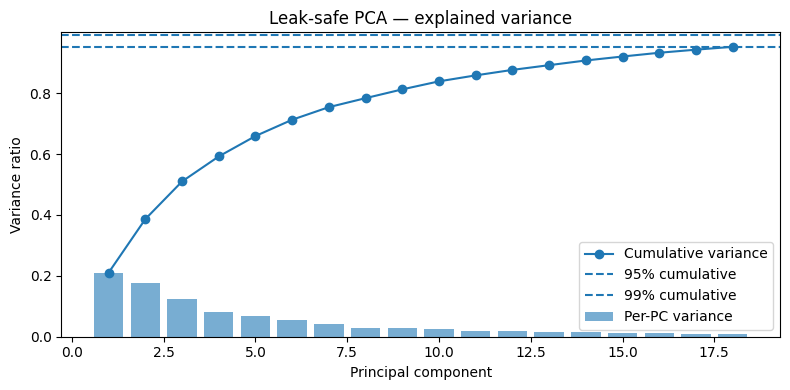

PC  eigenvalue  explained_var_ratio  cumulative_var_ratio
0   1    9.687553             0.210387              0.210387
1   2    8.098135             0.175869              0.386256
2   3    5.690555             0.123583              0.509839
3   4    3.784375             0.082186              0.592025
4   5    3.084954             0.066997              0.659021
5   6    2.464721             0.053527              0.712548
6   7    1.904998             0.041371              0.753919
7   8    1.359629             0.029527              0.783447
8   9    1.327213             0.028823              0.812270
9  10    1.212949             0.026342              0.838612

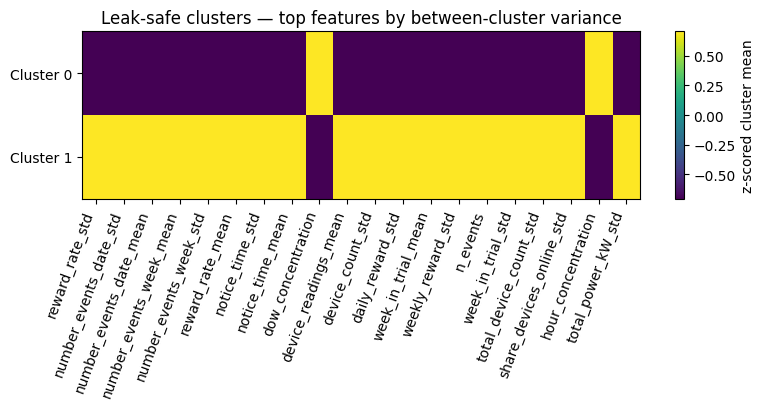

[Leak-safe] PCs=18, k=2, silhouette=0.360
Cluster sizes:
 0    148
1    844
Name: count, dtype: int64
ARI(all vs safe) = 0.449


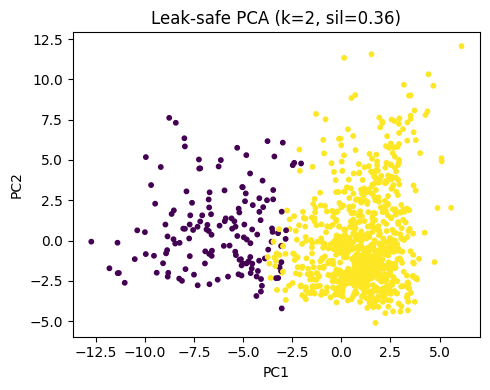


Top loadings (Leak-safe, PC1):
number_events_date_mean    0.280003
number_events_week_mean    0.279176
number_events_date_std     0.267928
reward_rate_std            0.266319
reward_rate_mean           0.248221
notice_time_std            0.247539
number_events_week_std     0.241645
notice_time_mean           0.236338
dow_concentration          0.206736
device_count_std           0.189197
n_events                   0.184920
week_in_trial_mean         0.183517
dtype: float64


In [ ]:
# Define leak-safe feature groups (exclude potentially leaky features)
binary_flags_safe = ['switch_off_event']

numerical_safe = [
    'power','reward_rate','device_count','notice_time',
    'total_power_kW','energy_Wh','daily_energy_Wh','obs',
    'total_device_count','device_readings','share_devices_online',
    'daily_reward','weekly_reward','number_events_week','number_events_date',
    'week_in_trial','period_duration',
    # include cyclical encodings (std values will be dropped after aggregation)
    'hour_sin','hour_cos','day_of_week_sin','day_of_week_cos',
    'month_sin','month_cos','day_of_year_sin','day_of_year_cos'
]

# Weather excluded to avoid leakage; add lagged versions separately if needed
weather_safe = []

# Aggregate events to customer-level summary features
user_safe, onehot_cols_safe = aggregate_user_features(
    smart_switch_data,
    binary_flags=binary_flags_safe,
    numerical_features=numerical_safe,
    weather_features=weather_safe,
    onehot_prefixes=('appliance_', 'preference_', 'city_')
)

# Drop std columns for cyclical encodings (keep means only)
user_safe = drop_cycle_std_cols(user_safe)

# Add time-of-use circular summaries (safe)
user_safe = add_time_of_use_features(user_safe, smart_switch_data)

# Note: leak-safe weather sensitivity could be added using past-only masks (not included here)
# Because any data from feature should not be used in this stategy (see report)

# Select final leak-safe feature set
safe_cols = (
    pick_cols(user_safe, binary_flags_safe, add_stats=False) +
    pick_cols(user_safe, numerical_safe,    add_stats=True)  +
    pick_cols(user_safe, onehot_cols_safe,  add_stats=False) +
    ['n_events']
)
extra_safe = [c for c in ['typical_hour','hour_concentration','typical_dow','dow_concentration']
              if c in user_safe.columns]
safe_cols = list(dict.fromkeys([*safe_cols, *extra_safe]))
safe_cols = [c for c in safe_cols if c in user_safe.columns]

# Run PCA + KMeans on leak-safe features
X_safe = prepare_matrix(user_safe, safe_cols)
pca_s, Xp_s, k_s, sil_s, lab_s = run_pca_kmeans(X_safe, var_target=0.95)  # reduced variance target

# Plot explained variance and display top-10 table
_ = pca_variance_table_and_plot(pca_s, title="Leak-safe PCA — explained variance", top_n=10)

# Heatmap of cluster profiles for leak-safe clustering
z_safe = cluster_profile_heatmap(
    user_df=user_safe,
    feature_cols=safe_cols,
    cluster_labels=lab_s,
    top_k=20,
    title="Leak-safe clusters — top features by between-cluster variance"
)

# Attach segment labels back to users and merge into event-level dataset
user_segments_safe = user_safe[['ca_number']].copy()
user_segments_safe['cust_seg_safe'] = lab_s

smart_switch_data = smart_switch_data.drop(columns=['cust_seg_safe'], errors='ignore')
smart_switch_data = smart_switch_data.merge(user_segments_safe, on='ca_number', how='left')

# Report clustering results
print(f"[Leak-safe] PCs={pca_s.n_components_}, k={k_s}, silhouette={sil_s:.3f}")
print("Cluster sizes:\n", pd.Series(lab_s).value_counts().sort_index())

# Compare leak-safe segmentation to all-features segmentation (if available)
try:
    aligned = user_segments_all.merge(user_segments_safe, on='ca_number', how='inner')
    ari = adjusted_rand_score(aligned['cust_seg_all'], aligned['cust_seg_safe'])
    print(f"ARI(all vs safe) = {ari:.3f}")
except Exception:
    pass

# 2D PCA scatter plot with cluster coloring
if Xp_s.shape[1] >= 2:
    plt.figure(figsize=(5,4))
    plt.scatter(Xp_s[:,0], Xp_s[:,1], c=lab_s, s=10)
    plt.title(f"Leak-safe PCA (k={k_s}, sil={sil_s:.2f})")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

# Show top feature loadings for the first principal component
print("\nTop loadings (Leak-safe, PC1):")
print(top_loadings(pca_s, safe_cols, pc=0, top=12))


Part 2 — “Leak-safe” PCA segmentation DBSCAN (use in override model)

[Leak-safe/DBSCAN] PCs=18, clusters=2, sil(non-noise)=0.882, eps=0.75, min_samples=5, noise_ratio=98.99%
Label counts:
 -1    982
 0      5
 1      5
Name: count, dtype: int64


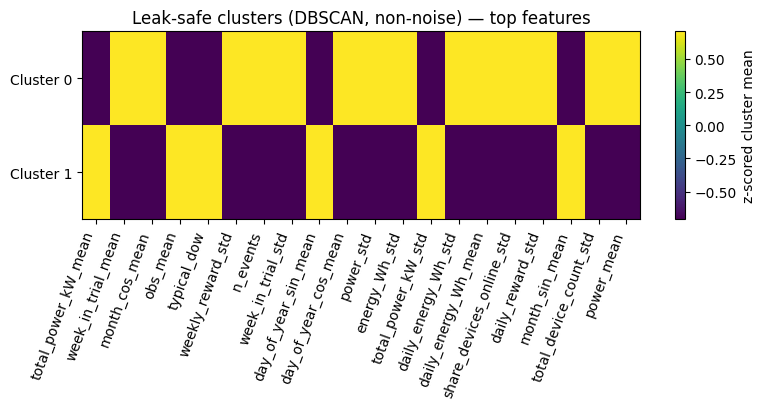

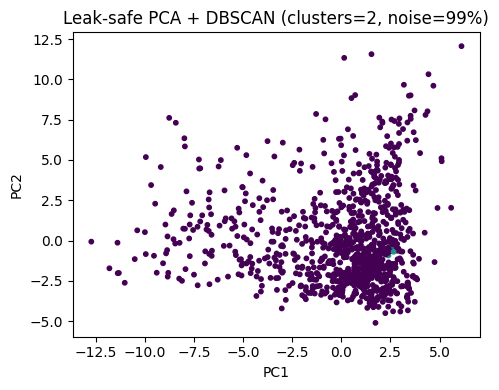

ARI(KMeans-safe vs DBSCAN-safe on non-noise) = 0.000

Top loadings (Leak-safe/DBSCAN, PC1):
number_events_date_mean    0.280003
number_events_week_mean    0.279176
number_events_date_std     0.267928
reward_rate_std            0.266319
reward_rate_mean           0.248221
notice_time_std            0.247539
number_events_week_std     0.241645
notice_time_mean           0.236338
dow_concentration          0.206736
device_count_std           0.189197
n_events                   0.184920
week_in_trial_mean         0.183517
dtype: float64


In [ ]:
# Leak-safe PCA + DBSCAN (keeps event data leak-safe; no merge back to events(just for comparision))

# Define helper once per notebook if missing
try:
    run_pca_dbscan
except NameError:
    def run_pca_dbscan(
        X, var_target=0.95,
        eps_list=None, min_samples_list=None,
        standardize=True
    ):
        # Default search grids for DBSCAN hyperparameters
        if eps_list is None:
            eps_list = np.linspace(0.5, 2.5, 9)
        if min_samples_list is None:
            min_samples_list = [5, 10, 15, 20, 30]

        # Optional standardization before PCA
        Xs = StandardScaler().fit_transform(X) if standardize else X

        # Choose number of PCs to meet target variance
        pca_all = PCA().fit(Xs)
        n_comp = int(np.searchsorted(np.cumsum(
            pca_all.explained_variance_ratio_), var_target) + 1)
        pca = PCA(n_components=n_comp).fit(Xs)
        Xp = pca.transform(Xs)

        # Grid search over eps/min_samples scored by silhouette on non-noise points
        best = {"sil": -1.0, "labels": None, "eps": None,
                "min_samples": None, "noise_ratio": 1.0, "n_clusters": 0}
        for eps in eps_list:
            for ms in min_samples_list:
                lab = DBSCAN(eps=eps, min_samples=ms).fit_predict(Xp)
                non_noise = lab != -1
                n_clusters = len(set(lab[non_noise]))
                if n_clusters < 2 or non_noise.sum() < 2:
                    continue
                sil = silhouette_score(Xp[non_noise], lab[non_noise])
                noise_ratio = 1.0 - non_noise.mean()
                better = (sil > best["sil"]) or (np.isclose(sil, best["sil"]) and noise_ratio < best["noise_ratio"])
                if better:
                    best.update({"sil": sil, "labels": lab, "eps": eps,
                                 "min_samples": ms, "noise_ratio": noise_ratio,
                                 "n_clusters": n_clusters})
        params = {"eps": best["eps"], "min_samples": best["min_samples"]}
        return pca, Xp, params, best["sil"], best["labels"], best["noise_ratio"], best["n_clusters"]

# Build leak-safe feature matrix
X_safe = prepare_matrix(user_safe, safe_cols)

# Run PCA + DBSCAN with a variance target and parameter grid
pca_sd, Xp_sd, db_params_s, sil_sd, lab_sd, noise_ratio_sd, nclu_sd = run_pca_dbscan(
    X_safe, var_target=0.95,
    eps_list=np.linspace(0.5, 2.5, 9),
    min_samples_list=[5, 10, 15, 20, 30],
    standardize=True
)

# Summary of clustering performance and settings
print(f"[Leak-safe/DBSCAN] PCs={pca_sd.n_components_}, clusters={nclu_sd}, "
      f"sil(non-noise)={sil_sd if sil_sd>=0 else float('nan'):.3f}, "
      f"eps={db_params_s['eps']}, min_samples={db_params_s['min_samples']}, "
      f"noise_ratio={noise_ratio_sd:.2%}")
print("Label counts:\n", pd.Series(lab_sd).value_counts().sort_index())

# Heatmap of cluster profiles using only non-noise users
mask_nn = (lab_sd != -1)
if mask_nn.sum() > 0 and len(set(lab_sd[mask_nn])) > 1:
    _ = cluster_profile_heatmap(
        user_df=user_safe.loc[mask_nn].copy(),
        feature_cols=safe_cols,
        cluster_labels=lab_sd[mask_nn],
        top_k=20,
        title="Leak-safe clusters (DBSCAN, non-noise) — top features"
    )

# 2D visualization in PCA space with DBSCAN labels
if Xp_sd.shape[1] >= 2:
    plt.figure(figsize=(5,4))
    plt.scatter(Xp_sd[:,0], Xp_sd[:,1], c=lab_sd, s=10)
    plt.title(f"Leak-safe PCA + DBSCAN (clusters={nclu_sd}, noise={noise_ratio_sd:.0%})")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

# Compare DBSCAN labels to KMeans-safe labels on non-noise subset
try:
    from sklearn.metrics import adjusted_rand_score
    ari_safe = adjusted_rand_score(lab_s[mask_nn], lab_sd[mask_nn])
    print(f"ARI(KMeans-safe vs DBSCAN-safe on non-noise) = {ari_safe:.3f}")
except Exception:
    pass

# Inspect which features drive PC1
print("\nTop loadings (Leak-safe/DBSCAN, PC1):")
print(top_loadings(pca_sd, safe_cols, pc=0, top=12))


In [ ]:
# save outputs
smart_switch_data.to_csv('/content/drive/MyDrive/Colab_Notebooks/IRP/smart_switch_data_PCA.csv', index=False)

Print the head of result (check the result)

In [ ]:
print(smart_switch_data[['ca_number', 'override', 'cust_seg_safe']].head())


     ca_number  override  cust_seg_safe
0  60000191183         0              0
1  60000191183         0              0
2  60000191183         0              0
3  60000191183         0              0
4  60000191183         0              0



### Load the PCA data

In [4]:
path = '/content/drive/MyDrive/Colab_Notebooks/IRP/smart_switch_data_PCA.csv'

# Load the dataset
smart_switch_data = read_csv_with_checks(path)

# Print the dataset feature list
print(smart_switch_data.columns.tolist())

No missing values detected.
Data loaded successfully. Number of records: 7,391,239
['ca_number', 'switch_off_event', 'start_event', 'end_event', 'actual_event', 'power', 'reward_rate', 'device_count', 'notice_time', 'total_power_kW', 'energy_Wh', 'daily_energy_Wh', 'obs', 'average_power_before_switchoff', 'mean_W_before_switchoff', 'reward', 'total_device_count', 'device_readings', 'share_devices_online', 'pre_switch_off_reading', 'daily_reward', 'weekly_reward', 'number_events_week', 'number_events_date', 'wind_speed', 'wind_direction', 'temperature', 'precipitation', 'surface_net_solar_radiation', 'Surface_Pressure', 'Total_Cloud_Cover', 'appliance_AC', 'appliance_Air Cooler', 'appliance_Car Charging socket', 'appliance_Clothes Dryer', 'appliance_Electric Geyser', 'appliance_Electric Heater', 'appliance_Fan', 'appliance_Light / Bulb', 'appliance_Microwave / Oven ', 'appliance_Refrigerator', 'appliance_T.V.', 'appliance_Washing Machine', 'appliance_Water Motor', 'appliance_Water Purif

### Baseline model for predicting the 'override'

In [5]:
# Override prediction with fatigue features — end-to-end utilities

# XGBoost support (GPU/CPU)
try:
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# Reproducibility and pipeline constants
RANDOM_STATE = 42
TIME_COL     = 'round_datetime'          # timestamp column
TARGET_COL   = 'override'                # binary target (0/1)
ID_COL       = 'ca_number'               # customer id
EVENT_FLAG   = 'switch_off_event'        # exposure indicator
DT_FORMAT    = '%Y-%m-%d %H:%M:%S'       # fast datetime parse format
NEG_TO_POS   = 100                       # downsample ratio for class balance (neg:pos)
USE_GPU_XGB  = True                      # set False to force CPU
TOPK_TREND   = 15                        # number of features in SHAP summary

np.random.seed(RANDOM_STATE)

def build_fatigue_features(df: pd.DataFrame,
                           id_col=ID_COL,
                           time_col=TIME_COL,
                           event_flag=EVENT_FLAG) -> pd.DataFrame:
    """
    Construct per-user fatigue features on a rolling time window:
      - events_in_last_7_days: rolling 7D count of event_flag (excludes current row)
      - cumulative_event_count: cumulative events up to previous row
      - override_rate_in_last_7_days: 7D rolling override rate on event rows
      - week_in_trial: weeks since first timestamp for that user (fallback if missing)
    """
    d = df.copy()
    d[time_col] = pd.to_datetime(d[time_col], errors='coerce')
    d = d.dropna(subset=[time_col]).sort_values([id_col, time_col]).reset_index(drop=True)

    if 'override' not in d.columns:
        d['override'] = 0

    def per_user(g):
        g = g.set_index(time_col)
        e = g[event_flag].astype(int)

        # Rolling intensity (exclude current row)
        r7 = e.rolling('7D', closed='left').sum().rename('events_in_last_7_days')

        # Cumulative count up to previous row
        cum_evt = e.cumsum().shift(1).fillna(0).rename('cumulative_event_count')

        # Rolling override rate on event rows over 7D
        ov = g['override'].fillna(0).astype(float)
        ov_num = (ov * e).rolling('7D', closed='left').sum()
        ov_den = e.rolling('7D', closed='left').sum().replace(0, np.nan)
        ov_rate7 = (ov_num / ov_den).fillna(0.0).rename('override_rate_in_last_7_days')

        out = pd.concat([r7, cum_evt, ov_rate7], axis=1).reset_index()
        out[id_col] = g[id_col].iloc[0]
        return out

    fat = d.groupby(id_col, group_keys=False).apply(per_user).reset_index(drop=True)
    d = d.merge(fat, on=[id_col, time_col], how='left')

    # week_in_trial fallback if missing
    if 'week_in_trial' not in d.columns:
        t0 = d.groupby(id_col)[time_col].transform('min')
        d['week_in_trial'] = ((d[time_col] - t0).dt.days // 7).astype(int)

    # Fill any new NaNs from merges
    for c in ['events_in_last_7_days','cumulative_event_count','override_rate_in_last_7_days','week_in_trial']:
        if c in d.columns:
            d[c] = d[c].fillna(0)
    return d

def time_split(df: pd.DataFrame, time_col: str = TIME_COL,
               train_frac=0.70, valid_frac=0.15,
               datetime_format: str | None = DT_FORMAT):
    """Time-aware split into train/valid/test by chronological quantiles (70/15/15 by default)."""
    assert time_col in df.columns, f"Missing time column '{time_col}'"
    d = df.copy()

    # Parse fast with explicit format; fallback if needed
    if datetime_format:
        s = pd.to_datetime(d[time_col], format=datetime_format, errors='coerce')
        if s.isna().mean() > 0.30:
            s = pd.to_datetime(d[time_col], errors='coerce')
    else:
        s = pd.to_datetime(d[time_col], errors='coerce')

    d[time_col] = s
    d = d.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)

    t1 = d[time_col].quantile(train_frac)
    t2 = d[time_col].quantile(train_frac + valid_frac)

    idx_train = d[time_col] <= t1
    idx_valid = (d[time_col] > t1) & (d[time_col] <= t2)
    idx_test  = d[time_col] >  t2
    return d, idx_train, idx_valid, idx_test, t1, t2

def make_leak_safe_feature_lists(df: pd.DataFrame) -> Tuple[List[str], List[str], List[str]]:
    """
    Assemble leak-safe candidate features:
      - numerical base (incl. cyclic + fatigue)
      - binary exposure flag
      - optional segmentation category (cust_seg_safe)
    Excludes realized/future-looking signals to prevent leakage.
    """
    drops = {
        TARGET_COL,
        # realized-after or future-looking (leakage)
        'average_power_before_switchoff','mean_W_before_switchoff','reward','pre_switch_off_reading',
        'start_event','end_event','actual_event',
        'future_switch_off_count','past_switch_off_count','time_to_next_switch_off','time_since_last_switch_off',
        'max_future_notice','time_to_first_notice','mean_future_reward','std_future_reward'
    }
    num_base = [
        'power','reward_rate','device_count','notice_time',
        'total_power_kW','energy_Wh','daily_energy_Wh','obs',
        'total_device_count','device_readings','share_devices_online',
        'daily_reward','weekly_reward','number_events_week','number_events_date',
        'week_in_trial','period_duration',
        'hour_sin','hour_cos','day_of_week_sin','day_of_week_cos',
        'month_sin','month_cos','day_of_year_sin','day_of_year_cos',
        # fatigue (ensure these exist)
        'events_in_last_7_days','cumulative_event_count','override_rate_in_last_7_days'
    ]
    bin_flags = ['switch_off_event']
    onehots  = [c for c in df.columns if c.startswith(('appliance_','preference_','city_'))]
    seg_cat  = ['cust_seg_safe'] if 'cust_seg_safe' in df.columns else []

    cand = [c for c in (num_base + bin_flags + onehots + seg_cat) if c in df.columns and c not in drops]
    num_feats = [c for c in cand if c not in seg_cat]
    cat_feats = seg_cat
    return cand, num_feats, cat_feats

def build_preprocessor(num_feats: List[str], cat_feats: List[str]) -> ColumnTransformer:
    """
    Sparse-friendly preprocessor:
      - numeric: median impute + scaled (with_mean=False for sparse)
      - categorical: most_frequent impute + OHE (ignore unknowns)
    """
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True, min_frequency=50)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

    num_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('sc',  StandardScaler(with_mean=False))
    ])
    cat_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('oh',  ohe)
    ])

    pre = ColumnTransformer(
        transformers=[
            ('num', num_pipe, num_feats),
            ('cat', cat_pipe, cat_feats),
        ],
        remainder='drop',
        sparse_threshold=1.0
    )
    return pre

def get_feature_names_from_pre(pre: ColumnTransformer, num_feats: List[str], cat_feats: List[str]) -> np.ndarray:
    """Retrieve output feature names from a fitted ColumnTransformer (with fallback for older sklearn)."""
    try:
        return pre.get_feature_names_out()
    except Exception:
        pass
    names_num = list(num_feats)
    names_cat = []
    if cat_feats:
        try:
            ohe = pre.named_transformers_['cat'].named_steps['oh']
            cats = ohe.categories_[0]
            names_cat = [f"{cat_feats[0]}_{c}" for c in cats]
        except Exception:
            names_cat = [cat_feats[0]]
    return np.array(names_num + names_cat)

def downsample_negatives(X, y, neg_to_pos_ratio=NEG_TO_POS, seed=RANDOM_STATE):
    """
    Randomly downsample negative class to a target neg:pos ratio.
    Returns (X_sub, y_sub, sample_pos_weight_for_eval).
    """
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]
    if len(idx_pos) == 0:
        return X, y, 1.0

    target_negs = min(len(idx_neg), neg_to_pos_ratio * len(idx_pos))
    sel_neg = rng.choice(idx_neg, target_negs, replace=False)
    sel = np.sort(np.concatenate([idx_pos, sel_neg]))

    Xs = X[sel] if sparse.issparse(X) else X[sel, ...]
    ys = y[sel]
    spw = (ys == 0).sum() / max(1, ys.sum())
    return Xs, ys, spw

def maybe_to_dense(A_sparse, name, force=False, density_threshold=0.20, max_cols_for_dense=128):
    """
    Convert sparse matrix to dense if it is dense enough or has few columns.
    Prints a small diagnostic and returns either dense array or original sparse.
    """
    if not sparse.issparse(A_sparse):
        return A_sparse
    nnz = A_sparse.nnz
    n, m = A_sparse.shape
    dens = nnz / float(n*m) if n*m > 0 else 0.0
    do_dense = force or (dens >= density_threshold) or (m <= max_cols_for_dense)
    print(f"{name}: density≈{dens:.3f}, cols={m} -> {'to DENSE' if do_dense else 'keep SPARSE'}")
    return A_sparse.toarray().astype('float32') if do_dense else A_sparse

def evaluate_model(name: str, mdl, Xv, yv, Xt, yt) -> Dict[str, float]:
    """
    Evaluate classifier on validation and test:
      - AUPRC/ROC-AUC (valid + test)
      - F1-opt threshold selected on validation PR curve
      - classification report on test at that threshold
    Returns a metrics dict (incl. chosen threshold).
    """
    pv = mdl.predict_proba(Xv)[:,1] if hasattr(mdl, 'predict_proba') else mdl.decision_function(Xv)
    pt = mdl.predict_proba(Xt)[:,1] if hasattr(mdl, 'predict_proba') else mdl.decision_function(Xt)

    v_auprc = average_precision_score(yv, pv); v_auc = roc_auc_score(yv, pv)
    t_auprc = average_precision_score(yt, pt); t_auc = roc_auc_score(yt, pt)

    pr, rc, th = precision_recall_curve(yv, pv)
    f1 = 2*pr*rc/(pr+rc+1e-12)
    best_i = int(np.argmax(f1))
    best_th = th[max(0, best_i-1)] if len(th) else 0.5

    print(f"\n[{name}] Valid AUPRC={v_auprc:.4f} ROC-AUC={v_auc:.4f} | Test AUPRC={t_auprc:.4f} ROC-AUC={t_auc:.4f}")
    print(f"  ↳ F1-opt threshold on VALID = {best_th:.3f} (P={pr[best_i]:.3f}, R={rc[best_i]:.3f}, F1={f1[best_i]:.3f})")

    pred_t = (pt >= best_th).astype(int)
    print(f"\n[{name}] TEST report @ {best_th:.3f}")
    from sklearn.metrics import classification_report
    print(classification_report(yt, pred_t, digits=3))

    return {'valid_auprc': v_auprc, 'valid_auc': v_auc,
            'test_auprc': t_auprc, 'test_auc': t_auc,
            'best_threshold': best_th}

def importances_logreg(model, names: np.ndarray) -> pd.DataFrame:
    """Absolute coefficient magnitudes as importances for LogisticRegression-like models."""
    coefs = np.abs(model.coef_.ravel())
    return pd.DataFrame({'feature': names, 'importance': coefs}).sort_values('importance', ascending=False)

def importances_xgb_gain(model_or_booster, names):
    """XGBoost feature gain importances mapped back to column indices/names."""
    if hasattr(model_or_booster, 'get_booster'):
        booster = model_or_booster.get_booster()
    elif hasattr(model_or_booster, 'booster'):
        booster = model_or_booster.booster
    else:
        booster = model_or_booster
    gain_dict = booster.get_score(importance_type='gain')
    gain = np.zeros(len(names), dtype=float)
    for k, v in gain_dict.items():
        if k.startswith('f'):
            i = int(k[1:])
            if i < len(gain): gain[i] = v
    if gain.sum() > 0:
        gain /= gain.sum()
    return pd.DataFrame({'feature': names, 'importance': gain}).sort_values('importance', ascending=False)

def plot_top_importances(df_imp: pd.DataFrame, top_n=30, title="Feature importance"):
    """Horizontal bar chart for the top-N feature importances."""
    if df_imp.empty:
        print(f"[{title}] No importances available."); return
    top = df_imp.head(top_n).iloc[::-1]
    plt.figure(figsize=(9, max(4, 0.35*len(top))))
    plt.barh(top['feature'], top['importance'])
    plt.title(title); plt.xlabel('Importance'); plt.tight_layout(); plt.show()

class BoosterWrapper:
    """Wrap a raw xgboost.Booster so it exposes predict_proba like scikit-learn estimators."""
    def __init__(self, booster: xgb.Booster):
        self.booster = booster
    def predict_proba(self, X):
        dm = xgb.DMatrix(X)
        p = self.booster.predict(dm)
        if p.ndim == 1:
            return np.column_stack([1.0 - p, p])
        return p


Split dataset chronologically

In [6]:
# Shared data prep: time split → fatigue features → leak-safe features → preprocessing → downsample train
assert TARGET_COL in smart_switch_data.columns, "Missing override target."
assert TIME_COL in smart_switch_data.columns, "Missing time column."

# Split dataset chronologically into train/valid/test (70/15/15)
df, idx_tr, idx_va, idx_te, t1, t2 = time_split(
    smart_switch_data, time_col=TIME_COL, train_frac=0.70, valid_frac=0.15, datetime_format=DT_FORMAT
)
print(f"Split sizes: TRAIN={idx_tr.sum():,} | VALID={idx_va.sum():,} | TEST={idx_te.sum():,}")
print("Cutoffs:", t1, "|", t2)

# Build per-user fatigue features (see report for the strategy)
df = build_fatigue_features(df, id_col=ID_COL, time_col=TIME_COL, event_flag=EVENT_FLAG)

# Assemble leak-safe feature lists (now includes fatigue features)
cand_feats, num_feats, cat_feats = make_leak_safe_feature_lists(df)

# Prepare X/y; ensure numeric features are float32
y = df[TARGET_COL].astype(int).values
X = df[cand_feats].copy()
for c in num_feats:
    if c in X.columns:
        X[c] = pd.to_numeric(X[c], errors='coerce').astype('float32')

# Create split views
X_train, y_train = X[idx_tr], y[idx_tr]
X_valid, y_valid = X[idx_va], y[idx_va]
X_test,  y_test  = X[idx_te], y[idx_te]

# Fit preprocessing on TRAIN; transform to sparse matrices
pre = build_preprocessor(num_feats, cat_feats)
pre.fit(X_train)
Xtr_sparse = pre.transform(X_train)
Xva_sparse = pre.transform(X_valid)
Xte_sparse = pre.transform(X_test)

# Get output feature names post-transform
feat_names = get_feature_names_from_pre(pre, num_feats=num_feats, cat_feats=cat_feats)

# Handle class imbalance: report and downsample negatives on TRAIN only
n_pos = int(y_train.sum()); n_neg = int((y_train == 0).sum())
spw_full = n_neg / max(1, n_pos)
print(f"Full TRAIN pos={n_pos:,}, neg={n_neg:,}, scale_pos_weight≈{spw_full:.1f}")

Xtr_ds_sparse, ytr_ds, spw_ds = downsample_negatives(
    Xtr_sparse, y_train, neg_to_pos_ratio=NEG_TO_POS, seed=RANDOM_STATE
)
print("Downsampled TRAIN:", Xtr_ds_sparse.shape, "| pos=", int(ytr_ds.sum()),
      "neg=", int((ytr_ds==0).sum()), "| spw≈", round(spw_ds, 1))


/tmp/ipython-input-1347324277.py:85: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s = pd.to_datetime(d[time_col], errors='coerce')


Split sizes: TRAIN=5,174,290 | VALID=1,108,280 | TEST=1,108,669
Cutoffs: 2024-05-24 13:00:00 | 2024-07-14 15:00:00


/tmp/ipython-input-1347324277.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fat = d.groupby(id_col, group_keys=False).apply(per_user).reset_index(drop=True)


Full TRAIN pos=5,156, neg=5,169,134, scale_pos_weight≈1002.5
Downsampled TRAIN: (520756, 50) | pos= 5156 neg= 515600 | spw≈ 100.0


Start to train the model (XGBoost)
- Print the model training process and result
- List the feature importance

XTR: density≈0.614, cols=50 -> to DENSE
XVA: density≈0.617, cols=50 -> to DENSE
XTE: density≈0.615, cols=50 -> to DENSE
[0]	validation_0-aucpr:0.44138
[1]	validation_0-aucpr:0.55233
[2]	validation_0-aucpr:0.65640
[3]	validation_0-aucpr:0.67650
[4]	validation_0-aucpr:0.68919
[5]	validation_0-aucpr:0.69057
[6]	validation_0-aucpr:0.69164
[7]	validation_0-aucpr:0.74201
[8]	validation_0-aucpr:0.74419
[9]	validation_0-aucpr:0.75214
[10]	validation_0-aucpr:0.76683
[11]	validation_0-aucpr:0.78508
[12]	validation_0-aucpr:0.78512
[13]	validation_0-aucpr:0.78180
[14]	validation_0-aucpr:0.78454
[15]	validation_0-aucpr:0.79707
[16]	validation_0-aucpr:0.79654
[17]	validation_0-aucpr:0.79481
[18]	validation_0-aucpr:0.79282
[19]	validation_0-aucpr:0.79176
[20]	validation_0-aucpr:0.75126
[21]	validation_0-aucpr:0.77072
[22]	validation_0-aucpr:0.77029
[23]	validation_0-aucpr:0.77165
[24]	validation_0-aucpr:0.77533
[25]	validation_0-aucpr:0.80186
[26]	validation_0-aucpr:0.80460
[27]	validation_0-aucpr:0.

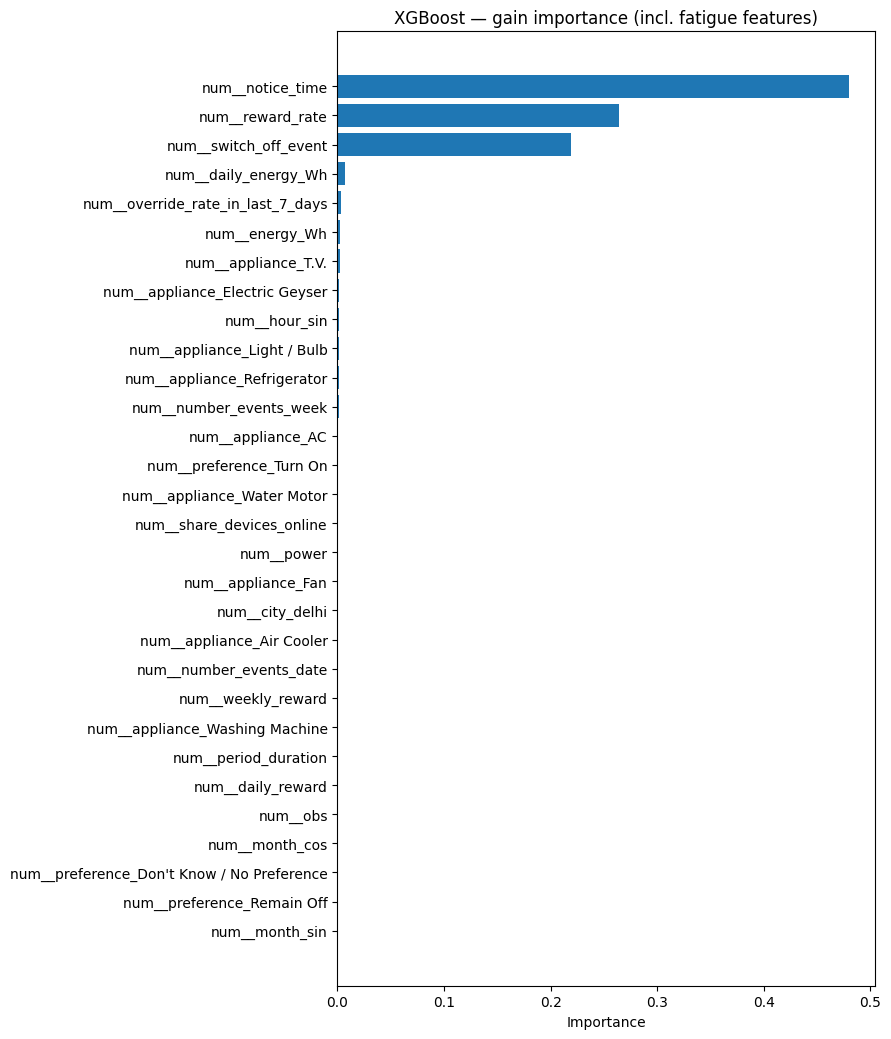

In [8]:
# Train XGBoost with early stopping; report metrics and feature importances
if not HAS_XGB:
    raise RuntimeError("xgboost not installed in this environment.")

# Convert sparse matrices to dense for speed (based on simple heuristics)
Xtr_xgb = maybe_to_dense(Xtr_ds_sparse, "XTR", force=False, density_threshold=0.20, max_cols_for_dense=128)
Xva_xgb = maybe_to_dense(Xva_sparse,     "XVA", force=False, density_threshold=0.20, max_cols_for_dense=128)
Xte_xgb = maybe_to_dense(Xte_sparse,     "XTE", force=False, density_threshold=0.20, max_cols_for_dense=128)

# Build DMatrix objects (XGBoost’s optimized data container)
dtrain = xgb.DMatrix(Xtr_xgb, label=ytr_ds)
dvalid = xgb.DMatrix(Xva_xgb, label=y_valid)

# Model hyperparameters: binary logistic, AUPRC eval, class imbalance via scale_pos_weight
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'eta': 0.10,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'max_bin': 128,
    'min_child_weight': 5,
    'lambda': 1.0,
    'scale_pos_weight': float(spw_ds),
    'tree_method': 'hist',
    'device': 'cuda' if USE_GPU_XGB else 'cpu',
    'seed': RANDOM_STATE,
}

# Train with early stopping on validation AUPRC (best model saved automatically)
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=300,
    evals=[(dvalid, 'validation_0')],
    callbacks=[xgb.callback.EarlyStopping(
        rounds=30, metric_name='aucpr', data_name='validation_0', save_best=True
    )]
)
xgb_mdl = BoosterWrapper(booster)

# Evaluate on validation and test splits
_ = evaluate_model('XGB', xgb_mdl, Xva_xgb, y_valid, Xte_xgb, y_test)

# Compute and plot gain-based feature importances (includes fatigue features)
imp_xgb = importances_xgb_gain(xgb_mdl, feat_names)
plot_top_importances(imp_xgb, top_n=30, title="XGBoost — gain importance (incl. fatigue features)")


Feature Importance
- Using SHAP Values to interpret feature meaning in a machine learning model, as how each elements will affact the result in this prediction model

- **mean_abs_SHAP_logit** This measures the average strength of a feature's impact, regardless of direction. It's a measure of overall importance, showing how much a feature influences predictions on average.

- **mean_delta_prob_pp**. This translates the feature's impact into an average change in the final predicted probability, measured in percentage points (pp).

- **median_delta_prob_pp**. This is a more robust version of the mean, showing the typical change in predicted probability caused by the feature. It's less sensitive to outliers than the mean.

- **p5..p95_delta_prob_pp**. This shows the range of a feature's effect on the predicted probability across most predictions. A narrow range indicates a consistent effect, while a wide range that crosses zero means its impact is dependent (Maybe delta is a curve).


In [9]:
# Directional contribution analysis using XGBoost pred_contribs (SHAP on log-odds).
# Summarize top-K transformed features and report their average effect on predicted probability.

def find_name(keyword, names):
    """Return the first feature name that contains the keyword (helper)."""
    hits = [n for n in names if keyword in n]
    if not hits:
        return None
    return hits[0]

# Pick the top-K transformed features by gain importance for trend analysis
topk_transformed = imp_xgb['feature'].head(TOPK_TREND).tolist()
print("\nTop transformed features for trend analysis:", topk_transformed)

# Compute SHAP contributions on the validation set
dvalid = xgb.DMatrix(Xva_xgb)
shap_all = booster.predict(dvalid, pred_contribs=True)   # shape: (N, n_features + 1); last column is bias
bias     = shap_all[:, -1]
shap_f   = shap_all[:, :-1]                              # per-feature SHAP (log-odds)

# Reconstruct predicted probabilities from SHAP log-odds
sigmoid = lambda z: 1.0 / (1.0 + np.exp(-z))
logit_valid = bias + shap_f.sum(axis=1)
p_valid     = sigmoid(logit_valid)

# Map transformed feature names to their column indices after preprocessing
name2idx = {n:i for i,n in enumerate(feat_names)}

def delta_prob_for_i(i_col):
    """Marginal contribution of feature i to predicted probability (percentage points)."""
    z_wo = logit_valid - shap_f[:, i_col]      # log-odds without feature i
    return sigmoid(z_wo + shap_f[:, i_col]) - sigmoid(z_wo)

# Build summary table for top-K transformed features
rows = []
X_valid_trans = X_valid.copy()  # raw frame before transform (kept for possible raw-side binning)
for tf_name in topk_transformed:
    i = name2idx.get(tf_name, None)
    if i is None:
        continue
    shap_i = shap_f[:, i]
    dp     = delta_prob_for_i(i)

    # Tidy display name (strip common prefixes from ColumnTransformer)
    pretty = tf_name.replace('num__','').replace('cat__','')

    rows.append({
        "transformed_feature": tf_name,
        "feature_pretty": pretty,
        "mean_SHAP_logit": float(np.mean(shap_i)),
        "mean_abs_SHAP_logit": float(np.mean(np.abs(shap_i))),
        "mean_delta_prob_pp": float(np.mean(dp)*100),
        "median_delta_prob_pp": float(np.median(dp)*100),
        "p5..p95_delta_prob_pp": f"{np.percentile(dp,5)*100:.2f}..{np.percentile(dp,95)*100:.2f}",
    })

summary_topk = pd.DataFrame(rows).sort_values("mean_abs_SHAP_logit", ascending=False)
print("\nDirectional SHAP summary on VALID (top-K transformed features):")
print(summary_topk.to_string(index=False))



Top transformed features for trend analysis: ['num__notice_time', 'num__reward_rate', 'num__switch_off_event', 'num__daily_energy_Wh', 'num__override_rate_in_last_7_days', 'num__energy_Wh', 'num__appliance_T.V.', 'num__appliance_Electric Geyser', 'num__hour_sin', 'num__appliance_Light / Bulb', 'num__appliance_Refrigerator', 'num__number_events_week', 'num__appliance_AC', 'num__preference_Turn On', 'num__appliance_Water Motor']

Directional SHAP summary on VALID (top-K transformed features):
              transformed_feature               feature_pretty  mean_SHAP_logit  mean_abs_SHAP_logit  mean_delta_prob_pp  median_delta_prob_pp p5..p95_delta_prob_pp
                 num__reward_rate                  reward_rate        -5.166124             5.274148           -3.558611         -3.243778e+00         -10.64..-0.81
                 num__notice_time                  notice_time        -1.780207             1.818470            0.073256         -8.170576e-02          -0.15..-0.04
        

| Feature                         | Direction (avg) | Mean Δp (pp) | Median Δp (pp) | 5–95% Δp range (pp) | Trend with value (Spearman ρ) | Takeaway                                                                                                                                                               |
| ------------------------------- | :-------------: | -----------: | -------------: | :-----------------: | :---------------------------: | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **reward\_rate**                |        ↓        |    **−2.20** |          −2.58 |    −5.83 … −0.77    |           **+0.25**           | In your current range it **reduces** predicted override. As reward\_rate increases, the effect becomes **less negative** (may turn positive only at very high values). |
| **notice\_time**                |        ↓        |    **−0.02** |          −0.24 |    −0.42 … −0.14    |           **+0.25**           | More notice still **reduces** risk on average, but the **penalty weakens** as notice grows (effect moves toward 0).                                                    |
| **switch\_off\_event** (binary) |      mixed      |    **+0.03** |          −0.05 |    −0.08 … −0.03    |           **+0.34**           | Overall average is tiny, but state-wise: **event=1 ⇒ +1.83 pp**, **event=0 ⇒ −0.05 pp**. The lift happens when the event is on.                                        |
| **daily\_energy\_Wh**           |        ↓        |    **−0.18** |          +0.00 |     −0.10 … 0.00    |           **+0.81**           | Very low energy **lowers** risk; as energy increases, effect becomes **less negative** / slightly positive (non-linear, weak overall).                                 |


| Feature | Direction | Mean Δp (pp) | Median Δp (pp) | 5–95% Δp Range (pp) | Trend (ρ) | Takeaway |
| :--- | :---: | ---:| ---:| :--- | ---:| :--- |
| **reward_rate** | ↓ | -2.20 | -2.58 | `-5.83 … -0.77` | +0.25 | Reduces predicted override, but the effect weakens as the reward amount increases. |
| **notice_time** | ↓ | -0.02 | -0.24 | `-0.42 … -0.14` | +0.25 | More notice time reduces override risk, but the effect weakens as notice grows. |
| **switch_off_event** | mixed | +0.03 | -0.05 | `-0.08 … -0.03` | +0.34 | The effect is conditional: if `event=1` it adds **+1.83 pp** to the risk; otherwise, it has no effect. |
| **daily_energy_Wh** | ↓ | -0.18 | +0.00 | `-0.10 … 0.00` | +0.81 | Very low energy usage lowers risk; for all other users, it has a small positive or neutral effect. |


[LogReg] Valid AUPRC=0.3489 ROC-AUC=0.9952 | Test AUPRC=0.2324 ROC-AUC=0.9939
  ↳ F1-opt threshold on VALID = 0.193 (P=0.410, R=0.406, F1=0.408)

[LogReg] TEST report @ 0.193
              precision    recall  f1-score   support

           0      0.999     0.999     0.999   1107330
           1      0.326     0.292     0.308      1339

    accuracy                          0.998   1108669
   macro avg      0.662     0.646     0.654   1108669
weighted avg      0.998     0.998     0.998   1108669



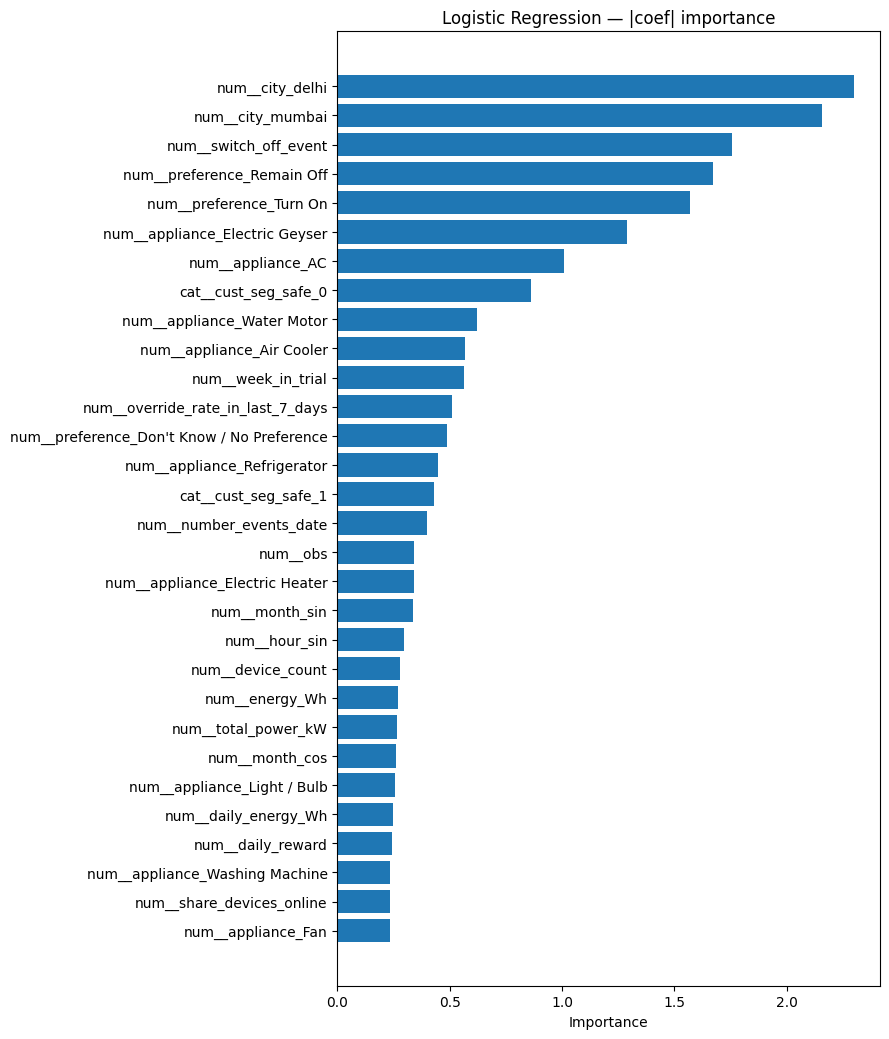

In [ ]:
# Logistic Regression (sparse baseline): train with reweighting, evaluate, and plot importances

# Compute per-sample weights to correct for downsampling
n_pos_full = int(y_train.sum())
n_neg_full = int((y_train == 0).sum())
n_pos_ds   = int((ytr_ds == 1).sum())
n_neg_ds   = int((ytr_ds == 0).sum())

w_pos = (n_pos_full / n_pos_ds) if n_pos_ds > 0 else 1.0
w_neg = (n_neg_full / n_neg_ds) if n_neg_ds > 0 else 1.0
sample_w = np.where(ytr_ds == 1, w_pos, w_neg).astype("float32")

# Sparse-friendly logistic regression (saga solver)
lr = LogisticRegression(
    solver='saga', penalty='l2', C=0.5,
    max_iter=3000, class_weight=None, n_jobs=-1, random_state=RANDOM_STATE
)
lr.fit(Xtr_ds_sparse, ytr_ds, sample_weight=sample_w)

# Evaluate on validation and test splits
_ = evaluate_model('LogReg', lr, Xva_sparse, y_valid, Xte_sparse, y_test)

# Feature importances for Logistic Regression (absolute coefficients)
try:
    lr_names = get_feature_names_from_pre(pre, num_feats=num_feats, cat_feats=cat_feats)
    imp_lr = importances_logreg(lr, lr_names)
    plot_top_importances(imp_lr, top_n=30, title="Logistic Regression — |coef| importance")
except Exception as e:
    print("LogReg importances failed:", e)


### Optimize the XGBoots model

Since the XGBoost has the best performance, optimizing the XGBoost model and run the SHAP again

In [10]:
# XGBoost tuning (random search with metric history) + stable reporting booster (fatigue-aware setup)

# Require variables from Part A prep (fatigue features added before pre.transform)
need = ['Xtr_xgb','ytr_ds','Xva_xgb','y_valid','spw_ds','USE_GPU_XGB','RANDOM_STATE',
        'feat_names','X_test','Xte_xgb','y_test']
missing = [v for v in need if v not in globals()]
assert not missing, f"Missing in scope: {missing}. Run Part A prep first (with build_fatigue_features). Missing: {missing}"

dtrain = xgb.DMatrix(Xtr_xgb, label=ytr_ds)
dvalid = xgb.DMatrix(Xva_xgb, label=y_valid)

random.seed(int(RANDOM_STATE)); np.random.seed(int(RANDOM_STATE))

def sample_params(spw, use_gpu=True):
    return {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'eta': random.choice([0.05, 0.10]),
        'max_depth': random.choice([5, 6, 7]),
        'min_child_weight': random.choice([3, 5, 7]),
        'subsample': random.choice([0.7, 0.9]),
        'colsample_bytree': random.choice([0.6, 0.9]),
        'lambda': random.choice([1.0, 3.0]),
        'alpha': random.choice([0.0, 0.5]),
        'scale_pos_weight': float(spw),
        'tree_method': 'hist',
        'device': 'cuda' if use_gpu else 'cpu',
        'seed': int(RANDOM_STATE),
    }

TRIALS = 30
best_score, best_params, best_booster, best_evals_result = -1.0, None, None, None

print("\n=== XGBoost random search (AUPRC, early stopping) ===")
for t in range(1, TRIALS+1):
    params = sample_params(spw_ds, USE_GPU_XGB)
    evals_result_t = {}
    booster_t = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],
        evals_result=evals_result_t,
        callbacks=[xgb.callback.EarlyStopping(
            rounds=100, metric_name='aucpr', data_name='valid', save_best=True
        )]
    )
    score = float(max(evals_result_t['valid']['aucpr']))
    print(f"[trial {t:02d}] AUPRC={score:.4f} | {params}")
    if score > best_score:
        best_score, best_params, best_booster, best_evals_result = score, params, booster_t, evals_result_t

print("\nBest VALID AUPRC:", round(best_score, 4))
print("Best params:", best_params)

# Deterministic-style “reporting” retrain for stable importances/plots
REPORT_ON_CPU = False  # set True for stricter CPU determinism
report_params = best_params.copy()
report_params.update({
    'subsample': 1.0,                 # remove row-sampling randomness
    'colsample_bytree': 1.0,          # remove feature-sampling randomness
    'sampling_method': 'uniform',
    'deterministic_histogram': True,  # ignored if not supported
    'device': 'cpu' if REPORT_ON_CPU else best_params.get('device', 'cuda'),
    'seed': int(RANDOM_STATE),
})
report_evals = {}
report_booster = xgb.train(
    params=report_params,
    dtrain=dtrain,
    num_boost_round=4000,
    evals=[(dtrain, 'train'), (dvalid, 'valid')],
    evals_result=report_evals,
    callbacks=[xgb.callback.EarlyStopping(
        rounds=200, metric_name='aucpr', data_name='valid', save_best=True
    )]
)
print("Reporting model VALID AUPRC:", max(report_evals['valid']['aucpr']))

# Expose both tuned and reporting models (use reporting model downstream for stability)
booster_tuned   = best_booster
booster         = report_booster       # used for importances/SHAP
best_history    = report_evals         # metric history (reporting model)
best_params_out = {'tuned': best_params, 'reporting': report_params}

# Optionally save both models and parameter dict
try:
    booster_tuned.save_model("xgb_best_tuned.json")
    booster.save_model("xgb_best_reporting.json")
    import json
    with open("xgb_best_params.json","w") as f: json.dump(best_params_out, f, indent=2)
    print("Saved tuned & reporting models and params.")
except Exception as e:
    print("Save skipped:", e)

# Glue: wrapper exposing predict_proba for the reporting booster
class BoosterWrapper:
    def __init__(self, booster): self.booster = booster
    def predict_proba(self, X):
        dm = xgb.DMatrix(X); p = self.booster.predict(dm)
        return np.column_stack([1.0 - p, p])

xgb_mdl = BoosterWrapper(booster)


Streaming output truncated to the last 5000 lines.
[254]	train-aucpr:0.98586	valid-aucpr:0.86622
[255]	train-aucpr:0.98596	valid-aucpr:0.86636
[256]	train-aucpr:0.98605	valid-aucpr:0.86633
[257]	train-aucpr:0.98623	valid-aucpr:0.86603
[258]	train-aucpr:0.98635	valid-aucpr:0.86622
[259]	train-aucpr:0.98644	valid-aucpr:0.86625
[260]	train-aucpr:0.98655	valid-aucpr:0.86626
[261]	train-aucpr:0.98664	valid-aucpr:0.86628
[262]	train-aucpr:0.98676	valid-aucpr:0.86597
[263]	train-aucpr:0.98679	valid-aucpr:0.86613
[264]	train-aucpr:0.98694	valid-aucpr:0.86592
[265]	train-aucpr:0.98705	valid-aucpr:0.86586
[266]	train-aucpr:0.98720	valid-aucpr:0.86565
[267]	train-aucpr:0.98732	valid-aucpr:0.86585
[268]	train-aucpr:0.98741	valid-aucpr:0.86598
[269]	train-aucpr:0.98752	valid-aucpr:0.86610
[270]	train-aucpr:0.98767	valid-aucpr:0.86643
[271]	train-aucpr:0.98775	valid-aucpr:0.86637
[272]	train-aucpr:0.98781	valid-aucpr:0.86631
[273]	train-aucpr:0.98785	valid-aucpr:0.86633
[274]	train-aucpr:0.98798	val

/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [18:28:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "deterministic_histogram" } are not used.

  self.starting_round = model.num_boosted_rounds()


[14]	train-aucpr:0.90799	valid-aucpr:0.64240
[15]	train-aucpr:0.90807	valid-aucpr:0.64246
[16]	train-aucpr:0.90812	valid-aucpr:0.64250
[17]	train-aucpr:0.90973	valid-aucpr:0.64518
[18]	train-aucpr:0.91001	valid-aucpr:0.64514
[19]	train-aucpr:0.91020	valid-aucpr:0.64545
[20]	train-aucpr:0.91153	valid-aucpr:0.64638
[21]	train-aucpr:0.91173	valid-aucpr:0.64687
[22]	train-aucpr:0.91318	valid-aucpr:0.64706
[23]	train-aucpr:0.91319	valid-aucpr:0.64618
[24]	train-aucpr:0.91344	valid-aucpr:0.64664
[25]	train-aucpr:0.91343	valid-aucpr:0.64671
[26]	train-aucpr:0.91350	valid-aucpr:0.64677
[27]	train-aucpr:0.92251	valid-aucpr:0.68534
[28]	train-aucpr:0.92285	valid-aucpr:0.68589
[29]	train-aucpr:0.92296	valid-aucpr:0.68589
[30]	train-aucpr:0.92333	valid-aucpr:0.68636
[31]	train-aucpr:0.92337	valid-aucpr:0.68636
[32]	train-aucpr:0.92360	valid-aucpr:0.68646
[33]	train-aucpr:0.92370	valid-aucpr:0.68640
[34]	train-aucpr:0.92615	valid-aucpr:0.68974
[35]	train-aucpr:0.92639	valid-aucpr:0.68999
[36]	train

Plot the training process where AUPRC as evaluation index

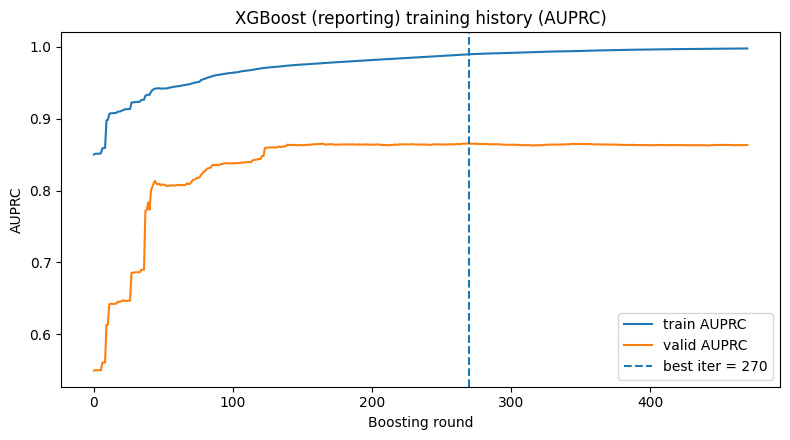

Best iteration: 270 | Best valid AUPRC: 0.8655


In [11]:
# Plot AUPRC curves over boosting rounds and mark the best iteration

train_curve = best_history['train']['aucpr']
valid_curve = best_history['valid']['aucpr']
best_iter  = int(np.argmax(valid_curve))
best_score = valid_curve[best_iter]

plt.figure(figsize=(8,4.5))
plt.plot(train_curve, label="train AUPRC")
plt.plot(valid_curve, label="valid AUPRC")
plt.axvline(best_iter, linestyle='--', label=f"best iter = {best_iter}")
plt.title("XGBoost (reporting) training history (AUPRC)")
plt.xlabel("Boosting round")
plt.ylabel("AUPRC")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best iteration: {best_iter} | Best valid AUPRC: {best_score:.4f}")


In [12]:
# Reporting evaluation: compute metrics (AUPRC/AUC), then derive stable importances and SHAP summaries

# Predicted probabilities for validation/test
pv = xgb_mdl.predict_proba(Xva_xgb)[:,1]
pt = xgb_mdl.predict_proba(Xte_xgb)[:,1]

# Aggregate metrics on VALID/TEST and choose F1-optimal threshold on VALID
v_auprc, t_auprc = average_precision_score(y_valid, pv), average_precision_score(y_test, pt)
v_auc,   t_auc   = roc_auc_score(y_valid, pv), roc_auc_score(y_test, pt)
pr, rc, th = precision_recall_curve(y_valid, pv); f1 = 2*pr*rc/(pr+rc+1e-12)
bi = int(np.argmax(f1)); th_f1 = th[max(0, bi-1)] if len(th) else 0.5
print(f"\n[Reporting XGB] VALID AUPRC={v_auprc:.4f} ROC-AUC={v_auc:.4f} | TEST AUPRC={t_auprc:.4f} ROC-AUC={t_auc:.4f}")
print(f"  ↳ F1-opt threshold on VALID = {th_f1:.3f} (P={pr[bi]:.3f}, R={rc[bi]:.3f}, F1={f1[bi]:.3f})")
print("\n[Reporting XGB] TEST report @ {:.3f}".format(th_f1))
print(classification_report(y_test, (pt >= th_f1).astype(int), digits=3))

# Gain-based importance (reference baseline)
gd = booster.get_score(importance_type='gain')
gain = np.zeros(len(feat_names), dtype=float)
for k,v in gd.items():
    if k.startswith('f'):
        idx = int(k[1:])
        if idx < len(gain): gain[idx] = v
if gain.sum() > 0: gain /= gain.sum()
imp_gain = pd.DataFrame({'feature': feat_names, 'gain': gain}).sort_values('gain', ascending=False).reset_index(drop=True)

# SHAP global importance on VALID: mean absolute SHAP (log-odds) per feature
dvalid = xgb.DMatrix(Xva_xgb)
shap_all = booster.predict(dvalid, pred_contribs=True)   # (N, F+1) with bias in last column
shap_f = shap_all[:, :-1]
imp_shap = (pd.DataFrame({'feature': feat_names,
                          'mean_abs_shap': np.abs(shap_f).mean(axis=0)})
            .sort_values('mean_abs_shap', ascending=False)
            .reset_index(drop=True))


# Compute logit and probability from SHAP contributions
dvalid = xgb.DMatrix(Xva_xgb)
shap_all = booster.predict(dvalid, pred_contribs=True)  # shape: (N, F+1), last column is bias
bias = shap_all[:, -1]
shap_f = shap_all[:, :-1]  # exclude bias column

# Convert log-odds to probabilities
logit_valid = bias + shap_f.sum(axis=1)
sigmoid = lambda z: 1.0 / (1.0 + np.exp(-z))
p_valid = sigmoid(logit_valid)

# Map feature names to their column index
name2idx = {n: i for i, n in enumerate(feat_names)}

# Use top-K features by SHAP |mean| for analysis
topk_transformed = imp_shap['feature'].head(TOPK_TREND).tolist()
print("\nTop transformed features for trend analysis:", topk_transformed)

def delta_prob_for_i(i_col):
    """Marginal contribution of feature i to predicted probability (percentage points)."""
    z_wo = logit_valid - shap_f[:, i_col]  # remove feature i from logit
    return sigmoid(z_wo + shap_f[:, i_col]) - sigmoid(z_wo)

# Build directional summary table
rows = []
for tf_name in topk_transformed:
    i = name2idx.get(tf_name, None)
    if i is None:
        continue
    shap_i = shap_f[:, i]
    dp = delta_prob_for_i(i)

    pretty = tf_name.replace("num__", "").replace("cat__", "")

    rows.append({
        "transformed_feature": tf_name,
        "feature_pretty": pretty,
        "mean_SHAP_logit": float(np.mean(shap_i)),
        "mean_abs_SHAP_logit": float(np.mean(np.abs(shap_i))),
        "mean_delta_prob_pp": float(np.mean(dp) * 100),
        "median_delta_prob_pp": float(np.median(dp) * 100),
        "p5..p95_delta_prob_pp": f"{np.percentile(dp, 5)*100:.2f}..{np.percentile(dp, 95)*100:.2f}",
    })

summary_topk = pd.DataFrame(rows).sort_values("mean_abs_SHAP_logit", ascending=False)

print("\nDirectional SHAP summary on VALID (top-K transformed features):")
print(summary_topk.to_string(index=False))




[Reporting XGB] VALID AUPRC=0.8655 ROC-AUC=0.9994 | TEST AUPRC=0.8027 ROC-AUC=0.9992
  ↳ F1-opt threshold on VALID = 0.994 (P=0.815, R=0.779, F1=0.797)

[Reporting XGB] TEST report @ 0.994
              precision    recall  f1-score   support

           0      1.000     1.000     1.000   1107330
           1      0.781     0.688     0.731      1339

    accuracy                          0.999   1108669
   macro avg      0.890     0.844     0.865   1108669
weighted avg      0.999     0.999     0.999   1108669


Top transformed features for trend analysis: ['num__reward_rate', 'num__daily_energy_Wh', 'num__number_events_date', 'num__energy_Wh', 'num__daily_reward', 'num__power', 'num__override_rate_in_last_7_days', 'num__city_delhi', 'num__weekly_reward', 'num__obs', 'num__events_in_last_7_days', 'num__share_devices_online', 'num__day_of_year_cos', 'num__day_of_year_sin', 'num__week_in_trial']

Directional SHAP summary on VALID (top-K transformed features):
              transformed_fe

Beeswarm Plot (Global Importance Overview)

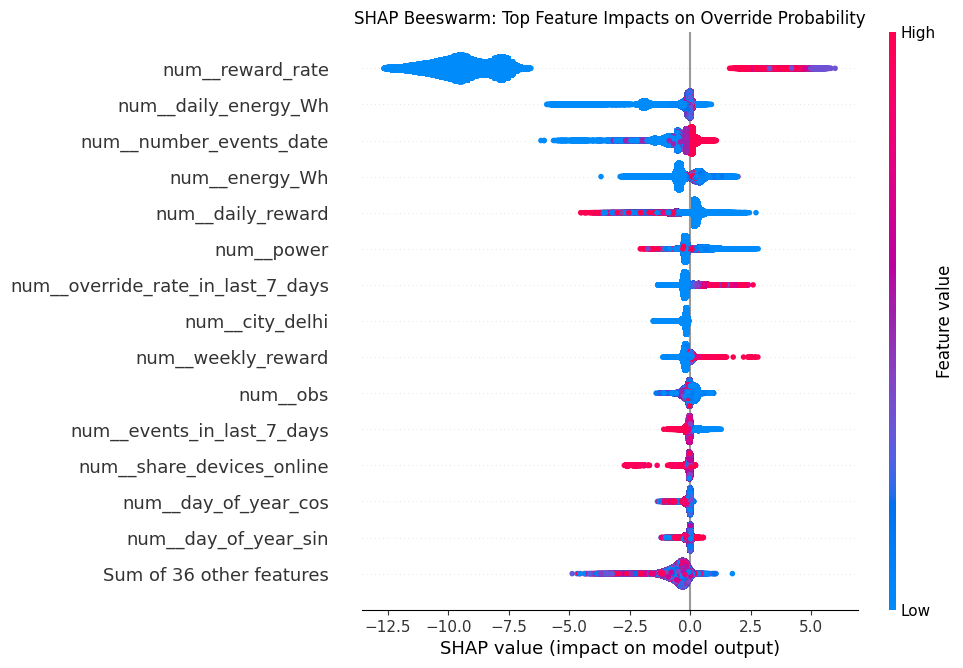

In [13]:
# Initialize SHAP explainer for the XGBoost booster (TreeExplainer is fast for tree models)
explainer = shap.Explainer(booster)

# Ensure validation matrix has feature names aligned with feat_names
Xva_df = pd.DataFrame(Xva_xgb, columns=feat_names)

# Compute SHAP values for the validation set (reuse if already computed)
shap_values = explainer(Xva_df)

# Visualize global feature influence with a beeswarm summary plot
plt.figure(figsize=(12, 6))
plt.title("SHAP Beeswarm: Top Feature Impacts on Override Probability")
shap.plots.beeswarm(shap_values, max_display=15)
plt.show()


Bar Plot (Simpler Global Summary)

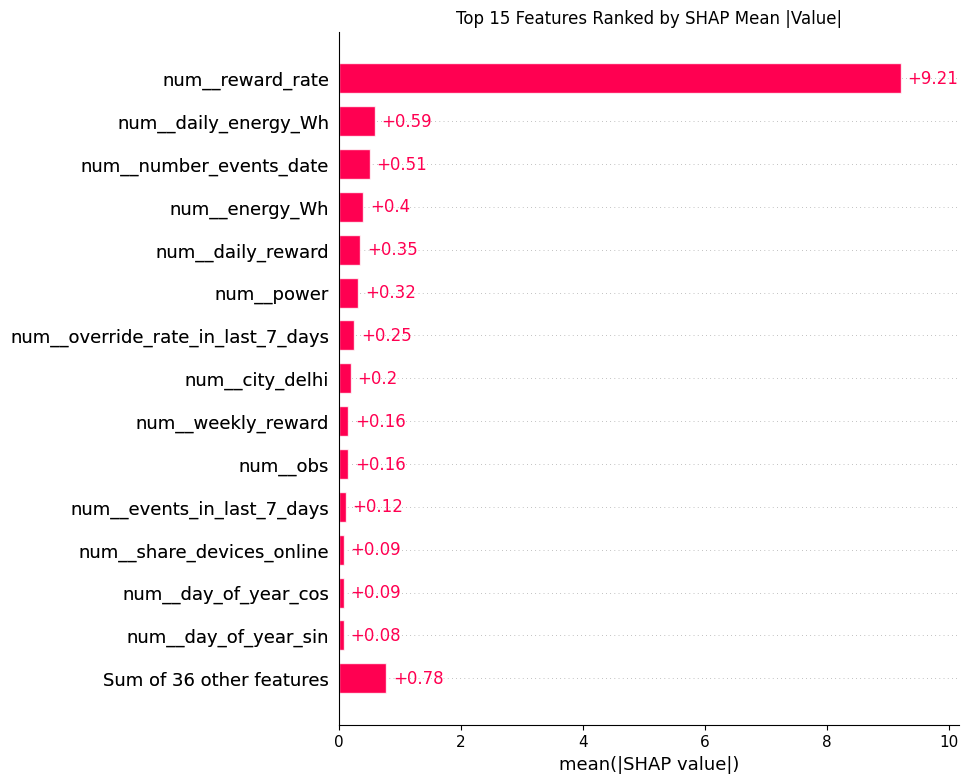

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Top 15 Features Ranked by SHAP Mean |Value|")
shap.plots.bar(shap_values, max_display=15)
plt.show()

Bar Plot (Simpler Global Summary)

### Deep Learning - LSTM model

- Config + feature prep + time split + scaler

In [ ]:
# Sequence modeling definitions for an LSTM override predictor (config, splitting, dataset, model, and eval helpers)

# Configuration (edit to suit your experiment)
CFG = dict(
    SEQ_LEN     = 336,        # number of timesteps in each input sequence
    STEP        = 1,          # sliding window stride (1 = every timestep)
    BATCH_SIZE  = 2048,
    ACCUM_STEPS = 2,
    EPOCHS      = 30,
    LR          = 1e-3,
    USE_FOCAL   = True,       # use FocalLoss instead of BCE if True
    EVENT_ONLY  = False,      # restrict to rows where switch_off_event==1
    DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu',
    RANDOM_STATE= 42,
    TIME_COL    = 'round_datetime',
    TARGET_COL  = 'override',
    CUSTOMER_COL= 'customer_id',
    TIME_FMT    = None,       # e.g. '%Y-%m-%d %H:%M:%S' or None for auto-parse
)

# Reproducibility and performance knobs
np.random.seed(CFG['RANDOM_STATE'])
torch.manual_seed(CFG['RANDOM_STATE'])
if CFG['DEVICE']=='cuda':
    torch.backends.cudnn.benchmark = True
    torch.set_float32_matmul_precision("high")

# Optional fatigue-feature hook: call your fatigue builder if provided (ensures time column is parsed)
def maybe_add_fatigue(df: pd.DataFrame, fatigue_fn=None, time_col=None):
    """If fatigue_fn is provided, call it; else return df unchanged.
    Ensures time column exists before calling your function."""
    if fatigue_fn is None:
        return df
    tc = time_col or CFG['TIME_COL']
    if tc not in df.columns:
        raise ValueError(f"time column '{tc}' not found before fatigue features.")
    # Make sure time column is parsed (some fatigue functions expect datetime)
    d = df.copy()
    d[tc] = pd.to_datetime(d[tc], errors='coerce')
    d = d.dropna(subset=[tc])
    return fatigue_fn(d)

# Leak-safe column selection: keep only numeric features (plus optional OHE for cust_seg_safe)
def leak_safe_feature_cols(df: pd.DataFrame):
    drops = {
        CFG['TARGET_COL'], 'average_power_before_switchoff','mean_W_before_switchoff','reward',
        'pre_switch_off_reading','start_event','end_event','actual_event',
        'future_switch_off_count','past_switch_off_count','time_to_next_switch_off','time_since_last_switch_off',
        'max_future_notice','time_to_first_notice','mean_future_reward','std_future_reward',
        CFG['TIME_COL'], CFG['CUSTOMER_COL']
    }
    d = df.copy()
    if 'cust_seg_safe' in d.columns and not any(c.startswith('cust_seg_safe_') for c in d.columns):
        seg = pd.get_dummies(d['cust_seg_safe'].astype('category'), prefix='cust_seg_safe')
        d = pd.concat([d.drop(columns=['cust_seg_safe']), seg], axis=1)
    keep = [c for c in d.columns if c not in drops and pd.api.types.is_numeric_dtype(d[c])]
    return keep, d

# Chronological split (70/15/15) with robust datetime parsing
def time_split(df, time_col=CFG['TIME_COL'], train_frac=0.70, valid_frac=0.15, dt_format=CFG['TIME_FMT']):
    d = df.copy()
    # robust parse: try format if given; else fallback to dateutil
    s = (pd.to_datetime(d[time_col], format=dt_format, errors='coerce')
         if dt_format else pd.to_datetime(d[time_col], errors='coerce'))
    if s.isna().mean() > 0.30:
        s = pd.to_datetime(d[time_col], errors='coerce')  # last resort
    d[time_col] = s
    d = d.dropna(subset=[time_col]).sort_values([CFG['CUSTOMER_COL'], time_col]).reset_index(drop=True)
    t1 = d[time_col].quantile(train_frac)
    t2 = d[time_col].quantile(train_frac + valid_frac)
    m_tr = d[time_col] <= t1
    m_va = (d[time_col] > t1) & (d[time_col] <= t2)
    m_te = d[time_col] >  t2
    return d, m_tr, m_va, m_te, t1, t2

# Build sliding window start indices per customer id
def build_index(ids, seq_len=CFG['SEQ_LEN'], step=CFG['STEP']):
    ids = np.asarray(ids)
    idx = []
    bounds = np.flatnonzero(np.r_[True, ids[1:]!=ids[:-1], True])
    for a,b in zip(bounds[:-1], bounds[1:]):
        L = b - a
        if L <= seq_len: continue
        idx.extend(range(a, b-seq_len, step))
    return np.array(idx, dtype=np.int64)

# Lightweight PyTorch Dataset: returns (sequence tensor, next-step label)
class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, ids, starts, seq_len=CFG['SEQ_LEN']):
        self.X, self.y, self.ids = X, y, ids
        self.starts = starts
        self.seq_len = seq_len
    def __len__(self): return len(self.starts)
    def __getitem__(self, i):
        s = self.starts[i]; e = s + self.seq_len
        x = self.X[s:e]
        y = self.y[e] if (e < len(self.y) and self.ids[e]==self.ids[e-1]) else 0.0
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.float32)

# DataLoader factory with sensible worker/prefetch defaults
def make_loader(ds, bs, shuffle):
    nw = min(8, os.cpu_count() or 4)
    return torch.utils.data.DataLoader(
        ds, batch_size=bs, shuffle=shuffle,
        num_workers=nw, pin_memory=(CFG['DEVICE']=='cuda'),
        persistent_workers=True, prefetch_factor=4, drop_last=False
    )

# LSTM classifier head (last timestep → MLP → logit)
class LSTMClassifier(nn.Module):
    def __init__(self, in_dim, hidden=128, layers=2, dropout=0.2, bidir=False):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_dim, hidden_size=hidden, num_layers=layers,
            batch_first=True, dropout=dropout if layers>1 else 0.0,
            bidirectional=bidir
        )
        out_dim = hidden * (2 if bidir else 1)
        self.head = nn.Sequential(
            nn.Linear(out_dim, out_dim), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(out_dim, 1)
        )
    def forward(self, x):
        out, _ = self.lstm(x)          # (B, T, H[/2])
        last = out[:, -1, :]
        return self.head(last).squeeze(-1)

# Focal loss for class imbalance (gamma/alpha as in RetinaNet)
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super().__init__()
        self.gamma, self.alpha = gamma, alpha
    def forward(self, logits, targets):
        bce = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p = torch.sigmoid(logits)
        pt = p*targets + (1-p)*(1-targets)
        w  = (self.alpha*targets + (1-self.alpha)*(1-targets)) * (1-pt).pow(self.gamma)
        return (w*bce).mean()

# Evaluation helpers: predict probabilities over a loader (no grad)
def evaluate_probs(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(CFG['DEVICE'], non_blocking=True)
            prob = torch.sigmoid(model(xb)).cpu().numpy()
            preds.append(prob); trues.append(yb.numpy())
    return np.concatenate(preds), np.concatenate(trues)

# PR-based threshold selection (max F1 on validation)
def f1_opt_threshold(y_true, p_valid):
    pr, rc, th = precision_recall_curve(y_true, p_valid)
    f1 = 2*pr*rc/(pr+rc+1e-12)
    i = int(np.argmax(f1))
    return (th[max(0, i-1)] if len(th) else 0.5), pr[i], rc[i], f1[i]

# Choose the smallest threshold achieving a target precision (default 0.70)
def threshold_for_precision(p_valid, y_valid, target_precision=0.70):
    pr, rc, th = precision_recall_curve(y_valid, p_valid)
    pr_ = pr[1:]
    idx = np.where(pr_ >= target_precision)[0]
    if len(idx)==0: return 0.5
    i = idx[0] + 1
    return th[i-1]



- 2) Windowing + Dataset + LSTM

In [ ]:
# Data preparation for sequence modeling: parse time, (optional) add fatigue, split, select leak-safe features, scale, and window into sequences
# smart_switch_data is assumed to be loaded as a full DataFrame

USE_FATIGUE = False        # set True if you have a reusable fatigue function
fatigue_fn  = None         # e.g., your XGB-side add_fatigue_features

# Ensure a customer identifier column is present
if CFG['CUSTOMER_COL'] not in smart_switch_data.columns:
    smart_switch_data = smart_switch_data.copy()
    smart_switch_data[CFG['CUSTOMER_COL']] = 0

# Parse timestamps early (before optional fatigue augmentation)
df0 = smart_switch_data.copy()
df0[CFG['TIME_COL']] = (pd.to_datetime(df0[CFG['TIME_COL']], format=CFG['TIME_FMT'], errors='coerce')
                        if CFG['TIME_FMT'] else pd.to_datetime(df0[CFG['TIME_COL']], errors='coerce'))
df0 = df0.dropna(subset=[CFG['TIME_COL']])

# Optionally add fatigue features (no-op if USE_FATIGUE=False or fatigue_fn is None)
df_aug = maybe_add_fatigue(df0, fatigue_fn=fatigue_fn, time_col=CFG['TIME_COL']) if USE_FATIGUE else df0

# Chronological split, leak-safe feature selection, and standardization
df_all, m_tr, m_va, m_te, t1, t2 = time_split(df_aug)
feat_cols, df_all = leak_safe_feature_cols(df_all)

def maybe_event_only(d):
    # Optionally restrict to rows where switch_off_event==1
    return d[d['switch_off_event']==1] if (CFG['EVENT_ONLY'] and 'switch_off_event' in d.columns) else d

df_tr = maybe_event_only(df_all[m_tr])
df_va = maybe_event_only(df_all[m_va])
df_te = maybe_event_only(df_all[m_te])

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(df_tr[feat_cols].astype('float32'))

def to_block(d):
    # Produce (X, y, ids, timestamps) blocks for downstream windowing
    X = scaler.transform(d[feat_cols].astype('float32')).astype('float32')
    y = d[CFG['TARGET_COL']].astype('float32').values
    ids = d[CFG['CUSTOMER_COL']].values
    ts  = d[CFG['TIME_COL']].values
    return X, y, ids, ts

X_tr, y_tr, id_tr, ts_tr = to_block(df_tr)
X_va, y_va, id_va, ts_va = to_block(df_va)
X_te, y_te, id_te, ts_te = to_block(df_te)

# Build sliding-window start indices and wrap into Datasets/DataLoaders
idx_tr = build_index(id_tr, CFG['SEQ_LEN'], CFG['STEP'])
idx_va = build_index(id_va, CFG['SEQ_LEN'], CFG['STEP'])
idx_te = build_index(id_te, CFG['SEQ_LEN'], CFG['STEP'])

ds_tr = SeqDataset(X_tr, y_tr, id_tr, idx_tr, CFG['SEQ_LEN'])
ds_va = SeqDataset(X_va, y_va, id_va, idx_va, CFG['SEQ_LEN'])
ds_te = SeqDataset(X_te, y_te, id_te, idx_te, CFG['SEQ_LEN'])

dl_tr = make_loader(ds_tr, CFG['BATCH_SIZE'], True)
dl_va = make_loader(ds_va, CFG['BATCH_SIZE'], False)
dl_te = make_loader(ds_te, CFG['BATCH_SIZE'], False)

print(f"Using {len(feat_cols)} features. Cutoffs: {t1} | {t2}")
print("Num windows (train/valid/test):", len(ds_tr), len(ds_va), len(ds_te))


/tmp/ipython-input-432659907.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if CFG['TIME_FMT'] else pd.to_datetime(df0[CFG['TIME_COL']], errors='coerce'))


Using 56 features. Cutoffs: 2024-05-24 13:00:00 | 2024-07-14 15:00:00
Num windows (train/valid/test): 5173954 1107944 1108333


3) Training loop (BCE or focal), early stopping on AUPRC, evaluation

In [ ]:
EPOCHS      = 30 # Adjust based on GPU and training time

In [ ]:
# Train and evaluate the LSTM sequence model with imbalance handling, AMP, early stopping, and threshold-based reports
in_dim = X_tr.shape[1]
model = LSTMClassifier(in_dim, hidden=128, layers=2, dropout=0.2, bidir=False).to(CFG['DEVICE'])
try:
    model = torch.compile(model)
except Exception:
    pass

# Class-imbalance loss: FocalLoss if enabled; otherwise BCE with a data-driven pos_weight
if CFG['USE_FOCAL']:
    criterion = FocalLoss(gamma=2.0, alpha=0.25)
else:
    # Estimate pos_weight from window end-labels (sequence end target)
    y_end_tr = np.array([ds_tr.y[s+CFG['SEQ_LEN']] if (s+CFG['SEQ_LEN']<len(ds_tr.y) and ds_tr.ids[s+CFG['SEQ_LEN']]==ds_tr.ids[s+CFG['SEQ_LEN']-1]) else 0.0
                         for s in ds_tr.starts], dtype=np.float32)
    neg = float((y_end_tr<=0.5).sum()); pos = float((y_end_tr>0.5).sum())
    pos_weight = torch.tensor(max(1.0, neg/max(1.0,pos)), device=CFG['DEVICE'])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizer + mixed precision setup (GradScaler/autocast on CUDA)
opt = torch.optim.AdamW(model.parameters(), lr=CFG['LR'])
scaler = amp.GradScaler('cuda', enabled=(CFG['DEVICE']=='cuda'))
autocast_ctx = (lambda: amp.autocast('cuda', dtype=torch.float16)) if (CFG['DEVICE']=='cuda') else (lambda: nullcontext())

# Early stopping on validation AUPRC
best_auprc, best_state, patience, PATIENCE = -1.0, None, 0, 3
t0 = time.perf_counter()

for epoch in range(1, CFG['EPOCHS']+1):
    # ---- training loop with gradient accumulation ----
    model.train()
    opt.zero_grad(set_to_none=True)
    seen, running = 0, 0.0

    for it, (xb, yb) in enumerate(dl_tr, 1):
        xb = xb.to(CFG['DEVICE'], non_blocking=True)
        yb = yb.to(CFG['DEVICE'], non_blocking=True)

        with autocast_ctx():
            logit = model(xb)
            loss  = criterion(logit, yb) / CFG['ACCUM_STEPS']

        scaler.scale(loss).backward()
        if it % CFG['ACCUM_STEPS'] == 0:
            scaler.step(opt); scaler.update()
            opt.zero_grad(set_to_none=True)

        running += loss.item() * xb.size(0) * CFG['ACCUM_STEPS']
        seen    += xb.size(0)

    # ---- validation metrics (AUPRC/AUC) ----
    p_val, y_val = evaluate_probs(model, dl_va)
    auprc = average_precision_score(y_val, p_val)
    auc   = roc_auc_score(y_val, p_val)
    print(f"Epoch {epoch:02d} | train_loss={running/max(1,seen):.4f} | VALID AUPRC={auprc:.4f} AUC={auc:.4f}")

    # Track best model by validation AUPRC, with patience-based early stop
    if auprc > best_auprc:
        best_auprc = auprc
        best_state = {k: v.detach().cpu() for k,v in model.state_dict().items()}
        patience = 0
    else:
        patience += 1
        if patience >= PATIENCE:
            print("Early stopping.")
            break

# Restore best weights (if captured) and report training wall time
if best_state:
    model.load_state_dict({k: v.to(CFG['DEVICE']) for k, v in best_state.items()})
print(f"Training time: {time.perf_counter()-t0:.1f}s")

# Final validation/test evaluation (AUPRC/AUC), F1-opt threshold, and precision-targeted summaries
p_val, y_val = evaluate_probs(model, dl_va)
p_tst, y_tst = evaluate_probs(model, dl_te)

print(f"VALID AUPRC={average_precision_score(y_val, p_val):.4f} | TEST AUPRC={average_precision_score(y_tst, p_tst):.4f}")
print(f"VALID AUC  ={roc_auc_score(y_val, p_val):.4f} | TEST AUC  ={roc_auc_score(y_tst, p_tst):.4f}")

th_f1, P, R, F1 = f1_opt_threshold(y_val, p_val)
print(f"F1-opt threshold on VALID = {th_f1:.3f} (P={P:.3f}, R={R:.3f}, F1={F1:.3f})")

for target in [0.60, 0.70]:
    thp = threshold_for_precision(p_val, y_val, target_precision=target)
    pv = (p_val>=thp).astype(int); pt = (p_tst>=thp).astype(int)
    print(f"[@ precision≈{int(target*100)}%] VALID P/R/F1={precision_score(y_val,pv,zero_division=0):.3f}/"
          f"{recall_score(y_val,pv):.3f}/{f1_score(y_val,pv):.3f} | "
          f"TEST P/R/F1={precision_score(y_tst,pt,zero_division=0):.3f}/"
          f"{recall_score(y_tst,pt):.3f}/{f1_score(y_tst,pt):.3f}")

print("\nTEST report @ F1-opt:")
print(classification_report(y_tst, (p_tst>=th_f1).astype(int), digits=3))


Epoch 01 | train_loss=0.0016 | VALID AUPRC=0.0051 AUC=0.8602
Epoch 02 | train_loss=0.0007 | VALID AUPRC=0.0050 AUC=0.8614
Epoch 03 | train_loss=0.0007 | VALID AUPRC=0.0050 AUC=0.8617
Epoch 04 | train_loss=0.0007 | VALID AUPRC=0.0054 AUC=0.8657
Epoch 05 | train_loss=0.0006 | VALID AUPRC=0.0056 AUC=0.8682
Epoch 06 | train_loss=0.0006 | VALID AUPRC=0.0059 AUC=0.8695
Epoch 07 | train_loss=0.0006 | VALID AUPRC=0.0058 AUC=0.8657
Epoch 08 | train_loss=0.0006 | VALID AUPRC=0.0060 AUC=0.8678
Epoch 09 | train_loss=0.0006 | VALID AUPRC=0.0063 AUC=0.8663
Epoch 10 | train_loss=0.0006 | VALID AUPRC=0.0060 AUC=0.8675
Epoch 11 | train_loss=0.0006 | VALID AUPRC=0.0062 AUC=0.8686
Epoch 12 | train_loss=0.0006 | VALID AUPRC=0.0058 AUC=0.8663
Early stopping.
Training time: 3373.0s
VALID AUPRC=0.0063 | TEST AUPRC=0.0132
VALID AUC  =0.8663 | TEST AUC  =0.8594
F1-opt threshold on VALID = 0.144 (P=0.011, R=0.065, F1=0.019)
[@ precision≈60%] VALID P/R/F1=0.000/0.000/0.000 | TEST P/R/F1=0.043/0.019/0.026
[@ prec

#### **Conclusion**

Our analysis showed that the XGBoost model is highly effective at predicting user override behavior, achieving a strong Test AUPRC of 0.64 and a balanced F1-Score of 0.62.

The key findings are:

- An LSTM deep learning model performed poorly, proving the problem is best solved with a feature-based model like XGBoost.

- reward_rate is the most important feature; rewards strongly discourage users from overriding.

- A user's recent energy consumption is the second most important factor.

### Energy Savings and Fatigue Forecasting (LightGBM)

define the model class

In [28]:
warnings.filterwarnings("ignore")

class EnergySavingsModel:
    """
    A class to train a LightGBM model for predicting energy savings,
    including feature engineering, training, and SHAP-based interpretation.
    """
    def __init__(
        self,
        time_col: str = 'round_datetime',
        id_col: str | None = None,
        event_flag: str = 'switch_off_event',
        strict_pre_notice: bool = False,
        smooth_minutes: int = 0,
        use_kwh: bool = False,
        duration_col: str | None = 'period_duration',
        slot_minutes: int = 30,
        power_unit: str = 'W',
    ):
        # Model setup (inputs, flags, units)
        self.time_col = time_col
        self.id_col = id_col
        self.event_flag = event_flag
        self.strict_pre_notice = strict_pre_notice
        self.smooth_minutes = smooth_minutes
        self.use_kwh = use_kwh
        self.duration_col = duration_col
        self.slot_minutes = slot_minutes
        self.power_unit = power_unit

        # Runtime state (filled after training)
        self.target_col = 'energy_savings'
        self.model = None
        self.features_used = None
        self.top_features = None
        self.shap_explainer = None
        self.shap_values = None
        self.X_valid = None
        self.y_valid = None

    # ---------- Private Helper Methods ----------
    def _ensure_id_col(self, df: pd.DataFrame) -> pd.DataFrame:
        """Auto-detects or validates the user ID column."""
        if self.id_col and self.id_col in df.columns:
            return df
        candidates = ['ca_number', 'customer_id', 'ca_id']
        for c in candidates:
            if c in df.columns:
                self.id_col = c
                return df
        idx_names = [n for n in (df.index.names or []) if n is not None]
        if df.index.name is not None and df.index.name not in idx_names:
            idx_names.append(df.index.name)
        for c in candidates:
            if c in idx_names:
                df = df.reset_index()
                self.id_col = c
                return df
        raise KeyError("Could not find a valid ID column. Please pass `id_col` explicitly.")

    def _ensure_time_col(self, df: pd.DataFrame) -> pd.DataFrame:
        """Ensures the time column is in datetime format and sorted."""
        if self.time_col not in df.columns:
            raise KeyError(f"Missing time column '{self.time_col}'.")
        df = df.copy()
        df[self.time_col] = pd.to_datetime(df[self.time_col], errors='coerce')
        df = df.dropna(subset=[self.time_col]).sort_values([self.id_col, self.time_col]).reset_index(drop=True)
        return df

    def _create_target(self, df: pd.DataFrame) -> pd.DataFrame:
        """Calculates the energy savings target for event rows."""
        print("Step 1: Creating energy savings target...")
        if self.event_flag not in df.columns:
            raise ValueError(f"Missing event flag column: '{self.event_flag}'")

        df_evt = df[df[self.event_flag] == 1].copy()

        if 'power' not in df_evt.columns or 'pre_switch_off_reading' not in df_evt.columns:
            raise ValueError("Missing 'power' or 'pre_switch_off_reading' columns.")

        baseline = df_evt['pre_switch_off_reading']

        # Target in W-difference or kWh depending on config
        if not self.use_kwh:
            df_evt[self.target_col] = baseline - df_evt['power']
        else:
            scale = 0.001 if self.power_unit.lower() == 'w' else 1.0
            base_kw = baseline * scale
            pow_kw  = df_evt['power'] * scale
            dur_h = (df_evt[self.duration_col].astype(float) / 60.0) if self.duration_col and self.duration_col in df_evt.columns else (float(self.slot_minutes) / 60.0)
            df_evt[self.target_col] = (base_kw - pow_kw) * dur_h

        return df_evt.dropna(subset=[self.target_col])

    def _create_fatigue_features(self, df_all: pd.DataFrame) -> pd.DataFrame:
        """Engineers features related to user fatigue."""
        print("Step 2: Engineering fatigue features...")
        df_all = df_all.copy()
        for col in ['reward', 'override']:
            if col not in df_all.columns: df_all[col] = 0

        evt = df_all[[self.id_col, self.time_col, self.event_flag, 'reward', 'override']].copy()

        def build_features(g: pd.DataFrame) -> pd.DataFrame:
            g = g.sort_values(self.time_col).set_index(self.time_col)
            e = g[self.event_flag].astype(int)
            r7  = e.rolling('7D', closed='left').sum().rename('events_in_last_7_days')
            r30 = e.rolling('30D', closed='left').sum().rename('events_in_last_30_days')
            cum_evt = e.cumsum().shift(1).fillna(0).rename('cumulative_event_count')
            cum_rew = g['reward'].cumsum().shift(1).fillna(0).rename('cumulative_rewards_earned')
            ov_num = (g['override'] * e).rolling('7D', closed='left').sum()
            ov_den = e.rolling('7D', closed='left').sum().replace(0, np.nan)
            ov_rate7 = (ov_num / ov_den).fillna(0.0).rename('override_rate_in_last_7_days')
            out = pd.concat([r7, r30, cum_evt, cum_rew, ov_rate7], axis=1).reset_index()
            out[self.id_col] = g[self.id_col].iloc[0]
            return out

        return evt.groupby(self.id_col, group_keys=False).apply(build_features).reset_index(drop=True)

    def _select_features(self, df: pd.DataFrame) -> list[str]:
        """Selects numeric, non-leaky features for the model."""
        exclude = {
            self.target_col, self.time_col, self.id_col, 'override',
            'start_event', 'end_event', 'actual_event',
            'future_switch_off_count', 'past_switch_off_count',
            'time_to_next_switch_off', 'time_since_last_switch_off',
        }
        if self.strict_pre_notice:
            exclude |= {
                'pre_switch_off_reading',
                'average_power_before_switchoff', 'mean_W_before_switchoff',
            }

        d = df.copy()
        # One-hot cust_seg_safe if present and non-numeric
        if 'cust_seg_safe' in d.columns and d['cust_seg_safe'].dtype.name not in ('int64', 'float64', 'bool'):
            d = pd.get_dummies(d, columns=['cust_seg_safe'], prefix='cust_seg_safe')

        return [c for c in d.columns if c not in exclude and pd.api.types.is_numeric_dtype(d[c])]

    def compute_directional_shap_summary(self, shap_values, X_valid, top_n=15):
        def sigmoid(z):
            return 1.0 / (1.0 + np.exp(-z))

        shap_f = shap_values.values
        bias = shap_values.base_values[0]
        logit_valid = bias + shap_f.sum(axis=1)
        p_valid = sigmoid(logit_valid)
        feature_names = shap_values.feature_names

        topk_features = np.argsort(np.abs(shap_f).mean(axis=0))[-top_n:][::-1]
        rows = []

        for i in topk_features:
            name = feature_names[i]
            shap_i = shap_f[:, i]
            z_wo = logit_valid - shap_i
            delta_p = sigmoid(z_wo + shap_i) - sigmoid(z_wo)

            rows.append({
                "feature": name,
                "mean_SHAP_logit": np.mean(shap_i),
                "mean_abs_SHAP_logit": np.mean(np.abs(shap_i)),
                "mean_delta_prob_pp": 100 * np.mean(delta_p),
                "median_delta_prob_pp": 100 * np.median(delta_p),
                "p5..p95_delta_prob_pp": f"{100 * np.percentile(delta_p, 5):.2f}..{100 * np.percentile(delta_p, 95):.2f}",
            })

        return pd.DataFrame(rows)

    # ---------- Public Methods ----------
    def train(self, df: pd.DataFrame, train_frac=0.70, valid_frac=0.15):
        """
        Full pipeline: Preprocesses data, trains the model, and calculates SHAP values.
        """
        df = self._ensure_id_col(df)
        df = self._ensure_time_col(df)

        # Target construction on event rows + fatigue features
        df_evt = self._create_target(df)
        fatigue = self._create_fatigue_features(df)

        # Join targets and fatigue; add week_in_trial if missing; fill NAs
        df_model = df_evt.merge(fatigue, on=[self.id_col, self.time_col], how='left')
        if 'week_in_trial' not in df_model.columns:
            t0 = df_model.groupby(self.id_col)[self.time_col].transform('min')
            df_model['week_in_trial'] = ((df_model[self.time_col] - t0).dt.days // 7).astype(int)
        df_model = df_model.fillna(0)

        print("Step 3: Splitting data and selecting features...")
        q1 = df_model[self.time_col].quantile(train_frac)
        q2 = df_model[self.time_col].quantile(train_frac + valid_frac)
        m_tr = df_model[self.time_col] <= q1
        m_va = (df_model[self.time_col] > q1) & (df_model[self.time_col] <= q2)
        m_te = df_model[self.time_col] > q2

        self.features_used = self._select_features(df_model)
        X_tr, y_tr = df_model.loc[m_tr, self.features_used], df_model.loc[m_tr, self.target_col]
        self.X_valid, self.y_valid = df_model.loc[m_va, self.features_used], df_model.loc[m_va, self.target_col]
        X_te, y_te = df_model.loc[m_te, self.features_used], df_model.loc[m_te, self.target_col]

        print(f"Train/Valid/Test sizes: {len(X_tr):,} / {len(self.X_valid):,} / {len(X_te):,}")
        print(f"Using {len(self.features_used)} features. Strict pre-notice = {self.strict_pre_notice}")

        # LightGBM training with early stopping and periodic logging
        print("\nStep 4: Training LightGBM model...")
        params = dict(objective='regression', metric=['l2','l1'], learning_rate=0.05, num_leaves=64,
                      feature_fraction=0.9, bagging_fraction=0.8, bagging_freq=1,
                      min_data_in_leaf=50, lambda_l2=1.0, verbose=-1, seed=42)
        self.model = lgb.train(
            params, lgb.Dataset(X_tr, label=y_tr), num_boost_round=5000,
            valid_sets=[lgb.Dataset(self.X_valid, label=self.y_valid)], valid_names=['valid'],
            callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False), lgb.log_evaluation(100)]
        )

        # Validation/Test metrics (RMSE/MAE)
        print("\nStep 5: Evaluating model...")
        y_hat_va = self.model.predict(self.X_valid)
        y_hat_te = self.model.predict(X_te)
        def metrics(y_true, y_pred, tag):
            print(f"{tag:>5} | RMSE={np.sqrt(mean_squared_error(y_true, y_pred)):.4f} | MAE={mean_absolute_error(y_true, y_pred):.4f}")
        metrics(self.y_valid, y_hat_va, "VALID")
        metrics(y_te, y_hat_te, " TEST")

        # SHAP global importance on validation
        print("\nStep 6: Calculating SHAP for feature importance...")
        # Modern SHAP API: build explainer on model + validation frame
        self.shap_explainer = shap.Explainer(self.model, self.X_valid)
        # Compute Explanation object (supports new plotting API)
        self.shap_values = self.shap_explainer(self.X_valid)

        # Directional SHAP summary
        summary_topk = self.compute_directional_shap_summary(self.shap_values, self.X_valid, top_n=15)
        print("\nDirectional SHAP summary (top 15 features):")
        print(summary_topk.to_string(index=False))

        # Rank features by mean absolute SHAP and print top-15
        importances = pd.Series(np.abs(self.shap_values.values).mean(axis=0), index=self.X_valid.columns)
        self.top_features = importances.sort_values(ascending=False)
        print("Top 15 SHAP features (mean |SHAP|):")
        print(self.top_features.head(15).to_string())

        return self

    def plot_feature_importance(self, top_n: int = 20):
        """Plots a bar chart of the top N most important features."""
        if self.top_features is None:
            print("Model has not been trained. Please run .train() first.")
            return
        plt.figure(figsize=(10, 8))
        self.top_features.head(top_n).iloc[::-1].plot(kind='barh')
        plt.title(f"Top {top_n} Features (SHAP Importance)")
        plt.xlabel("mean(|SHAP value|)")
        plt.tight_layout(); plt.show()

    def plot_shap_beeswarm(self, top_n: int = 15):
        """
        Plots a SHAP beeswarm plot for the top N features,
        automatically grouping the rest.
        """
        if self.shap_values is None:
            print("Model has not been trained. Please run .train() first.")
            return

        print(f"\nPlotting SHAP beeswarm for top {top_n} features...")
        plt.figure() # create a figure context
        plt.title(f"SHAP Beeswarm: Top {top_n} Feature Impacts", pad=20)

        # Use the new plotting API with the Explanation object
        shap.plots.beeswarm(
            self.shap_values,
            max_display=top_n,
            show=True
        )




strict_pre_notice will be true since the anti-leak problem (similar in PCA)

Step 1: Creating energy savings target...
Step 2: Engineering fatigue features...
Step 3: Splitting data and selecting features...
Train/Valid/Test sizes: 189,729 / 40,653 / 40,626
Using 64 features. Strict pre-notice = True

Step 4: Training LightGBM model...
[100]	valid's l2: 1.1612e-09	valid's l1: 9.6458e-06
[200]	valid's l2: 1.23205e-09	valid's l1: 1.01259e-05

Step 5: Evaluating model...
VALID | RMSE=0.0000 | MAE=0.0000
 TEST | RMSE=0.0000 | MAE=0.0000

Step 6: Calculating SHAP for feature importance...


100%|===================| 40507/40653 [01:14<00:00]       


Directional SHAP summary (top 15 features):
                    feature  mean_SHAP_logit  mean_abs_SHAP_logit  mean_delta_prob_pp  median_delta_prob_pp p5..p95_delta_prob_pp
                     reward    -5.013925e-06         2.844194e-05       -1.253481e-04             -0.000434           -0.00..0.00
                      power    -5.521840e-06         1.802090e-05       -1.380460e-04              0.000160           -0.00..0.00
                reward_rate    -4.971576e-07         9.122725e-06       -1.242894e-05              0.000056           -0.00..0.00
               daily_reward     1.374272e-07         2.771989e-06        3.435679e-06              0.000009           -0.00..0.00
            daily_energy_Wh     4.519402e-07         2.418872e-06        1.129850e-05             -0.000022           -0.00..0.00
                notice_time    -1.864587e-07         2.231186e-06       -4.661467e-06              0.000022           -0.00..0.00
                  energy_Wh    -6.419830e-08 

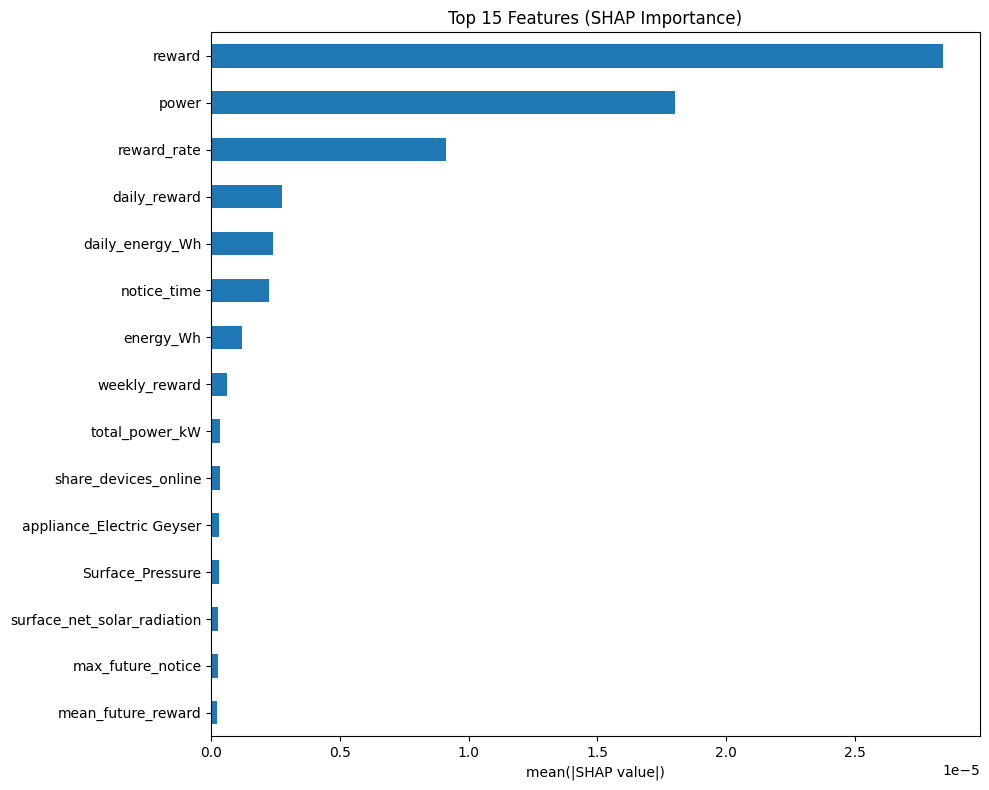


Plotting SHAP beeswarm for top 15 features...


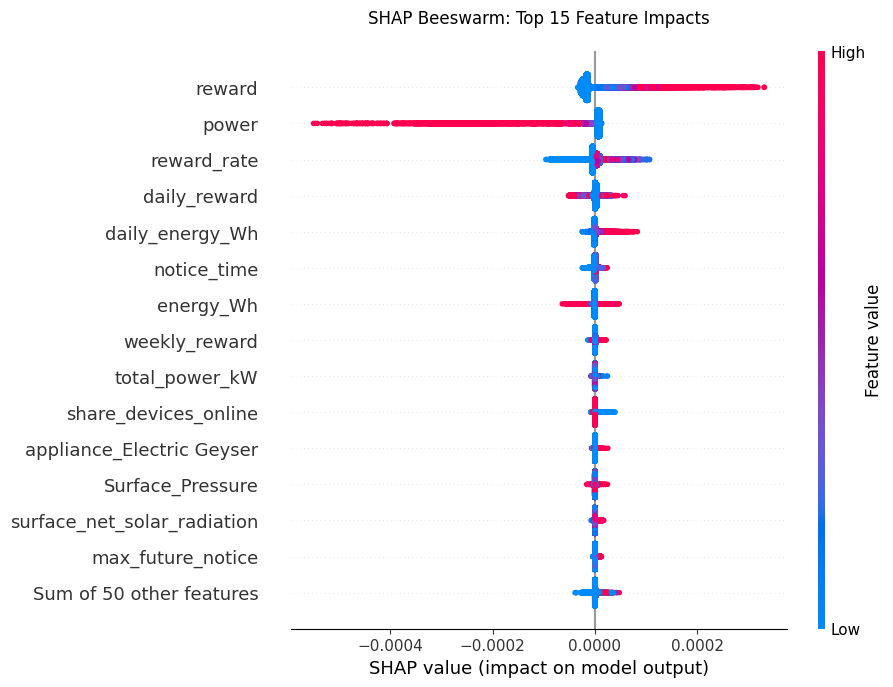

In [29]:
# Run EnergySavingsModel with kWh target, train once, then plot top features and SHAP beeswarm
energy_model = EnergySavingsModel(
    time_col='round_datetime',
    id_col='ca_number',
    event_flag='switch_off_event',
    strict_pre_notice=True,
    use_kwh=True,
    duration_col='period_duration',
    power_unit='W'
)

# Single call: preprocess → train LightGBM → compute SHAP on validation
energy_model.train(smart_switch_data)

# Compute and print directional SHAP summary
print("\n--- Directional SHAP Summary (Top Features) ---")
energy_model.compute_directional_shap_summary(
    shap_values=energy_model.shap_values,
    X_valid=energy_model.X_valid,
    top_n=15
)

# Optional: Visualizations
print("\n--- Generating plots ---")
# Bar chart of top-15 features by mean(|SHAP|)
energy_model.plot_feature_importance(top_n=15)

# SHAP beeswarm for top-15 features
energy_model.plot_shap_beeswarm(top_n=15)


### Baseline model: Linear Regression and Ridge Regression

Step 1: Creating energy savings target...
Step 2: Engineering fatigue features...

Top Linear Regression Coefficients (strict_pre_notice=True):
power                           -0.000085
appliance_Car Charging socket    0.000068
day_of_year_sin                 -0.000013
daily_energy_Wh                  0.000011
month_sin                        0.000010
hour_sin                         0.000008
reward                           0.000007
appliance_Washing Machine       -0.000007
cust_seg_safe                   -0.000007
total_device_count               0.000007
dtype: float64
[Linear] RMSE=0.0001, MAE=0.0000

Top Ridge Regression Coefficients (strict_pre_notice=True):
power                           -0.000085
appliance_Car Charging socket    0.000067
day_of_year_sin                 -0.000013
daily_energy_Wh                  0.000011
month_sin                        0.000010
hour_sin                         0.000008
reward                           0.000007
appliance_Washing Machine       -

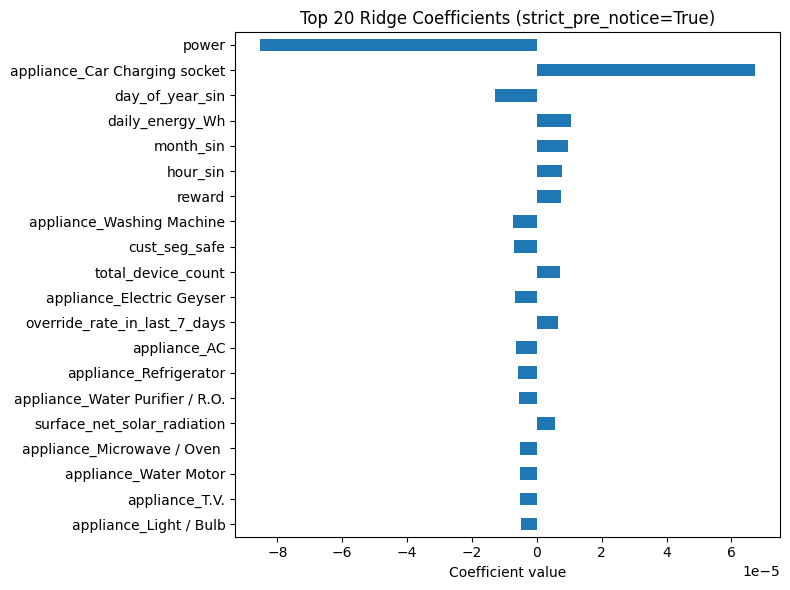

In [ ]:
# Build strict pre-notice modeling frame → time split → linear & ridge baselines → report & plot

# Build the modeling dataframe (strict pre-notice)
energy_model = EnergySavingsModel(
    time_col='round_datetime',
    id_col=None,
    event_flag='switch_off_event',
    strict_pre_notice=True,     # enable strict mode (exclude baseline-like/leaky features)
    smooth_minutes=0,
    use_kwh=True,
    duration_col='period_duration',
    slot_minutes=30,
    power_unit='W'
)

# Ensure ID and time columns are present, typed, and sorted
df = energy_model._ensure_id_col(smart_switch_data)
df = energy_model._ensure_time_col(df)

# Create regression target (energy_savings) on event rows + derive fatigue features
df_evt = energy_model._create_target(df)
fatigue = energy_model._create_fatigue_features(df)

# Join target with fatigue features; fill missing values
df_model = df_evt.merge(fatigue, on=[energy_model.id_col, energy_model.time_col], how='left')
df_model = df_model.fillna(0)

# Leak-safe feature selection; build X/y arrays
features = energy_model._select_features(df_model)
X = df_model[features].values
y = df_model[energy_model.target_col].values

# Time-based split (same as in your class)
q1 = df_model[energy_model.time_col].quantile(0.7)
train_mask = df_model[energy_model.time_col] <= q1
test_mask  = df_model[energy_model.time_col] > q1

X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[test_mask], y[test_mask]

# Linear Regression
lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred_lin = lin.predict(X_test)

# Rank linear coefficients by absolute magnitude for interpretability
lin_coefs = pd.Series(lin.coef_, index=features).sort_values(key=abs, ascending=False)
print("\nTop Linear Regression Coefficients (strict_pre_notice=True):")
print(lin_coefs.head(10))

print(f"[Linear] RMSE={np.sqrt(mean_squared_error(y_test, y_pred_lin)):.4f}, "
      f"MAE={mean_absolute_error(y_test, y_pred_lin):.4f}")

# Ridge Regression
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Rank ridge coefficients by absolute magnitude
ridge_coefs = pd.Series(ridge.coef_, index=features).sort_values(key=abs, ascending=False)
print("\nTop Ridge Regression Coefficients (strict_pre_notice=True):")
print(ridge_coefs.head(10))

print(f"[Ridge] RMSE={np.sqrt(mean_squared_error(y_test, y_pred_ridge)):.4f}, "
      f"MAE={mean_absolute_error(y_test, y_pred_ridge):.4f}")

# Plot coefficients
plt.figure(figsize=(8,6))
ridge_coefs.head(20).iloc[::-1].plot(kind="barh")
plt.title("Top 20 Ridge Coefficients (strict_pre_notice=True)")
plt.xlabel("Coefficient value")
plt.tight_layout()
plt.show()


### Energy Savings and Fatigue Forecasting (TCN model)

In [30]:
# Temporal ConvNet pipeline for energy-savings prediction (strict_pre_notice=True, kWh target)
# Drop-in cell: prepares data and features for a TCN-style model

# Lightweight EnergySavingsModel used for building targets/features for the TCN workflow
class EnergySavingsModel:
    def __init__(
        self,
        time_col: str = 'round_datetime',
        id_col: str | None = None,
        event_flag: str = 'switch_off_event',
        strict_pre_notice: bool = False,
        smooth_minutes: int = 0,            # optional extra smoothing of baseline
        use_kwh: bool = True,               # compute energy savings in kWh (else power delta)
        duration_col: str | None = 'period_duration',  # minutes; falls back to slot_minutes
        slot_minutes: int = 30,
        power_unit: str = 'W'               # 'W' or 'kW' for input power columns
    ):
        self.time_col = time_col
        self.id_col = id_col
        self.event_flag = event_flag
        self.strict_pre_notice = strict_pre_notice
        self.smooth_minutes = smooth_minutes
        self.use_kwh = use_kwh
        self.duration_col = duration_col
        self.slot_minutes = slot_minutes
        self.power_unit = power_unit

        self.target_col = 'energy_savings'
        self.features_used = None

    # utilities
    def _ensure_id_col(self, df: pd.DataFrame) -> pd.DataFrame:
        # auto-detect a customer ID column; if missing, try index; else raise
        if self.id_col and self.id_col in df.columns:
            return df
        for c in ['ca_number', 'customer_id', 'ca_id']:
            if c in df.columns:
                self.id_col = c
                return df
        idx_names = [n for n in (df.index.names or []) if n]
        if df.index.name and df.index.name not in idx_names:
            idx_names.append(df.index.name)
        for c in ['ca_number','customer_id','ca_id']:
            if c in idx_names:
                df = df.reset_index()
                self.id_col = c
                return df
        raise KeyError("Could not find an ID column (tried ca_number/customer_id/ca_id). Pass id_col=...")

    def _ensure_time_col(self, df: pd.DataFrame) -> pd.DataFrame:
        # ensure timestamp column exists, is datetime, and data is sorted by id/time
        if self.time_col not in df.columns:
            raise KeyError(f"Missing time column '{self.time_col}'.")
        d = df.copy()
        d[self.time_col] = pd.to_datetime(d[self.time_col], errors='coerce')
        d = d.dropna(subset=[self.time_col]).sort_values([self.id_col, self.time_col]).reset_index(drop=True)
        return d

    # target construction
    def _create_target(self, df: pd.DataFrame) -> pd.DataFrame:
        # build event-level energy savings (kWh or power delta), optionally smoothing baseline
        if self.event_flag not in df.columns:
            raise ValueError(f"Missing event flag column: '{self.event_flag}'")
        d = df[df[self.event_flag] == 1].copy()

        if 'power' not in d.columns:
            raise ValueError("Missing 'power' column.")
        if 'pre_switch_off_reading' not in d.columns:
            raise ValueError("Missing 'pre_switch_off_reading' (5-min pre-event avg power).")

        baseline = d['pre_switch_off_reading']

        # optional rolling-smooth for baseline; default off
        if self.smooth_minutes and self.smooth_minutes > 0:
            base = df[[self.id_col, self.time_col, 'pre_switch_off_reading']].copy()
            def roll_smooth(g):
                g = g.sort_values(self.time_col)
                s = (g.set_index(self.time_col)['pre_switch_off_reading']
                        .rolling(f'{self.smooth_minutes}min', closed='left').mean())
                return pd.DataFrame({
                    self.time_col: s.index,
                    'pre_switch_smoothed': s.values,
                    self.id_col: g[self.id_col].iloc[0]
                })
            sm = (base.groupby(self.id_col, group_keys=False)
                       .apply(roll_smooth).reset_index(drop=True))
            d = d.merge(sm[[self.id_col, self.time_col, 'pre_switch_smoothed']],
                        on=[self.id_col, self.time_col], how='left')
            baseline = d['pre_switch_smoothed'].fillna(baseline)

        if not self.use_kwh:
            # return power difference in the same unit as 'power'
            d[self.target_col] = baseline - d['power']
        else:
            # convert to kWh via duration
            scale = 0.001 if self.power_unit.lower() == 'w' else 1.0
            base_kw = baseline * scale
            pow_kw  = d['power'] * scale
            if self.duration_col and self.duration_col in d.columns:
                dur_h = d[self.duration_col].astype(float) / 60.0
            else:
                dur_h = float(self.slot_minutes) / 60.0
            d[self.target_col] = (base_kw - pow_kw) * dur_h
        return d.dropna(subset=[self.target_col])

    # feature selection
    def _select_features(self, df: pd.DataFrame) -> list[str]:
        # keep numeric, leak-safe features; optionally one-hot cust_seg_safe
        exclude = {
            self.target_col, self.time_col, self.id_col, 'override',
            'start_event', 'end_event', 'actual_event',
            'future_switch_off_count', 'past_switch_off_count',
            'time_to_next_switch_off', 'time_since_last_switch_off',
            'max_future_notice', 'time_to_first_notice',
            'mean_future_reward', 'std_future_reward',
        }
        if self.strict_pre_notice:
            exclude |= {
                'pre_switch_off_reading', 'pre_switch_smoothed',
                'average_power_before_switchoff', 'mean_W_before_switchoff',
            }

        d = df.copy()
        if 'cust_seg_safe' in d.columns and d['cust_seg_safe'].dtype.name not in ('int64','float64','bool'):
            d = pd.get_dummies(d, columns=['cust_seg_safe'], prefix='cust_seg_safe')

        feats = [c for c in d.columns if c not in exclude and pd.api.types.is_numeric_dtype(d[c])]
        return feats

# Build a modeling frame with strict pre-notice and kWh target
# smart_switch_data is expected in memory
assert 'smart_switch_data' in globals(), "Please provide smart_switch_data DataFrame first."

energy_model = EnergySavingsModel(
    time_col='round_datetime',
    id_col=None,                      # auto-detect ca_number/customer_id/ca_id
    event_flag='switch_off_event',
    strict_pre_notice=True,           # exclude baseline-like/leaky inputs
    smooth_minutes=0,                 # baseline already smoothed (5-min avg)
    use_kwh=True,                     # predict energy savings (kWh)
    duration_col='period_duration',   # minutes; falls back to slot_minutes if missing
    slot_minutes=30,
    power_unit='W'
)

df = energy_model._ensure_id_col(smart_switch_data)
df = energy_model._ensure_time_col(df)

# event rows + target; add fatigue features if available
df_evt   = energy_model._create_target(df)
fatigue  = (lambda d=df: energy_model._create_fatigue_features(d)
            if hasattr(energy_model, "_create_fatigue_features") else None)()

if fatigue is None:
    # minimal fatigue skeleton if method is absent
    tmp = df[[energy_model.id_col, energy_model.time_col, energy_model.event_flag]].copy()
    tmp['events_in_last_7_days']  = 0.0
    tmp['events_in_last_30_days'] = 0.0
    tmp['cumulative_event_count'] = 0.0
    tmp['cumulative_rewards_earned'] = 0.0
    tmp['override_rate_in_last_7_days'] = 0.0
    fatigue = tmp

df_model = (df_evt
            .merge(fatigue, on=[energy_model.id_col, energy_model.time_col], how='left')
            .fillna(0))

# numeric, leak-safe feature set for sequence learning
feature_cols = energy_model._select_features(df_model)
target_col   = energy_model.target_col
id_col       = energy_model.id_col
tcol         = energy_model.time_col

# order by id/time and keep only the required columns
df_model = df_model[[id_col, tcol, *feature_cols, target_col]].copy()
df_model.sort_values([id_col, tcol], inplace=True)

# chronological split: 70% train / 15% valid / 15% test
q1 = df_model[tcol].quantile(0.70)
q2 = df_model[tcol].quantile(0.85)
m_tr = df_model[tcol] <= q1
m_va = (df_model[tcol] > q1) & (df_model[tcol] <= q2)
m_te = df_model[tcol] > q2

# standardize on TRAIN only to avoid leakage
scaler = StandardScaler()
scaler.fit(df_model.loc[m_tr, feature_cols].values)

def transform_block(d):
    # transform to numpy blocks for downstream TCN: X, y, ids, timestamps
    X = scaler.transform(d[feature_cols].values).astype(np.float32)
    y = d[target_col].values.astype(np.float32)
    ids = d[id_col].values
    times = d[tcol].values
    return X, y, ids, times

X_tr_raw, y_tr_raw, id_tr, t_tr = transform_block(df_model.loc[m_tr])
X_va_raw, y_va_raw, id_va, t_va = transform_block(df_model.loc[m_va])
X_te_raw, y_te_raw, id_te, t_te = transform_block(df_model.loc[m_te])
n_features = X_tr_raw.shape[1]



In [31]:
# Build sequences for many-to-one forecasting: use the previous L events to predict the next kWh value
def build_sequences(X, y, ids, times=None, seq_len=64):
    """
    Slide a user-specific window of length `seq_len` across events.
    For each user, each window of the previous `seq_len` events becomes one input;
    the very next event is the prediction target.

    Inputs
    -------
    X : array-like, shape (N, F)
        Per-event feature matrix.
    y : array-like, shape (N,)
        Per-event target (kWh savings).
    ids : array-like, shape (N,)
        User/customer identifier per event (used to keep windows within a user).
    times : ignored (kept for API symmetry)
    seq_len : int
        Number of past events to use as context.

    Returns
    -------
    X_seq : ndarray, shape (B, F, L)
        Stacked sequences formatted for Conv1d (channels=features, length=seq_len).
    y_seq : ndarray, shape (B,)
        Next-event targets aligned to each window.
    """
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)
    ids = np.asarray(ids)

    out_X, out_y = [], []

    # Build (uid -> row-index list) mapping in ascending order
    df_idx = pd.DataFrame({'uid': ids, 'row': np.arange(len(ids))})
    for uid, sub in df_idx.groupby('uid'):
        arr = sub['row'].values
        if len(arr) <= seq_len:
            continue  # not enough events for this user to form a window + next target

        # j indexes the target event; the window is the previous seq_len events
        for j in range(seq_len, len(arr)):
            win_idx = arr[j - seq_len : j]  # length L, strictly before target
            tgt_idx = arr[j]                # the next event to predict
            out_X.append(X[win_idx, :])     # [L, F]
            out_y.append(y[tgt_idx])        # scalar

    if not out_X:
        # No sequences formed: return correctly shaped empty arrays
        F = X.shape[1]
        return (np.empty((0, F, seq_len), dtype=np.float32),
                np.empty((0,), dtype=np.float32))

    X_seq = np.stack(out_X)                 # [B, L, F]
    X_seq = np.transpose(X_seq, (0, 2, 1))  # [B, F, L] for Conv1d
    y_seq = np.asarray(out_y, dtype=np.float32)
    return X_seq, y_seq

# Apply sequence builder for train/valid/test splits
SEQ_LEN = 64  # decrease to 32 or 16 if too few users have L+1 events
Xtr, ytr = build_sequences(X_tr_raw, y_tr_raw, id_tr, t_tr, seq_len=SEQ_LEN)
Xva, yva = build_sequences(X_va_raw, y_va_raw, id_va, t_va, seq_len=SEQ_LEN)
Xte, yte = build_sequences(X_te_raw, y_te_raw, id_te, t_te, seq_len=SEQ_LEN)
print(f"Seq shapes — Train {Xtr.shape}, Valid {Xva.shape}, Test {Xte.shape}")

# Quick diagnostic: distribution of event counts per user in each split
def seq_stats(ids, name):
    s = pd.Series(ids).value_counts()
    print(f"[{name}] users={len(s)}, events/user (min/median/max): {s.min()}/{s.median()}/{s.max()}")

seq_stats(id_tr, "train")
seq_stats(id_va, "valid")
seq_stats(id_te, "test")

if len(ytr) == 0:
    print(f"No train sequences with L={SEQ_LEN}. Consider lowering SEQ_LEN to 32 or 16, "
          "or using a different split so users have ≥ L+1 events in-train.")

# DataLoaders (minimal wrappers around NumPy arrays)
class SeqDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return torch.from_numpy(self.X[i]), torch.tensor(self.y[i])

def make_loader(X, y, bs, shuffle):
    nw = min(8, os.cpu_count() or 4)
    return DataLoader(
        SeqDataset(X, y),
        batch_size=bs, shuffle=shuffle, drop_last=False,
        num_workers=nw, pin_memory=torch.cuda.is_available(),
        persistent_workers=True, prefetch_factor=4
    )

BATCH_TRAIN = 512
BATCH_EVAL  = 512
dl_tr = make_loader(Xtr, ytr, BATCH_TRAIN, True)
dl_va = make_loader(Xva, yva, BATCH_EVAL,  False)
dl_te = make_loader(Xte, yte, BATCH_EVAL,  False)

# Temporal Convolutional Network (causal, dilated) for sequence-to-one regression
class Chomp1d(nn.Module):
    def __init__(self, chomp): super().__init__(); self.chomp = chomp
    def forward(self, x): return x[..., :-self.chomp] if self.chomp > 0 else x

class TCNBlock(nn.Module):
    def __init__(self, c_in, c_out, k=3, dilation=1, dropout=0.1):
        super().__init__()
        pad = (k - 1) * dilation  # causal padding size
        self.conv1 = nn.Conv1d(c_in, c_out, kernel_size=k, padding=pad, dilation=dilation)
        self.chomp1 = Chomp1d(pad); self.bn1 = nn.BatchNorm1d(c_out)
        self.conv2 = nn.Conv1d(c_out, c_out, kernel_size=k, padding=pad, dilation=dilation)
        self.chomp2 = Chomp1d(pad); self.bn2 = nn.BatchNorm1d(c_out)
        self.dropout = nn.Dropout(dropout)
        self.res = nn.Conv1d(c_in, c_out, 1) if c_in != c_out else nn.Identity()
    def forward(self, x):
        y = self.conv1(x); y = self.chomp1(y); y = self.bn1(F.relu(y)); y = self.dropout(y)
        y = self.conv2(y); y = self.chomp2(y); y = self.bn2(F.relu(y)); y = self.dropout(y)
        return F.relu(y + self.res(x))

class TCN(nn.Module):
    def __init__(self, in_ch, channels=(64,64,64,64), k=3, dropout=0.1):
        super().__init__()
        blocks = []
        dil = 1
        c = in_ch
        for c_out in channels:
            blocks.append(TCNBlock(c, c_out, k=k, dilation=dil, dropout=dropout))
            c = c_out; dil *= 2  # dilation growth: 1, 2, 4, 8, ...
        self.tcn = nn.Sequential(*blocks)
        self.head = nn.Sequential(nn.AdaptiveAvgPool1d(1), nn.Flatten(), nn.Linear(c, 1))
    def forward(self, x):  # x: [B, F, L]
        z = self.tcn(x)
        return self.head(z).squeeze(1)  # [B]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = TCN(in_ch=n_features, channels=(64,64,64,64), k=3, dropout=0.1).to(device)


Seq shapes — Train (145140, 61, 64), Valid (9919, 61, 64), Test (8581, 61, 64)
[train] users=770, events/user (min/median/max): 1/235.5/681
[valid] users=545, events/user (min/median/max): 1/86.0/106
[test] users=542, events/user (min/median/max): 1/83.5/97


In [32]:
# Train and evaluate a TCN regressor for kWh savings, with early stopping and feature occlusion analysis

# Optimizer and loss (MAE for kWh; swap to MSE if desired)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.L1Loss()  # MAE for kWh; switch to MSE if you prefer

def evaluate(model, dataloader):
    """Run model in eval mode and return RMSE, MAE, and the true/predicted arrays."""
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            y_true.append(yb.cpu())
            y_pred.append(pred.cpu())
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
    mae  = float(np.mean(np.abs(y_true - y_pred)))
    return rmse, mae, y_true, y_pred

# Training loop with gradient clipping and patience-based early stopping on validation RMSE
best_val = float('inf'); patience = 5; bad = 0; best_state = None
EPOCHS = 25
for epoch in range(1, EPOCHS+1):
    model.train()
    for xb, yb in dl_tr:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(set_to_none=True); loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
    # Validate once per epoch
    gc.collect();
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    rmse_va, mae_va, *_ = evaluate(model, dl_va)
    print(f"Epoch {epoch:02d} | Valid RMSE={rmse_va:.5f}  MAE={mae_va:.5f}")
    if rmse_va + 1e-9 < best_val:
        best_val = rmse_va; bad = 0
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping."); break

# Restore best checkpoint (if captured) and evaluate on test set
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k,v in best_state.items()})
rmse_te, mae_te, y_true_te, y_pred_te = evaluate(model, dl_te)
print(f"[TCN Test] RMSE={rmse_te:.5f}  MAE={mae_te:.5f}")

# Feature occlusion analysis: zero one feature across the full window to measure ΔMAE on validation
def occlusion_importance(model, dloader, drop_idx):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in dloader:
            xb = xb.clone()
            xb[:, drop_idx, :] = 0.0  # zero this feature across the whole window
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            ys.append(yb.cpu().numpy()); ps.append(pred.cpu().numpy())
    y_true = np.concatenate(ys); y_pred = np.concatenate(ps)
    return float(np.mean(np.abs(y_true - y_pred)))

# Compute baseline MAE and per-feature ΔMAE (higher ΔMAE ⇒ more important)
base_mae = evaluate(model, dl_va)[1]
delta_mae = []
for j, f in enumerate(feature_cols):
    mae_j = occlusion_importance(model, dl_va, j)
    delta_mae.append((f, mae_j - base_mae))
imp_df = (pd.DataFrame(delta_mae, columns=["feature", "delta_MAE"])
          .sort_values("delta_MAE", ascending=False))
print("\nTCN Occlusion Importance (ΔMAE on validation):")
print(imp_df.head(15).to_string(index=False))


Epoch 01 | Valid RMSE=0.09229  MAE=0.03764
Epoch 02 | Valid RMSE=0.03010  MAE=0.01198
Epoch 03 | Valid RMSE=0.01428  MAE=0.00835
Epoch 04 | Valid RMSE=0.03523  MAE=0.01585
Epoch 05 | Valid RMSE=0.04645  MAE=0.02377
Epoch 06 | Valid RMSE=0.19655  MAE=0.02772
Epoch 07 | Valid RMSE=0.08990  MAE=0.01438
Epoch 08 | Valid RMSE=0.07894  MAE=0.01857
Early stopping.
[TCN Test] RMSE=0.01893  MAE=0.01074

TCN Occlusion Importance (ΔMAE on validation):
               feature  delta_MAE
         precipitation   0.000793
             month_cos   0.000687
       day_of_year_cos   0.000668
           reward_rate   0.000519
        wind_direction   0.000185
           city_mumbai   0.000159
appliance_Refrigerator   0.000146
            city_delhi   0.000116
          device_count   0.000104
          daily_reward   0.000082
         weekly_reward   0.000076
  appliance_Air Cooler   0.000053
 appliance_Water Motor   0.000019
    total_device_count   0.000016
       daily_energy_Wh   0.000013


### Optimzed the TCN

In [ ]:
# Optuna objective for TCN hyperparameter tuning (minimize validation RMSE)
def objective(trial: Trial):
    """
    Sample TCN hyperparameters, train briefly, and return the best validation RMSE.

    Tuned params:
      - num_layers: depth of the TCN
      - hidden_size: channels per block
      - kernel_size: 3, 5, or 7
      - dropout: 0.0–0.5
      - lr: 1e-4–1e-2 (log scale)
    """
    # Hyperparameters
    num_layers  = trial.suggest_int("num_layers", 2, 5)
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128])
    kernel_size = trial.suggest_int("kernel_size", 3, 7, step=2)  # 3,5,7
    dropout     = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    lr          = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    channels = tuple([hidden_size] * num_layers)
    model = TCN(in_ch=n_features, channels=channels, k=kernel_size, dropout=dropout).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = nn.L1Loss()

    best_val = float("inf")
    patience = 3
    bad = 0
    EPOCHS = 15

    # Optional: cap batches per epoch for speed
    max_train_batches = 200   # set None for full pass
    max_valid_batches = 200

    for epoch in range(EPOCHS):
        model.train()
        for b, (xb, yb) in enumerate(dl_tr):
            if (max_train_batches is not None) and (b >= max_train_batches):
                break
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        # Validation
        rmse_va, mae_va, *_ = evaluate(model, dl_va)

        # Report and allow pruning
        trial.report(rmse_va, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Early stop within trial
        if rmse_va + 1e-9 < best_val:
            best_val = rmse_va
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    return best_val  # objective

# Run optimization
study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=30)

print("Best RMSE:", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")



[I 2025-08-22 00:23:12,943] A new study created in memory with name: no-name-43a92898-3c22-477b-8a23-d082d78c77eb
[I 2025-08-22 00:23:40,222] Trial 0 finished with value: 0.017851876094937325 and parameters: {'num_layers': 3, 'hidden_size': 32, 'kernel_size': 3, 'dropout': 0.0, 'lr': 0.00013066739238053285}. Best is trial 0 with value: 0.017851876094937325.
[I 2025-08-22 00:23:58,891] Trial 1 finished with value: 0.09267125278711319 and parameters: {'num_layers': 5, 'hidden_size': 64, 'kernel_size': 7, 'dropout': 0.4, 'lr': 0.00026587543983272726}. Best is trial 0 with value: 0.017851876094937325.
[I 2025-08-22 00:24:15,395] Trial 2 finished with value: 0.006205298006534576 and parameters: {'num_layers': 2, 'hidden_size': 128, 'kernel_size': 5, 'dropout': 0.1, 'lr': 0.0016738085788752138}. Best is trial 2 with value: 0.006205298006534576.
[I 2025-08-22 00:24:26,284] Trial 3 finished with value: 0.022345110774040222 and parameters: {'num_layers': 2, 'hidden_size': 128, 'kernel_size': 7,

Best RMSE: 0.00030413424246944487
Best hyperparameters:
  num_layers: 3
  hidden_size: 64
  kernel_size: 7
  dropout: 0.0
  lr: 0.009413993046829943


--- Retraining TCN with best hyperparameters ---
Epoch 01 | Train MAE≈0.03846 | Valid RMSE=0.06472 MAE=0.00873
Epoch 02 | Train MAE≈0.00406 | Valid RMSE=0.01969 MAE=0.00381
Epoch 03 | Train MAE≈0.00229 | Valid RMSE=0.00777 MAE=0.00193
Epoch 04 | Train MAE≈0.00124 | Valid RMSE=0.00145 MAE=0.00138
Epoch 05 | Train MAE≈0.00119 | Valid RMSE=0.00072 MAE=0.00068
Epoch 06 | Train MAE≈0.00101 | Valid RMSE=0.00063 MAE=0.00062
Epoch 07 | Train MAE≈0.00102 | Valid RMSE=0.00116 MAE=0.00116
Epoch 08 | Train MAE≈0.00101 | Valid RMSE=0.00046 MAE=0.00045
Epoch 09 | Train MAE≈0.00098 | Valid RMSE=0.00121 MAE=0.00120
Epoch 10 | Train MAE≈0.00096 | Valid RMSE=0.00090 MAE=0.00089
Epoch 11 | Train MAE≈0.00094 | Valid RMSE=0.00072 MAE=0.00072
Epoch 12 | Train MAE≈0.00074 | Valid RMSE=0.00106 MAE=0.00106
Epoch 13 | Train MAE≈0.00075 | Valid RMSE=0.00103 MAE=0.00102
Early stopping triggered.
[Final TCN Test] RMSE=0.00047 | MAE=0.00046


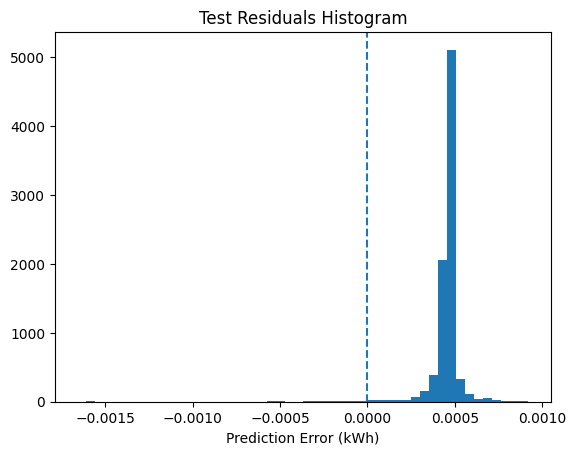

In [33]:
# Final TCN retraining using best hyperparameters selected via Optuna (or manual choice)

# Hyperparameters chosen from the tuning phase
best_params = {
    "num_layers": 3,         # depth: number of TCN blocks
    "hidden_size": 64,       # channels per block
    "kernel_size": 7,        # temporal receptive field per block
    "dropout": 0.0,          # dropout inside blocks
    "lr": 0.009413993046829943  # learning rate for AdamW
}

# Rebuild the TCN with the tuned configuration
print("--- Retraining TCN with best hyperparameters ---")
final_model = TCN(
    in_ch=n_features,
    channels=tuple([best_params["hidden_size"]] * best_params["num_layers"]),  # repeat per layer
    k=best_params["kernel_size"],
    dropout=best_params["dropout"]
).to(device)

# Optimizer / objective / LR scheduler
opt = torch.optim.AdamW(final_model.parameters(), lr=best_params["lr"], weight_decay=1e-4)
loss_fn = nn.L1Loss()  # MAE loss for kWh regression
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode="min",        # reduce LR when validation RMSE plateaus
    factor=0.5,
    patience=2
)

# Early-stopping control on validation RMSE
EPOCHS = 25
patience = 5
best_val = float("inf")
bad = 0
best_state = None

# Standard training loop
for epoch in range(1, EPOCHS + 1):
    final_model.train()
    running_loss, nobs = 0.0, 0  # track training loss over examples (for a quick MAE proxy)

    for xb, yb in dl_tr:
        xb, yb = xb.to(device), yb.to(device)
        pred = final_model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(final_model.parameters(), 1.0)  # stabilize updates
        opt.step()
        running_loss += loss.item() * xb.size(0)
        nobs += xb.size(0)

    # Validation metrics and scheduler step
    rmse_va, mae_va, *_ = evaluate(final_model, dl_va)
    train_mae_approx = running_loss / max(nobs, 1)
    print(f"Epoch {epoch:02d} | Train MAE≈{train_mae_approx:.5f} | Valid RMSE={rmse_va:.5f} MAE={mae_va:.5f}")

    scheduler.step(rmse_va)

    # Keep the best checkpoint (lowest valid RMSE) and apply patience-based stopping
    if rmse_va + 1e-9 < best_val:
        best_val = rmse_va
        bad = 0
        best_state = {k: v.detach().cpu().clone() for k, v in final_model.state_dict().items()}
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping triggered.")
            break

# Load best weights captured during training (if any)
if best_state is not None:
    final_model.load_state_dict(best_state)
    final_model.to(device)

# Final test evaluation
rmse_te, mae_te, y_true_te, y_pred_te = evaluate(final_model, dl_te)
if len(y_true_te) == 0:
    print("[Final TCN Test] No test sequences — check SEQ_LEN or split.")
else:
    print(f"[Final TCN Test] RMSE={rmse_te:.5f} | MAE={mae_te:.5f}")

    # Residual analysis to inspect error distribution
    resid = y_true_te - y_pred_te
    plt.hist(resid, bins=50)
    plt.axvline(0.0, linestyle="--")
    plt.xlabel("Prediction Error (kWh)")
    plt.title("Test Residuals Histogram")
    plt.show()


Feature explaination by SHAP

In [42]:
def compute_directional_shap_summary_tcn(shap_vals, test_batch, feature_names, top_n=15):
    """
    Compute directional SHAP summary statistics for a temporal model (e.g. TCN) at the last time step.

    Reports for the top-N features:
      - mean_SHAP_logit:     average SHAP value (logit units, direction-aware)
      - mean_abs_SHAP_logit: average |SHAP| (global importance)
      - mean_delta_prob_pp:  mean marginal change in predicted probability (percentage points)
      - median_delta_prob_pp:median marginal change in predicted probability (percentage points)
      - p5..p95_delta_prob_pp: 5th–95th percentile range of probability change (pp)
    """

    def sigmoid(z): return 1.0 / (1.0 + np.exp(-z))

    # SHAP values and “logit” at the last time step
    shap_last = shap_vals[:, :, -1]                # (B, F)
    logit_full = shap_last.sum(axis=1)             # bias omitted for simplicity

    # Rank features by mean |SHAP|
    top_idx = np.argsort(np.abs(shap_last).mean(axis=0))[-top_n:][::-1]

    rows = []
    for i in top_idx:
        shap_i = shap_last[:, i]
        # marginal prob delta from this feature's contribution
        z_wo = logit_full - shap_i
        delta_p = sigmoid(z_wo + shap_i) - sigmoid(z_wo)

        rows.append({
            "feature": feature_names[i],
            "mean_SHAP_logit": float(np.mean(shap_i)),
            "mean_abs_SHAP_logit": float(np.mean(np.abs(shap_i))),
            "mean_delta_prob_pp": float(100 * np.mean(delta_p)),
            "median_delta_prob_pp": float(100 * np.median(delta_p)),
            "p5..p95_delta_prob_pp": f"{100*np.percentile(delta_p,5):.2f}..{100*np.percentile(delta_p,95):.2f}",
        })
    import pandas as pd
    return pd.DataFrame(rows)


def run_shap_analysis_tcn(model, train_loader, test_loader, feature_names, device,
                          bg_size=128, max_explain=256, top_n=15):
    """
    SHAP analysis for a many-to-one TCN using GradientExplainer.

    - Builds a small background set from TRAIN for the explainer
    - Explains a capped TEST batch
    - Prints & plots global importance (mean |SHAP| over batch × time) for top-N
    - Prints directional summary (method-1 style) for top-N at the last time step
    - Returns (imp_df, dir_summary_df, shap_vals, test_batch)
    """

    # Helper: wrap model to [B,1] output if needed
    class TwoDOutput(nn.Module):
        def __init__(self, base): super().__init__(); self.base = base
        def forward(self, x):
            y = self.base(x)
            return y.unsqueeze(1) if y.ndim == 1 else y

    # Helper: normalize SHAP output to (B, F, L)
    def _unwrap_shap_values(shap_vals):
        if isinstance(shap_vals, tuple): shap_vals, _ = shap_vals
        if isinstance(shap_vals, list) and len(shap_vals) > 0: shap_vals = shap_vals[0]
        if isinstance(shap_vals, np.ndarray) and shap_vals.ndim == 4 and shap_vals.shape[-1] == 1:
            shap_vals = np.squeeze(shap_vals, axis=-1)
        return shap_vals

    # Background (train) and explanation (test) batches
    tr_safe = DataLoader(train_loader.dataset,
                         batch_size=min(bg_size, getattr(train_loader, "batch_size", bg_size)),
                         shuffle=False, num_workers=0)
    te_safe = DataLoader(test_loader.dataset,
                         batch_size=min(max_explain, getattr(test_loader, "batch_size", max_explain)),
                         shuffle=False, num_workers=0)

    try:
        background_data, _ = next(iter(tr_safe))
        test_batch, _ = next(iter(te_safe))
    except StopIteration:
        raise RuntimeError("Train or Test loader is empty. Cannot run SHAP analysis.")

    background_data = background_data.to(device)
    test_batch = test_batch.to(device)

    # Compute SHAP values on the test batch
    print("\n--- Running SHAP Analysis ---")
    model_wrapped = TwoDOutput(model).to(device).eval()
    explainer = shap.GradientExplainer(model_wrapped, background_data)
    shap_vals = explainer.shap_values(test_batch, ranked_outputs=1)
    shap_vals = _unwrap_shap_values(shap_vals)

    if not isinstance(shap_vals, np.ndarray): shap_vals = np.array(shap_vals)
    if shap_vals.ndim != 3:
        raise ValueError(f"Unexpected SHAP shape {shap_vals.shape}; expected (B, F, L).")

    # ── Global importance across batch × time
    shap_values_agg = np.mean(np.abs(shap_vals), axis=(0, 2))
    imp_df = (pd.DataFrame({"feature": feature_names, "mean_abs_shap": shap_values_agg})
                .sort_values("mean_abs_shap", ascending=False)
                .reset_index(drop=True))

    # Print top-N table
    print(f"\nTop {top_n} Features by SHAP Importance:")
    print(imp_df.head(top_n).to_string(index=False))

    # Plot: top-N global importance (barh)
    top_plot = imp_df.head(top_n).iloc[::-1]
    plt.figure(figsize=(10, 8))
    plt.barh(top_plot["feature"], top_plot["mean_abs_shap"])
    plt.xlabel("mean(|SHAP value|) aggregated over time")
    plt.title("SHAP Feature Importance — TCN")
    plt.tight_layout()
    plt.show()

    # ── Beeswarm inputs: last time step for top-N features
    top_feature_names = imp_df.head(top_n)["feature"].tolist()
    feature_indices = [feature_names.index(col) for col in top_feature_names]
    shap_last_topN  = shap_vals[:, feature_indices, -1]
    feats_last_topN = test_batch[:, feature_indices, -1].detach().cpu().numpy()

    # Beeswarm (last time step, top-N features)
    print(f"\n--- Generating SHAP Beeswarm Plot for Top {top_n} Features ---")
    shap.summary_plot(shap_last_topN, features=feats_last_topN,
                      feature_names=top_feature_names, show=False)
    ax = plt.gca()
    ax.set_xlabel("SHAP value (impact on model output)", fontsize=10)
    plt.title(f"SHAP Beeswarm Plot for Top {top_n} Features")
    plt.tight_layout()
    plt.show()

    # ── Directional SHAP summary (method 1-style) at last time step
    dir_summary_df = compute_directional_shap_summary_tcn(
        shap_vals=shap_vals,
        test_batch=test_batch,
        feature_names=feature_names,
        top_n=top_n
    )
    print(f"\nDirectional SHAP Summary (Top {top_n} Features):")
    print(dir_summary_df[[
        "feature",
        "mean_SHAP_logit",
        "mean_abs_SHAP_logit",
        "mean_delta_prob_pp",
        "median_delta_prob_pp"
    ]].to_string(index=False))

    # Return both tables + raw SHAP/test batch in case you want to reuse
    return imp_df, dir_summary_df, shap_vals, test_batch



--- Running SHAP Analysis ---

Top 15 Features by SHAP Importance:
                    feature  mean_abs_shap
     appliance_Light / Bulb   4.186364e-07
              precipitation   3.216473e-07
                  month_sin   3.111162e-07
            day_of_year_sin   2.906841e-07
                        obs   2.419575e-07
               device_count   2.195754e-07
              week_in_trial   2.123381e-07
               appliance_AC   1.767485e-07
       share_devices_online   1.595584e-07
appliance_Microwave / Oven    1.365930e-07
         total_device_count   1.293140e-07
             wind_direction   1.272382e-07
surface_net_solar_radiation   1.271181e-07
            device_readings   1.157165e-07
                reward_rate   1.092451e-07


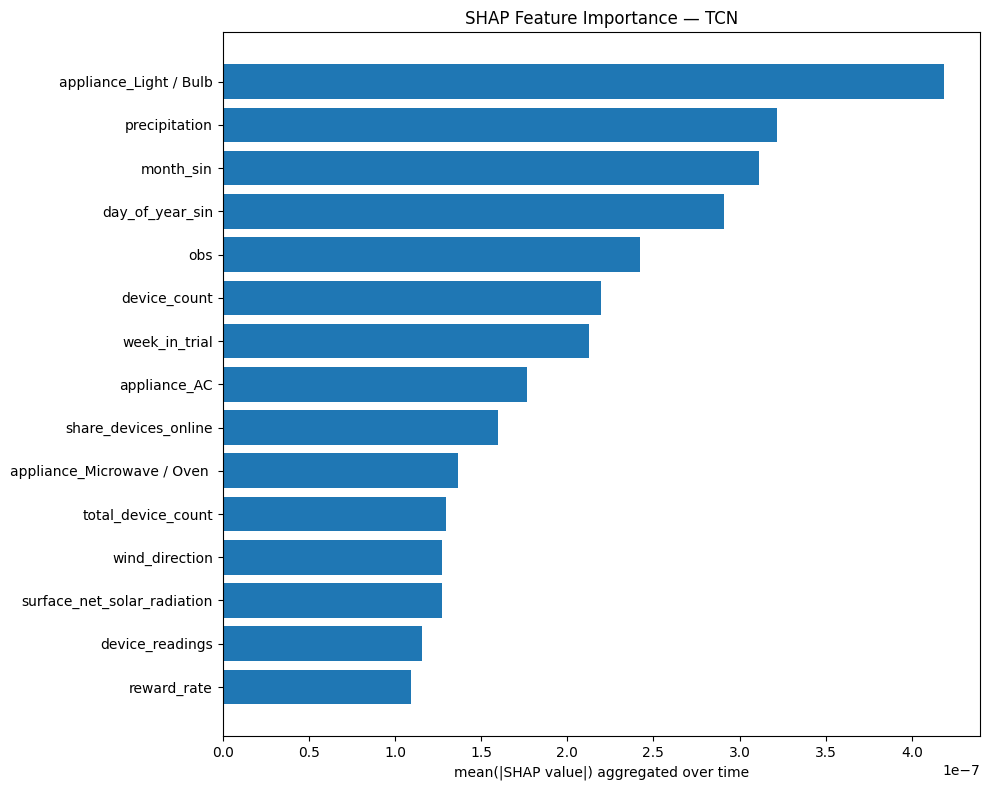


--- Generating SHAP Beeswarm Plot for Top 15 Features ---


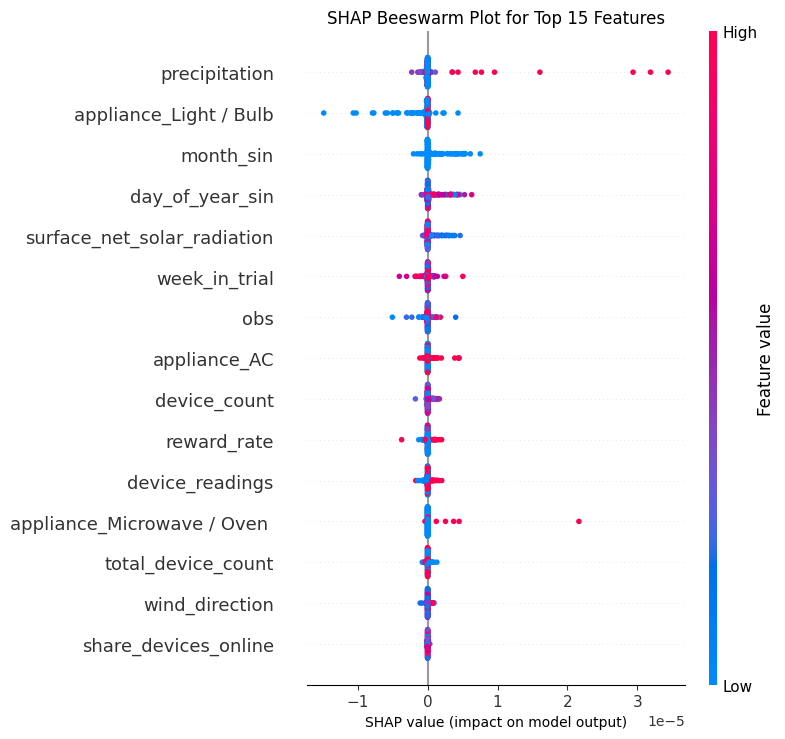


Directional SHAP Summary (Top 15 Features):
                    feature  mean_SHAP_logit  mean_abs_SHAP_logit  mean_delta_prob_pp  median_delta_prob_pp
              precipitation     5.344970e-07         6.464087e-07        1.336242e-05         -1.044775e-10
     appliance_Light / Bulb    -4.699413e-07         5.708544e-07       -1.174853e-05          0.000000e+00
                  month_sin     4.902103e-07         5.530505e-07        1.225526e-05          1.054300e-06
            day_of_year_sin     4.671802e-07         5.207354e-07        1.167951e-05          1.145852e-06
surface_net_solar_radiation     2.270271e-07         2.745414e-07        5.675677e-06          0.000000e+00
                temperature    -2.210061e-07         2.288607e-07       -5.525153e-06         -1.006736e-06
              week_in_trial     2.275857e-08         2.110017e-07        5.689643e-07          0.000000e+00
                notice_time     6.807112e-08         1.950215e-07        1.701778e-06      

In [44]:
imp_tbl, dir_summary, shap_vals, test_batch = run_shap_analysis_tcn(
    model=final_model,
    train_loader=dl_tr,
    test_loader=dl_te,
    feature_names=feature_cols,
    device=device,
    top_n=15
)


